In [1]:
import xarray as xr
import numpy as np
import scipy.constants as sp
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
#import SALevels as SA
import colorcet as cc
import seaborn as sns
import time

In [2]:
## COMPUTING HEATING RATES AND ERRORS
eval1_ref = xr.open_dataset("/data/robertp/CKDMIP_LBL/evaluation1/lw_fluxes/ckdmip_evaluation1_lw_fluxes-4angle_present.h5",
                     engine = "netcdf4")
eval2_ref = xr.open_dataset("/data/robertp/CKDMIP_LBL/evaluation2/lw_fluxes/ckdmip_evaluation2_lw_fluxes-4angle_present.h5",
                     engine = "netcdf4")

In [3]:
### make figs that use only select levels as reference

### Color scheme
colors = cc.bmy
color_scheme_short =  np.array(colors)[[30, 190]]
color_scheme_6 =  np.array(colors)[np.arange(30, len(colors), len(colors)/6, dtype = int)]
color_scheme_5 =  np.array(colors)[np.arange(30, len(colors), len(colors)/5, dtype = int)]
color_scheme_2pair = np.array(colors)[np.arange(30, len(colors), len(colors)/4, dtype = int)]
color_scheme_8 =  np.array(colors)[np.arange(30, len(colors), len(colors)/8, dtype = int)]
color_scheme_16 =  np.array(colors)[np.arange(30, len(colors), len(colors)/17, dtype = int)]
color_scheme_11 =  np.array(colors)[np.arange(30, len(colors), len(colors)/11, dtype = int)]


# TNR font
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams['text.usetex'] = False


def calc_hr_error(pressure_hl, hr, hr_ref, pressure_range):

    mypow = (1./3)
    pressure_fl = 0.5*(pressure_hl[0:-1, :] + pressure_hl[1:, :])
    #weight = (pressure_hl[1:, :])**mypow - (pressure_hl[0:-1, :])**mypow
    weight = np.log(pressure_hl[1:, :]) - np.log(pressure_hl[0:-1, :])

    weight[np.where((pressure_fl < pressure_range[0]) | (pressure_fl >= pressure_range[1]))] = 0  
    
    nprof = 50
    for ii in range(nprof):
        weight[:, ii] = weight[:, ii] / np.sum(weight[:, ii])
    
    err = np.sqrt(np.sum(weight * ((hr-hr_ref)**2), axis = 1)/nprof)
    
    return err

def hr_bias_error(hr, hr_ref):
    error = hr - hr_ref
    return np.mean(error, axis = 1)

def compute_testing(S, w, intercept, spectral_test, reference_test, num_hl, num_cols):
    spec_data = spectral_test.data
    q_test = np.empty((num_hl, num_cols))
    if num_hl == 1:
        q_test = np.matmul(w, spec_data[:, :].T)
        error = rel_rms(np.array([q_test]), np.array([reference_test]))
    else:
        for i in range(num_hl):
            q_test[i, :] = np.matmul(w, spec_data[i, :, :].T)
        
        # compute error of test estimate against test reference calculation
        error = rel_rms(q_test, reference_test)
    
    return error, q_test

def compute_testing_arms(S, w, intercept, spectral_test, reference_test, num_hl, num_cols):
    spec_data = spectral_test.data
    q_test = np.empty((num_hl, num_cols))
    if num_hl == 1:
        q_test = np.matmul(w, spec_data[:, :].T)
        error = abs_rms(np.array([q_test]), np.array([reference_test]))
    else:
        for i in range(num_hl):
            q_test[i, :] = np.matmul(w, spec_data[i, :, :].T)
        
        # compute error of test estimate against test reference calculation
        error = abs_rms(q_test, reference_test)
    
    return error, q_test

def rel_rms(estimate, reference):
    # relative root mean squared error across all ensembles
    # Buehler 2010 eqn 3
    ## Introduce floor for heating
    
    return np.sqrt((((estimate - reference)/np.maximum(np.abs(reference), 10**(-2)))**2).mean(axis = 1))

def rel_rms_6(estimate, reference):
    # relative root mean squared error across all ensembles
    # Buehler 2010 eqn 3
    ## Introduce floor for heating
    
    return np.sqrt((((estimate - reference)/np.maximum(np.abs(reference), 10**(-6)))**2).mean(axis = 1))

def abs_rms(estimate, reference):
    # absolute root mean squared error across all ensembles
    # Buehler 2010 eqn 3
    return np.sqrt(((estimate - reference)**2).mean(axis = 1))


In [50]:
### Reference/CKD Calculations

level_array = np.array([2, 6, 11, 15, 20, 24, 29, 33, 38, 43, 49, 53])
# constants
g = 9.81
scaling = 3600*24    
    
# compute eval1 and eval2 ref values
eval1_pressure = eval1_ref.pressure_hl.isel(half_level = level_array)
eval2_pressure = eval2_ref.pressure_hl.isel(half_level = level_array)

eval1_up = eval1_ref.flux_up_lw.isel(half_level = level_array).data
eval1_dn = eval1_ref.flux_dn_lw.isel(half_level = level_array).data
eval1_net = eval1_dn - eval1_up

eval2_up = eval2_ref.flux_up_lw.isel(half_level = level_array).data
eval2_dn = eval2_ref.flux_dn_lw.isel(half_level = level_array).data
eval2_net = eval2_dn - eval2_up

# compute eval1 and eval2 flux ref values for all levels
eval1_pressure_all = eval1_ref.pressure_hl
eval2_pressure_all = eval2_ref.pressure_hl

eval1_up_all = eval1_ref.flux_up_lw.data
eval1_dn_all = eval1_ref.flux_dn_lw.data
eval1_net_all = eval1_dn_all - eval1_up_all

eval2_up_all = eval2_ref.flux_up_lw.data
eval2_dn_all = eval2_ref.flux_dn_lw.data
eval2_net_all = eval2_dn_all - eval2_up_all

# reference outgoing fluxes
up_TOA_eval1 = eval1_ref.flux_up_lw.isel(half_level = 0)
up_TOA_eval2 = eval2_ref.flux_up_lw.isel(half_level = 0)
dn_BOA_eval1 = eval1_ref.flux_dn_lw.isel(half_level = -1)
dn_BOA_eval2 = eval2_ref.flux_dn_lw.isel(half_level = -1)

# reference heating rates
train_heating_ref_all = -scaling*(np.diff(-np.abs(eval1_net_all))*g/np.diff(eval1_pressure_all.data)/1004)
test_heating_ref_all = -scaling*(np.diff(-np.abs(eval2_net_all))*g/np.diff(eval2_pressure_all.data)/1004)

train_heating_ref = -scaling*(np.diff(-np.abs(eval1_net))*g/np.diff(eval1_pressure.data)/1004)
test_heating_ref = -scaling*(np.diff(-np.abs(eval2_net))*g/np.diff(eval2_pressure.data)/1004)

# open rrtmgp, compute net, outgoing fluxes, heating rate
rrtmgp = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/ckdmipData/rrtmgp/RTE-RRTMGP-v1.5_evaluation1_lw_climate_narrow-128_fluxes-4angle_present.nc', engine = "netcdf4")
rrtmgp_net = (rrtmgp.flux_dn_lw - rrtmgp.flux_up_lw).isel(half_level = level_array).data
rrtmgp_net_all = (rrtmgp.flux_dn_lw - rrtmgp.flux_up_lw).data
rrtmgp_heating_all = -scaling*(np.diff(-np.abs(rrtmgp_net_all))*g/np.diff(rrtmgp.pressure_hl.data)/1004)
rrtmgp_heating = -scaling*(np.diff(-np.abs(rrtmgp_net))*g/np.diff(eval1_pressure.data)/1004)
rrtmgp_up_TOA = rrtmgp.flux_up_lw.isel(half_level = 0).data
rrtmgp_dn_BOA = rrtmgp.flux_dn_lw.isel(half_level = -1).data

rrtmgp_CO2_2240 = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/ckdmipData/rrtmgp/RTE-RRTMGP-v1.5_evaluation1_lw_climate_narrow-128_fluxes-4angle_co2-2240.nc', engine = "netcdf4")
rrtmgp_CO2_OLR_2240 = rrtmgp_CO2_2240.flux_up_lw.isel(half_level = 0).data
rrtmgp_CO2_forcing_2240 = rrtmgp_up_TOA - rrtmgp_CO2_OLR_2240

rrtmgp_CO2_1120 = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/ckdmipData/rrtmgp/RTE-RRTMGP-v1.5_evaluation1_lw_climate_narrow-128_fluxes-4angle_co2-1120.nc', engine = "netcdf4")
rrtmgp_CO2_OLR_1120 = rrtmgp_CO2_1120.flux_up_lw.isel(half_level = 0).data
rrtmgp_CO2_forcing_1120 = rrtmgp_up_TOA - rrtmgp_CO2_OLR_1120

rrtmgp_CO2_560 = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/ckdmipData/rrtmgp/RTE-RRTMGP-v1.5_evaluation1_lw_climate_narrow-128_fluxes-4angle_co2-560.nc', engine = "netcdf4")
rrtmgp_CO2_OLR_560 = rrtmgp_CO2_560.flux_up_lw.isel(half_level = 0).data
rrtmgp_CO2_forcing_560 = rrtmgp_up_TOA - rrtmgp_CO2_OLR_560

rrtmgp_CO2_280 = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/ckdmipData/rrtmgp/RTE-RRTMGP-v1.5_evaluation1_lw_climate_narrow-128_fluxes-4angle_co2-280.nc', engine = "netcdf4")
rrtmgp_CO2_OLR_280 = rrtmgp_CO2_280.flux_up_lw.isel(half_level = 0).data
rrtmgp_CO2_forcing_280 = rrtmgp_up_TOA - rrtmgp_CO2_OLR_280

rrtmgp_CO2_180 = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/ckdmipData/rrtmgp/RTE-RRTMGP-v1.5_evaluation1_lw_climate_narrow-128_fluxes-4angle_co2-180.nc', engine = "netcdf4")
rrtmgp_CO2_OLR_180 = rrtmgp_CO2_180.flux_up_lw.isel(half_level = 0).data
rrtmgp_CO2_forcing_180 = rrtmgp_up_TOA - rrtmgp_CO2_OLR_180


# open ecckd, compute net, outgoing fluxes, heating rate
ecckd = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/ckdmipData/ecckd/ecckd-0.5_evaluation1_lw_climate_fsck-27_fluxes-4angle_present.nc', engine = "netcdf4")
ecckd_net = (ecckd.flux_dn_lw - ecckd.flux_up_lw).isel(half_level = level_array).data
ecckd_net_all = (ecckd.flux_dn_lw - ecckd.flux_up_lw).data
ecckd_heating_all = -scaling*(np.diff(-np.abs(ecckd_net_all))*g/np.diff(ecckd.pressure_hl.data)/1004)
ecckd_heating = -scaling*(np.diff(-np.abs(ecckd_net))*g/np.diff(eval1_pressure.data)/1004)

ecckd_up_TOA = ecckd.flux_up_lw.isel(half_level = 0).data
ecckd_dn_BOA = ecckd.flux_dn_lw.isel(half_level = -1).data

ecckd_CO2_2240 = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/ckdmipData/ecckd/ecckd-0.5_evaluation1_lw_climate_fsck-27_fluxes-4angle_co2-2240.nc', engine = "netcdf4")
ecckd_CO2_OLR_2240 = ecckd_CO2_2240.flux_up_lw.isel(half_level = 0).data
ecckd_CO2_forcing_2240 = ecckd_up_TOA - ecckd_CO2_OLR_2240

ecckd_CO2_1120 = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/ckdmipData/ecckd/ecckd-0.5_evaluation1_lw_climate_fsck-27_fluxes-4angle_co2-1120.nc', engine = "netcdf4")
ecckd_CO2_OLR_1120 = ecckd_CO2_1120.flux_up_lw.isel(half_level = 0).data
ecckd_CO2_forcing_1120 = ecckd_up_TOA - ecckd_CO2_OLR_1120

ecckd_CO2_560 = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/ckdmipData/ecckd/ecckd-0.5_evaluation1_lw_climate_fsck-27_fluxes-4angle_co2-560.nc', engine = "netcdf4")
ecckd_CO2_OLR_560 = ecckd_CO2_560.flux_up_lw.isel(half_level = 0).data
ecckd_CO2_forcing_560 = ecckd_up_TOA - ecckd_CO2_OLR_560

ecckd_CO2_280 = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/ckdmipData/ecckd/ecckd-0.5_evaluation1_lw_climate_fsck-27_fluxes-4angle_co2-280.nc', engine = "netcdf4")
ecckd_CO2_OLR_280 = ecckd_CO2_280.flux_up_lw.isel(half_level = 0).data
ecckd_CO2_forcing_280 = ecckd_up_TOA - ecckd_CO2_OLR_280

ecckd_CO2_180 = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/ckdmipData/ecckd/ecckd-0.5_evaluation1_lw_climate_fsck-27_fluxes-4angle_co2-180.nc', engine = "netcdf4")
ecckd_CO2_OLR_180 = ecckd_CO2_180.flux_up_lw.isel(half_level = 0).data
ecckd_CO2_forcing_180 = ecckd_up_TOA - ecckd_CO2_OLR_180



# CO2 Forcing
outgoing = xr.open_dataset('/data/pc2943/spec_outgoing_net_norm_4angle.h5', engine = "netcdf4")
CO2_OLR = xr.open_dataset('/data/pc2943/co2_olr_net_norm.h5', engine = "netcdf4")
spec_OLR_train = outgoing.eval1[0]
spec_OLR_test = outgoing.eval2[0]

eval1_2240_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_2240_ref_train
eval2_2240_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_2240_ref_test
eval1_1120_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_1120_ref_train
eval2_1120_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_1120_ref_test
eval1_560_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_560_ref_train
eval2_560_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_560_ref_test
eval1_280_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_280_ref_train
eval2_280_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_280_ref_test
eval1_180_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_180_ref_train
eval2_180_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_180_ref_test

# compute rrtmgp and ecckd flux rmse
rrtmgp_flux_rms = rel_rms(rrtmgp_net.T, eval1_net.T)    
ecckd_flux_rms = rel_rms(ecckd_net.T, eval1_net.T)
rrtmgp_flux_rms_all = rel_rms(rrtmgp_net_all.T, eval1_net_all.T)    
ecckd_flux_rms_all = rel_rms(ecckd_net_all.T, eval1_net_all.T)

rrtmgp_flux_arms = abs_rms(rrtmgp_net.T, eval1_net.T)    
ecckd_flux_arms = abs_rms(ecckd_net.T, eval1_net.T)
rrtmgp_flux_arms_all = abs_rms(rrtmgp_net_all.T, eval1_net_all.T)    
ecckd_flux_arms_all = abs_rms(ecckd_net_all.T, eval1_net_all.T)


# rrtmgp and ecckd heating rate errors
rrtmgp_heating_error_bias = hr_bias_error(rrtmgp_heating.T, train_heating_ref.T)
ecckd_heating_error_bias = hr_bias_error(ecckd_heating.T, train_heating_ref.T)
rrtmgp_heating_error = abs_rms(rrtmgp_heating.T, train_heating_ref.T)
ecckd_heating_error = abs_rms(ecckd_heating.T, train_heating_ref.T)
rrtmgp_heating_error_all = abs_rms(rrtmgp_heating_all.T, train_heating_ref_all.T)
ecckd_heating_error_all = abs_rms(ecckd_heating_all.T, train_heating_ref_all.T)

rrtmgp_heating_error_rrms = rel_rms(rrtmgp_heating.T, train_heating_ref.T)
ecckd_heating_error_rrms = rel_rms(ecckd_heating.T, train_heating_ref.T)

#rrtmgp_heating_cubep = calc_hr_error(eval1_pressure_all.data.T/100, ecckd_heating.T, train_heating_ref.T, np.array([0.02, 1100]))
#ecckd_heating_cubep = calc_hr_error(eval1_pressure_all.data.T/100, rrtmgp_heating.T, train_heating_ref.T, np.array([0.02, 1100]))

# co2 forcing errors
rrtmgp_2240_forcing_amse = abs_rms(np.array([rrtmgp_CO2_forcing_2240.T]), np.array([eval1_2240_forcing_ref.T]))
rrtmgp_1120_forcing_amse = abs_rms(np.array([rrtmgp_CO2_forcing_1120.T]), np.array([eval1_1120_forcing_ref.T]))
rrtmgp_560_forcing_amse = abs_rms(np.array([rrtmgp_CO2_forcing_560.T]), np.array([eval1_560_forcing_ref.T]))
rrtmgp_280_forcing_amse = abs_rms(np.array([rrtmgp_CO2_forcing_280.T]), np.array([eval1_280_forcing_ref.T]))
rrtmgp_180_forcing_amse = abs_rms(np.array([rrtmgp_CO2_forcing_180.T]), np.array([eval1_180_forcing_ref.T]))
rrtmgp_forcing_amse = np.array([rrtmgp_180_forcing_amse, rrtmgp_280_forcing_amse, rrtmgp_560_forcing_amse, rrtmgp_1120_forcing_amse, rrtmgp_2240_forcing_amse])

ecckd_2240_forcing_amse = abs_rms(np.array([ecckd_CO2_forcing_2240.T]), np.array([eval1_2240_forcing_ref.T]))
ecckd_1120_forcing_amse = abs_rms(np.array([ecckd_CO2_forcing_1120.T]), np.array([eval1_1120_forcing_ref.T]))
ecckd_560_forcing_amse = abs_rms(np.array([ecckd_CO2_forcing_560.T]), np.array([eval1_560_forcing_ref.T]))
ecckd_280_forcing_amse = abs_rms(np.array([ecckd_CO2_forcing_280.T]), np.array([eval1_280_forcing_ref.T]))
ecckd_180_forcing_amse = abs_rms(np.array([ecckd_CO2_forcing_180.T]), np.array([eval1_180_forcing_ref.T]))
ecckd_forcing_amse = np.array([ecckd_180_forcing_amse, ecckd_280_forcing_amse, ecckd_560_forcing_amse, ecckd_1120_forcing_amse, ecckd_2240_forcing_amse])

rrtmgp_2240_forcing_rmse = rel_rms(np.array([rrtmgp_CO2_forcing_2240.T]), np.array([eval1_2240_forcing_ref.T]))
rrtmgp_1120_forcing_rmse = rel_rms(np.array([rrtmgp_CO2_forcing_1120.T]), np.array([eval1_1120_forcing_ref.T]))
rrtmgp_560_forcing_rmse = rel_rms(np.array([rrtmgp_CO2_forcing_560.T]), np.array([eval1_560_forcing_ref.T]))
rrtmgp_280_forcing_rmse = rel_rms(np.array([rrtmgp_CO2_forcing_280.T]), np.array([eval1_280_forcing_ref.T]))
rrtmgp_180_forcing_rmse = rel_rms(np.array([rrtmgp_CO2_forcing_180.T]), np.array([eval1_180_forcing_ref.T]))
rrtmgp_forcing_rmse = np.array([rrtmgp_180_forcing_rmse, rrtmgp_280_forcing_rmse, rrtmgp_560_forcing_rmse, rrtmgp_1120_forcing_rmse, rrtmgp_2240_forcing_rmse])

ecckd_2240_forcing_rmse = rel_rms(np.array([ecckd_CO2_forcing_2240.T]), np.array([eval1_2240_forcing_ref.T]))
ecckd_1120_forcing_rmse = rel_rms(np.array([ecckd_CO2_forcing_1120.T]), np.array([eval1_1120_forcing_ref.T]))
ecckd_560_forcing_rmse = rel_rms(np.array([ecckd_CO2_forcing_560.T]), np.array([eval1_560_forcing_ref.T]))
ecckd_280_forcing_rmse = rel_rms(np.array([ecckd_CO2_forcing_280.T]), np.array([eval1_280_forcing_ref.T]))
ecckd_180_forcing_rmse = rel_rms(np.array([ecckd_CO2_forcing_180.T]), np.array([eval1_180_forcing_ref.T]))
ecckd_forcing_rmse = np.array([ecckd_180_forcing_rmse, ecckd_280_forcing_rmse, ecckd_560_forcing_rmse, ecckd_1120_forcing_rmse, ecckd_2240_forcing_rmse])

In [5]:
### make figs that use only select levels as reference

def plot_computations_arms(result_directory, result_filename, flux_filename, level_array, subset_sizes, num_reps, eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme):

    # constants
    g = 9.81
    scaling = 3600*24    
    
    # compute eval1 and eval2 ref values
    eval1_pressure = eval1_ref.pressure_hl.isel(half_level = level_array)
    eval2_pressure = eval2_ref.pressure_hl.isel(half_level = level_array)

    eval1_up = eval1_ref.flux_up_lw.isel(half_level = level_array).data
    eval1_dn = eval1_ref.flux_dn_lw.isel(half_level = level_array).data
    eval1_net = eval1_dn - eval1_up

    eval2_up = eval2_ref.flux_up_lw.isel(half_level = level_array).data
    eval2_dn = eval2_ref.flux_dn_lw.isel(half_level = level_array).data
    eval2_net = eval2_dn - eval2_up
    
    # compute eval1 and eval2 flux ref values for all levels
    eval1_pressure_all = eval1_ref.pressure_hl
    eval2_pressure_all = eval2_ref.pressure_hl

    eval1_up_all = eval1_ref.flux_up_lw.data
    eval1_dn_all = eval1_ref.flux_dn_lw.data
    eval1_net_all = eval1_dn_all - eval1_up_all

    eval2_up_all = eval2_ref.flux_up_lw.data
    eval2_dn_all = eval2_ref.flux_dn_lw.data
    eval2_net_all = eval2_dn_all - eval2_up_all
    
    # reference outgoing fluxes
    up_TOA_eval1 = eval1_ref.flux_up_lw.isel(half_level = 0)
    up_TOA_eval2 = eval2_ref.flux_up_lw.isel(half_level = 0)
    dn_BOA_eval1 = eval1_ref.flux_dn_lw.isel(half_level = -1)
    dn_BOA_eval2 = eval2_ref.flux_dn_lw.isel(half_level = -1)
    
    # reference heating rates
    train_heating_ref = -scaling*(np.diff(-np.abs(eval1_net))*g/np.diff(eval1_pressure.data)/1004)
    test_heating_ref = -scaling*(np.diff(-np.abs(eval2_net))*g/np.diff(eval2_pressure.data)/1004)
    
    train_heating_ref_all = -scaling*(np.diff(-np.abs(eval1_net_all))*g/np.diff(eval1_pressure_all.data)/1004)
    test_heating_ref_all = -scaling*(np.diff(-np.abs(eval2_net_all))*g/np.diff(eval2_pressure_all.data)/1004)

    
    # co2 4480
    CO2_4480 = xr.open_dataset('/data/pc2943/co2_olr_net_norm_4480.h5', engine = "netcdf4")

    # CO2 Forcing
    spec_OLR_train = outgoing.eval1[0]
    spec_OLR_test = outgoing.eval2[0]
    
    eval1_4480_forcing_ref = up_TOA_eval1 - CO2_4480.OLR_4480_ref_train
    eval2_4480_forcing_ref = up_TOA_eval2 - CO2_4480.OLR_4480_ref_test
    eval1_2240_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_2240_ref_train
    eval2_2240_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_2240_ref_test
    eval1_1120_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_1120_ref_train
    eval2_1120_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_1120_ref_test
    eval1_560_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_560_ref_train
    eval2_560_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_560_ref_test
    eval1_280_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_280_ref_train
    eval2_280_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_280_ref_test
    eval1_180_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_180_ref_train
    eval2_180_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_180_ref_test    

    # compute d_nu for normalization
    wavenumber_coords = CO2_OLR.wavenumber.data
    d_nu = 0.005*np.ones(len(wavenumber_coords))
    d_nu[np.where(wavenumber_coords < 1700)] = 0.001
    d_nu[np.where(wavenumber_coords < 1300)] = 0.0002
    
    # set up empty result arrays

    flux_train_arms_mean = np.zeros((len(subset_sizes), len(level_array)))
    flux_train_arms_std = np.zeros((len(subset_sizes), len(level_array)))
    
    #heat_train_arms_mean = np.zeros((len(subset_sizes), len(level_array) - 1))
    #heat_train_arms_std = np.zeros((len(subset_sizes), len(level_array) - 1))
    
    flux_test_arms_mean = np.zeros((len(subset_sizes), len(level_array)))
    flux_test_arms_std = np.zeros((len(subset_sizes), len(level_array)))
    
    flux_train_arms_mean_all = np.zeros((len(subset_sizes), 55))
    flux_train_arms_std_all = np.zeros((len(subset_sizes), 55))
        
    flux_test_arms_mean_all = np.zeros((len(subset_sizes), 55))
    flux_test_arms_std_all = np.zeros((len(subset_sizes), 55))
    
    #heat_test_arms_mean = np.zeros((len(subset_sizes), len(level_array) - 1))
    #heat_test_arms_std = np.zeros((len(subset_sizes), len(level_array) - 1))
    
    #heat_train_bias_mean = np.zeros((len(subset_sizes), len(level_array) - 1))
    #heat_train_bias_std = np.zeros((len(subset_sizes), len(level_array) - 1))
    
    #heat_test_bias_mean = np.zeros((len(subset_sizes), len(level_array) - 1))
    #heat_test_bias_std = np.zeros((len(subset_sizes), len(level_array) - 1))
    
    hr_arms_error_test_mean_all = np.zeros((len(subset_sizes), 54))
    hr_arms_error_train_mean_all = np.zeros((len(subset_sizes), 54))
    hr_arms_error_test_std_all = np.zeros((len(subset_sizes), 54))
    hr_arms_error_train_std_all = np.zeros((len(subset_sizes), 54))

    hr_arms_error_test_mean = np.zeros((len(subset_sizes), len(level_array) - 1))
    hr_arms_error_train_mean = np.zeros((len(subset_sizes), len(level_array) - 1))
    hr_arms_error_test_std = np.zeros((len(subset_sizes), len(level_array) - 1))
    hr_arms_error_train_std = np.zeros((len(subset_sizes), len(level_array) - 1))

    
    up_TOA_train_mean = np.zeros(len(subset_sizes))
    up_TOA_train_std = np.zeros(len(subset_sizes))
    up_TOA_test_mean = np.zeros(len(subset_sizes))
    up_TOA_test_std = np.zeros(len(subset_sizes))
    
    dn_BOA_train_mean = np.zeros(len(subset_sizes))
    dn_BOA_train_std = np.zeros(len(subset_sizes))
    dn_BOA_test_mean = np.zeros(len(subset_sizes))
    dn_BOA_test_std = np.zeros(len(subset_sizes))
    
    CO2_train_mean_4480 = np.zeros(len(subset_sizes))
    CO2_train_std_4480 = np.zeros(len(subset_sizes))
    CO2_test_mean_4480 = np.zeros(len(subset_sizes))
    CO2_test_std_4480 = np.zeros(len(subset_sizes))
    
    CO2_train_mean_2240 = np.zeros(len(subset_sizes))
    CO2_train_std_2240 = np.zeros(len(subset_sizes))
    CO2_test_mean_2240 = np.zeros(len(subset_sizes))
    CO2_test_std_2240 = np.zeros(len(subset_sizes))
    
    CO2_train_mean_1120 = np.zeros(len(subset_sizes))
    CO2_train_std_1120 = np.zeros(len(subset_sizes))
    CO2_test_mean_1120 = np.zeros(len(subset_sizes))
    CO2_test_std_1120 = np.zeros(len(subset_sizes))
    
    CO2_train_mean_560 = np.zeros(len(subset_sizes))
    CO2_train_std_560 = np.zeros(len(subset_sizes))
    CO2_test_mean_560 = np.zeros(len(subset_sizes))
    CO2_test_std_560 = np.zeros(len(subset_sizes))
    
    CO2_train_mean_280 = np.zeros(len(subset_sizes))
    CO2_train_std_280 = np.zeros(len(subset_sizes))
    CO2_test_mean_280 = np.zeros(len(subset_sizes))
    CO2_test_std_280 = np.zeros(len(subset_sizes))
    
    CO2_train_mean_180 = np.zeros(len(subset_sizes))
    CO2_train_std_180 = np.zeros(len(subset_sizes))
    CO2_test_mean_180 = np.zeros(len(subset_sizes))
    CO2_test_std_180 = np.zeros(len(subset_sizes))
    
    for i in range(len(subset_sizes)):
        
        # set up empty result arrays
        
        flux_train_arms = np.zeros((len(num_reps), len(level_array)))
        flux_test_arms = np.zeros((len(num_reps), len(level_array)))
        #heat_train_arms = np.zeros((len(num_reps), len(level_array) - 1))
        #heat_test_arms = np.zeros((len(num_reps), len(level_array) - 1))
        
        flux_train_arms_all = np.zeros((len(num_reps), 55))
        flux_test_arms_all = np.zeros((len(num_reps), 55))
        
        #heat_train_bias = np.zeros((len(num_reps), len(level_array) - 1))
        #heat_test_bias = np.zeros((len(num_reps), len(level_array) - 1))
        
        hr_arms_error_test_all = np.zeros((len(num_reps), 54))
        hr_arms_error_train_all = np.zeros((len(num_reps), 54))
        
        hr_arms_error_test = np.zeros((len(num_reps), len(level_array) - 1))
        hr_arms_error_train = np.zeros((len(num_reps), len(level_array) - 1))

        up_TOA_train = np.zeros(len(num_reps))
        up_TOA_test = np.zeros(len(num_reps))
        dn_BOA_train = np.zeros(len(num_reps))
        dn_BOA_test = np.zeros(len(num_reps))
        
        forcing_train = np.zeros(len(num_reps))
        forcing_test = np.zeros(len(num_reps))
        
        forcing_train_4480 = np.zeros(len(num_reps))
        forcing_test_4480 = np.zeros(len(num_reps))

        forcing_train_2240 = np.zeros(len(num_reps))
        forcing_test_2240 = np.zeros(len(num_reps))
        
        forcing_train_1120 = np.zeros(len(num_reps))
        forcing_test_1120 = np.zeros(len(num_reps))
        
        forcing_train_560 = np.zeros(len(num_reps))
        forcing_test_560 = np.zeros(len(num_reps))
        
        forcing_train_280 = np.zeros(len(num_reps))
        forcing_test_280 = np.zeros(len(num_reps))
        
        forcing_train_180 = np.zeros(len(num_reps))
        forcing_test_180 = np.zeros(len(num_reps))
        
        #CO2_out_train = np.zeros(len(num_reps))
        #CO2_out_test = np.zeros(len(num_reps))
        
        for j in range(len(num_reps)):
            # open subset and result datasets
            results = xr.open_dataset(result_directory + str(subset_sizes[i]) + result_filename + str(num_reps[j]) + '.h5', engine = "netcdf4")
            subsets = xr.open_dataset('/data/pc2943/fluxes_' + str(subset_sizes[i]) + flux_filename + str(num_reps[j]) + '.h5', engine = "netcdf4")
                        
            # compute flux error
            flux_train_arms_all[j, :], total_fluxes_train_all = compute_testing_arms(results.S.data, results.W.data, 0, subsets.subset_train.transpose('hls', 'cols', 'ss')/np.abs(d_nu[subsets.ss.data]), eval1_net_all.T, 55, 50)
            flux_test_arms_all[j, :], total_fluxes_test_all = compute_testing_arms(results.S.data, results.W.data, 0, subsets.subset_test.transpose('hls', 'cols', 'ss')/np.abs(d_nu[subsets.ss.data]), eval2_net_all.T, 55, 50)
            
            flux_train_arms[j, :], total_fluxes_train = compute_testing_arms(results.S.data, results.W.data, 0, subsets.subset_train.isel(hls = level_array).transpose('hls', 'cols', 'ss')/np.abs(d_nu[subsets.ss.data]), eval1_net.T, len(level_array), 50)
            flux_test_arms[j, :], total_fluxes_test = compute_testing_arms(results.S.data, results.W.data, 0, subsets.subset_test.isel(hls = level_array).transpose('hls', 'cols', 'ss')/np.abs(d_nu[subsets.ss.data]), eval2_net.T, len(level_array), 50)

            # compute outgoing flux error
            up_TOA_train[j], present_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, subsets.up_TOA_train.transpose('cols', 'ss')/np.abs(d_nu[subsets.ss.data]), up_TOA_eval1.T, 1, 50)
            up_TOA_test[j], present_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, subsets.up_TOA_test.transpose('cols', 'ss')/np.abs(d_nu[subsets.ss.data]), up_TOA_eval2.T, 1, 50)
            dn_BOA_train[j], q = compute_testing_arms(results.S.data, results.W.data, 0, subsets.dn_BOA_train.transpose('cols', 'ss')/np.abs(d_nu[subsets.ss.data]), dn_BOA_eval1.T, 1, 50)
            dn_BOA_test[j], q = compute_testing_arms(results.S.data, results.W.data, 0, subsets.dn_BOA_test.transpose('cols', 'ss')/np.abs(d_nu[subsets.ss.data]), dn_BOA_eval2.T, 1, 50)
            
            # compute co2 flux error
            
            x, CO2_4480_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, CO2_4480.OLR_4480_spec_train.isel(wavenumber = results.S.data), CO2_4480.OLR_4480_ref_train.T, 1, 50)
            x, CO2_4480_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, CO2_4480.OLR_4480_spec_test.isel(wavenumber = results.S.data), CO2_4480.OLR_4480_ref_test.T, 1, 50)

            x, CO2_2240_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_2240_spec_train.isel(wavenumber = results.S.data), CO2_OLR.OLR_2240_ref_train.T, 1, 50)
            x, CO2_2240_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_2240_spec_test.isel(wavenumber = results.S.data), CO2_OLR.OLR_2240_ref_test.T, 1, 50)
            
            x, CO2_1120_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_1120_spec_train.isel(wavenumber = results.S.data), CO2_OLR.OLR_1120_ref_train.T, 1, 50)
            x, CO2_1120_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_1120_spec_test.isel(wavenumber = results.S.data), CO2_OLR.OLR_1120_ref_test.T, 1, 50)

            x, CO2_560_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_560_spec_train.isel(wavenumber = results.S.data), CO2_OLR.OLR_560_ref_train.T, 1, 50)
            x, CO2_560_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_560_spec_test.isel(wavenumber = results.S.data), CO2_OLR.OLR_560_ref_test.T, 1, 50)

            x, CO2_280_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_280_spec_train.isel(wavenumber = results.S.data), CO2_OLR.OLR_280_ref_train.T, 1, 50)
            x, CO2_280_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_280_spec_test.isel(wavenumber = results.S.data), CO2_OLR.OLR_280_ref_test.T, 1, 50)

            x, CO2_180_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_180_spec_train.isel(wavenumber = results.S.data), CO2_OLR.OLR_180_ref_train.T, 1, 50)
            x, CO2_180_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_180_spec_test.isel(wavenumber = results.S.data), CO2_OLR.OLR_180_ref_test.T, 1, 50)

            # compute forcing error
            forcing_train_4480[j] = abs_rms(np.array([present_OLR_train - CO2_4480_OLR_train]), np.array([eval1_4480_forcing_ref.T]))
            forcing_test_4480[j] = abs_rms(np.array([present_OLR_test - CO2_4480_OLR_test]), np.array([eval2_4480_forcing_ref.T]))

            forcing_train_2240[j] = abs_rms(np.array([present_OLR_train - CO2_2240_OLR_train]), np.array([eval1_2240_forcing_ref.T]))
            forcing_test_2240[j] = abs_rms(np.array([present_OLR_test - CO2_2240_OLR_test]), np.array([eval2_2240_forcing_ref.T]))
            
            forcing_train_1120[j] = abs_rms(np.array([present_OLR_train - CO2_1120_OLR_train]), np.array([eval1_1120_forcing_ref.T]))
            forcing_test_1120[j] = abs_rms(np.array([present_OLR_test - CO2_1120_OLR_test]), np.array([eval2_1120_forcing_ref.T]))
            
            forcing_train_560[j] = abs_rms(np.array([present_OLR_train - CO2_560_OLR_train]), np.array([eval1_560_forcing_ref.T]))
            forcing_test_560[j] = abs_rms(np.array([present_OLR_test - CO2_560_OLR_test]), np.array([eval2_560_forcing_ref.T]))
            
            forcing_train_280[j] = abs_rms(np.array([present_OLR_train - CO2_280_OLR_train]), np.array([eval1_280_forcing_ref.T]))
            forcing_test_280[j] = abs_rms(np.array([present_OLR_test - CO2_280_OLR_test]), np.array([eval2_280_forcing_ref.T]))
            
            forcing_train_180[j] = abs_rms(np.array([present_OLR_train - CO2_180_OLR_train]), np.array([eval1_180_forcing_ref.T]))
            forcing_test_180[j] = abs_rms(np.array([present_OLR_test - CO2_180_OLR_test]), np.array([eval2_180_forcing_ref.T]))
            
            # compute heating rate
            train_heating_all = -scaling*(np.diff(-np.abs(total_fluxes_train_all.T))*g/np.diff(eval1_pressure_all.data)/1004)
            test_heating_all = -scaling*(np.diff(-np.abs(total_fluxes_test_all.T))*g/np.diff(eval2_pressure_all.data)/1004)
            
            train_heating = -scaling*(np.diff(-np.abs(total_fluxes_train.T))*g/np.diff(eval1_pressure.data)/1004)
            test_heating = -scaling*(np.diff(-np.abs(total_fluxes_test.T))*g/np.diff(eval2_pressure.data)/1004)

            # compute heating errors
            #hr_rms_error_train[j] = calc_hr_error(eval1_pressure.data.T/100, train_heating.T, train_heating_ref.T, [0.02, 1100])
            #hr_rms_error_test[j] = calc_hr_error(eval2_pressure.data.T/100, test_heating.T, test_heating_ref.T, [0.02, 1100])
            hr_arms_error_train_all[j, :] = abs_rms(train_heating_all.T, train_heating_ref_all.T)
            hr_arms_error_test_all[j, :] = abs_rms(test_heating_all.T, test_heating_ref_all.T)
            
            hr_arms_error_train[j, :] = abs_rms(train_heating.T, train_heating_ref.T)
            hr_arms_error_test[j, :] = abs_rms(test_heating.T, test_heating_ref.T)


            #heat_train_arms[j, :] = abs_rms(train_heating.T, train_heating_ref.T)
            #heat_test_arms[j, :] = abs_rms(test_heating.T, test_heating_ref.T)
            #heat_train_bias[j, :] = hr_bias_error(train_heating.T, train_heating_ref.T)
            #heat_test_bias[j, :] = hr_bias_error(test_heating.T, test_heating_ref.T)
           
        # take mean and std across repetition
        flux_train_arms_mean[i, :] = np.mean(flux_train_arms, axis = 0)
        flux_train_arms_std[i, :] = np.std(flux_train_arms, axis = 0)

       # heat_train_arms_mean[i, :] = np.mean(heat_train_arms, axis = 0)
       # heat_train_arms_std[i, :] = np.std(heat_train_arms, axis = 0)

        flux_test_arms_mean[i, :] = np.mean(flux_test_arms, axis = 0)
        flux_test_arms_std[i, :] = np.std(flux_test_arms, axis = 0)
        
        flux_train_arms_mean_all[i, :] = np.mean(flux_train_arms_all, axis = 0)
        flux_train_arms_std_all[i, :] = np.std(flux_train_arms_all, axis = 0)

        flux_test_arms_mean_all[i, :] = np.mean(flux_test_arms_all, axis = 0)
        flux_test_arms_std_all[i, :] = np.std(flux_test_arms_all, axis = 0)

        #heat_test_arms_mean[i, :] = np.mean(heat_test_arms, axis = 0)
        #heat_test_arms_std[i, :] = np.std(heat_test_arms, axis = 0)
        
        #heat_test_bias_mean[i, :] = np.mean(heat_test_bias, axis = 0)
        #heat_test_bias_std[i, :] = np.std(heat_test_bias, axis = 0)

       # heat_train_bias_mean[i, :] = np.mean(heat_train_bias, axis = 0)
       # heat_train_bias_std[i, :] = np.std(heat_train_bias, axis = 0)
        
        hr_arms_error_test_mean[i, :] = np.mean(hr_arms_error_test, axis = 0)
        hr_arms_error_train_mean[i, :] = np.mean(hr_arms_error_train, axis = 0)
        hr_arms_error_test_std[i, :] = np.std(hr_arms_error_test, axis = 0)
        hr_arms_error_train_std[i, :] = np.std(hr_arms_error_train, axis = 0)
        
        hr_arms_error_test_mean_all[i, :] = np.mean(hr_arms_error_test_all, axis = 0)
        hr_arms_error_train_mean_all[i, :] = np.mean(hr_arms_error_train_all, axis = 0)
        hr_arms_error_test_std_all[i, :] = np.std(hr_arms_error_test_all, axis = 0)
        hr_arms_error_train_std_all[i, :] = np.std(hr_arms_error_train_all, axis = 0)

        up_TOA_train_mean[i] = np.mean(up_TOA_train)
        up_TOA_train_std[i] = np.std(up_TOA_train)
        up_TOA_test_mean[i] = np.mean(up_TOA_test)
        up_TOA_test_std[i] = np.std(up_TOA_test)

        dn_BOA_train_mean[i] = np.mean(dn_BOA_train)
        dn_BOA_train_std[i] = np.std(dn_BOA_train)
        dn_BOA_test_mean[i] = np.mean(dn_BOA_test)
        dn_BOA_test_std[i] = np.std(dn_BOA_test)
        
        CO2_train_mean_4480[i] = np.mean(forcing_train_4480)
        CO2_train_std_4480[i] = np.std(forcing_train_4480)
        CO2_test_mean_4480[i] = np.mean(forcing_test_4480)
        CO2_test_std_4480[i] = np.std(forcing_test_4480)
        
        CO2_train_mean_2240[i] = np.mean(forcing_train_2240)
        CO2_train_std_2240[i] = np.std(forcing_train_2240)
        CO2_test_mean_2240[i] = np.mean(forcing_test_2240)
        CO2_test_std_2240[i] = np.std(forcing_test_2240)
        
        CO2_train_mean_1120[i] = np.mean(forcing_train_1120)
        CO2_train_std_1120[i] = np.std(forcing_train_1120)
        CO2_test_mean_1120[i] = np.mean(forcing_test_1120)
        CO2_test_std_1120[i] = np.std(forcing_test_1120)
        
        CO2_train_mean_560[i] = np.mean(forcing_train_560)
        CO2_train_std_560[i] = np.std(forcing_train_560)
        CO2_test_mean_560[i] = np.mean(forcing_test_560)
        CO2_test_std_560[i] = np.std(forcing_test_560)
        
        CO2_train_mean_280[i] = np.mean(forcing_train_280)
        CO2_train_std_280[i] = np.std(forcing_train_280)
        CO2_test_mean_280[i] = np.mean(forcing_test_280)
        CO2_test_std_280[i] = np.std(forcing_test_280)
        
        CO2_train_mean_180[i] = np.mean(forcing_train_180)
        CO2_train_std_180[i] = np.std(forcing_train_180)
        CO2_test_mean_180[i] = np.mean(forcing_test_180)
        CO2_test_std_180[i] = np.std(forcing_test_180)
        
        #CO2_out_train_mean[i] = np.mean(CO2_out_train)
        #CO2_out_train_std[i] = np.std(CO2_out_train)
        #CO2_out_test_mean[i] = np.mean(CO2_out_test)
        #CO2_out_test_std[i] = np.std(CO2_out_test)
    

    return (flux_train_arms_mean, flux_train_arms_std, flux_test_arms_mean, flux_test_arms_std, \
flux_train_arms_mean_all, flux_train_arms_std_all, flux_test_arms_mean_all, flux_test_arms_std_all, \
up_TOA_train_mean, up_TOA_train_std, up_TOA_test_mean, up_TOA_test_std, \
dn_BOA_train_mean, dn_BOA_train_std, dn_BOA_test_mean, dn_BOA_test_std, \
hr_arms_error_train_mean_all, hr_arms_error_train_std_all, hr_arms_error_test_mean_all, hr_arms_error_test_std_all, \
hr_arms_error_train_mean, hr_arms_error_train_std, hr_arms_error_test_mean, hr_arms_error_test_std, \
CO2_train_mean_4480, CO2_train_std_4480, CO2_test_mean_4480, CO2_test_std_4480, \
CO2_train_mean_2240, CO2_train_std_2240, CO2_test_mean_2240, CO2_test_std_2240, \
CO2_train_mean_1120, CO2_train_std_1120, CO2_test_mean_1120, CO2_test_std_1120, \
CO2_train_mean_560, CO2_train_std_560, CO2_test_mean_560, CO2_test_std_560, \
CO2_train_mean_280, CO2_train_std_280, CO2_test_mean_280, CO2_test_std_280, \
CO2_train_mean_180, CO2_train_std_180, CO2_test_mean_180, CO2_test_std_180)

In [6]:
### make figs that use only select levels as reference

def plot_computations_riemann(result_directory, result_filename, flux_filename, level_array, subset_sizes, num_reps, eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme):
    # constants
    # compute d_nu for normalization
    wavenumber_coords = CO2_OLR.wavenumber.data
    d_nu = 0.005*np.ones(len(wavenumber_coords))
    d_nu[np.where(wavenumber_coords < 1700)] = 0.001
    d_nu[np.where(wavenumber_coords < 1300)] = 0.0002
    
    # reference outgoing fluxes
    up_TOA_eval1 = eval1_ref.flux_up_lw.isel(half_level = 0)
    up_TOA_eval2 = eval2_ref.flux_up_lw.isel(half_level = 0)
    dn_BOA_eval1 = eval1_ref.flux_dn_lw.isel(half_level = -1)
    dn_BOA_eval2 = eval2_ref.flux_dn_lw.isel(half_level = -1)
    
    up_TOA_train_mean = np.zeros(len(subset_sizes))
    up_TOA_train_std = np.zeros(len(subset_sizes))
    up_TOA_test_mean = np.zeros(len(subset_sizes))
    up_TOA_test_std = np.zeros(len(subset_sizes))
    
    dn_BOA_train_mean = np.zeros(len(subset_sizes))
    dn_BOA_train_std = np.zeros(len(subset_sizes))
    dn_BOA_test_mean = np.zeros(len(subset_sizes))
    dn_BOA_test_std = np.zeros(len(subset_sizes))
    
    
    for i in range(len(subset_sizes)):
        
        # set up empty result arrays
        
        up_TOA_train = np.zeros(len(num_reps))
        up_TOA_test = np.zeros(len(num_reps))
        dn_BOA_train = np.zeros(len(num_reps))
        dn_BOA_test = np.zeros(len(num_reps))
        
        
        for j in range(len(num_reps)):
            # open subset and result datasets
            results = xr.open_dataset(result_directory + str(subset_sizes[i]) + result_filename + str(num_reps[j]) + '.h5', engine = "netcdf4")
            subsets = xr.open_dataset('/data/pc2943/fluxes_' + str(subset_sizes[i]) + flux_filename + str(num_reps[j]) + '.h5', engine = "netcdf4")
                        
            # compute outgoing flux error
            up_TOA_train[j], present_OLR_train = compute_testing_arms(np.sort(results.S.data), results.W.data, results.intercept.data, subsets.up_TOA_train.transpose('cols', 'ss').sel(ss = np.sort(results.S.data))/np.abs(d_nu[np.sort(results.S.data)]), up_TOA_eval1.T, 1, 50)
            up_TOA_test[j], present_OLR_test = compute_testing_arms(np.sort(results.S.data), results.W.data, results.intercept.data, subsets.up_TOA_test.transpose('cols', 'ss').sel(ss = np.sort(results.S.data))/np.abs(d_nu[np.sort(results.S.data)]), up_TOA_eval2.T, 1, 50)
            dn_BOA_train[j], q = compute_testing_arms(np.sort(results.S.data), results.W.data, results.intercept.data, subsets.dn_BOA_train.transpose('cols', 'ss').sel(ss = np.sort(results.S.data))/np.abs(d_nu[np.sort(results.S.data)]), dn_BOA_eval1.T, 1, 50)
            dn_BOA_test[j], q = compute_testing_arms(np.sort(results.S.data), results.W.data, results.intercept.data, subsets.dn_BOA_test.transpose('cols', 'ss').sel(ss = np.sort(results.S.data))/np.abs(d_nu[np.sort(results.S.data)]), dn_BOA_eval2.T, 1, 50)
            
        up_TOA_train_mean[i] = np.mean(up_TOA_train)
        up_TOA_train_std[i] = np.std(up_TOA_train)
        up_TOA_test_mean[i] = np.mean(up_TOA_test)
        up_TOA_test_std[i] = np.std(up_TOA_test)

        dn_BOA_train_mean[i] = np.mean(dn_BOA_train)
        dn_BOA_train_std[i] = np.std(dn_BOA_train)
        dn_BOA_test_mean[i] = np.mean(dn_BOA_test)
        dn_BOA_test_std[i] = np.std(dn_BOA_test)
        

    return (up_TOA_train_mean, up_TOA_train_std, up_TOA_test_mean, up_TOA_test_std, \
dn_BOA_train_mean, dn_BOA_train_std, dn_BOA_test_mean, dn_BOA_test_std)

In [11]:
### make figs that use only select levels as reference

def plot_computations_CO2(result_directory, result_filename, flux_filename, level_array, subset_sizes, num_reps, eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme):

    # constants
    g = 9.81
    scaling = 3600*24    
    
    # compute eval1 and eval2 ref values
    eval1_pressure = eval1_ref.pressure_hl.isel(half_level = level_array)
    eval2_pressure = eval2_ref.pressure_hl.isel(half_level = level_array)

    eval1_up = eval1_ref.flux_up_lw.isel(half_level = level_array).data
    eval1_dn = eval1_ref.flux_dn_lw.isel(half_level = level_array).data
    eval1_net = eval1_dn - eval1_up

    eval2_up = eval2_ref.flux_up_lw.isel(half_level = level_array).data
    eval2_dn = eval2_ref.flux_dn_lw.isel(half_level = level_array).data
    eval2_net = eval2_dn - eval2_up
    
    # compute eval1 and eval2 flux ref values for all levels
    eval1_pressure_all = eval1_ref.pressure_hl
    eval2_pressure_all = eval2_ref.pressure_hl

    eval1_up_all = eval1_ref.flux_up_lw.data
    eval1_dn_all = eval1_ref.flux_dn_lw.data
    eval1_net_all = eval1_dn_all - eval1_up_all

    eval2_up_all = eval2_ref.flux_up_lw.data
    eval2_dn_all = eval2_ref.flux_dn_lw.data
    eval2_net_all = eval2_dn_all - eval2_up_all
    
    # reference outgoing fluxes
    up_TOA_eval1 = eval1_ref.flux_up_lw.isel(half_level = 0)
    up_TOA_eval2 = eval2_ref.flux_up_lw.isel(half_level = 0)
    dn_BOA_eval1 = eval1_ref.flux_dn_lw.isel(half_level = -1)
    dn_BOA_eval2 = eval2_ref.flux_dn_lw.isel(half_level = -1)
    
    # reference heating rates
    train_heating_ref = -scaling*(np.diff(-np.abs(eval1_net))*g/np.diff(eval1_pressure.data)/1004)
    test_heating_ref = -scaling*(np.diff(-np.abs(eval2_net))*g/np.diff(eval2_pressure.data)/1004)
    
    train_heating_ref_all = -scaling*(np.diff(-np.abs(eval1_net_all))*g/np.diff(eval1_pressure_all.data)/1004)
    test_heating_ref_all = -scaling*(np.diff(-np.abs(eval2_net_all))*g/np.diff(eval2_pressure_all.data)/1004)

    
    # co2 4480
    CO2_4480 = xr.open_dataset('/data/pc2943/co2_olr_net_norm_4480.h5', engine = "netcdf4")

    # CO2 Forcing
    spec_OLR_train = outgoing.eval1[0]
    spec_OLR_test = outgoing.eval2[0]
    
    eval1_4480_forcing_ref = up_TOA_eval1 - CO2_4480.OLR_4480_ref_train
    eval2_4480_forcing_ref = up_TOA_eval2 - CO2_4480.OLR_4480_ref_test
    eval1_2240_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_2240_ref_train
    eval2_2240_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_2240_ref_test
    eval1_1120_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_1120_ref_train
    eval2_1120_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_1120_ref_test
    eval1_560_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_560_ref_train
    eval2_560_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_560_ref_test
    eval1_280_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_280_ref_train
    eval2_280_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_280_ref_test
    eval1_180_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_180_ref_train
    eval2_180_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_180_ref_test    

    # compute d_nu for normalization
    wavenumber_coords = CO2_OLR.wavenumber.data
    d_nu = 0.005*np.ones(len(wavenumber_coords))
    d_nu[np.where(wavenumber_coords < 1700)] = 0.001
    d_nu[np.where(wavenumber_coords < 1300)] = 0.0002
    
    CO2_train_mean_4480 = np.zeros(len(subset_sizes))
    CO2_train_std_4480 = np.zeros(len(subset_sizes))
    CO2_test_mean_4480 = np.zeros(len(subset_sizes))
    CO2_test_std_4480 = np.zeros(len(subset_sizes))
    
    CO2_train_mean_2240 = np.zeros(len(subset_sizes))
    CO2_train_std_2240 = np.zeros(len(subset_sizes))
    CO2_test_mean_2240 = np.zeros(len(subset_sizes))
    CO2_test_std_2240 = np.zeros(len(subset_sizes))
    
    CO2_train_mean_1120 = np.zeros(len(subset_sizes))
    CO2_train_std_1120 = np.zeros(len(subset_sizes))
    CO2_test_mean_1120 = np.zeros(len(subset_sizes))
    CO2_test_std_1120 = np.zeros(len(subset_sizes))
    
    CO2_train_mean_560 = np.zeros(len(subset_sizes))
    CO2_train_std_560 = np.zeros(len(subset_sizes))
    CO2_test_mean_560 = np.zeros(len(subset_sizes))
    CO2_test_std_560 = np.zeros(len(subset_sizes))
    
    CO2_train_mean_280 = np.zeros(len(subset_sizes))
    CO2_train_std_280 = np.zeros(len(subset_sizes))
    CO2_test_mean_280 = np.zeros(len(subset_sizes))
    CO2_test_std_280 = np.zeros(len(subset_sizes))
    
    CO2_train_mean_180 = np.zeros(len(subset_sizes))
    CO2_train_std_180 = np.zeros(len(subset_sizes))
    CO2_test_mean_180 = np.zeros(len(subset_sizes))
    CO2_test_std_180 = np.zeros(len(subset_sizes))
    
    for i in range(len(subset_sizes)):
                
        forcing_train = np.zeros(len(num_reps))
        forcing_test = np.zeros(len(num_reps))
        
        forcing_train_4480 = np.zeros(len(num_reps))
        forcing_test_4480 = np.zeros(len(num_reps))

        forcing_train_2240 = np.zeros(len(num_reps))
        forcing_test_2240 = np.zeros(len(num_reps))
        
        forcing_train_1120 = np.zeros(len(num_reps))
        forcing_test_1120 = np.zeros(len(num_reps))
        
        forcing_train_560 = np.zeros(len(num_reps))
        forcing_test_560 = np.zeros(len(num_reps))
        
        forcing_train_280 = np.zeros(len(num_reps))
        forcing_test_280 = np.zeros(len(num_reps))
        
        forcing_train_180 = np.zeros(len(num_reps))
        forcing_test_180 = np.zeros(len(num_reps))
        
        #CO2_out_train = np.zeros(len(num_reps))
        #CO2_out_test = np.zeros(len(num_reps))
        
        for j in range(len(num_reps)):
            # open subset and result datasets
            results = xr.open_dataset(result_directory + str(subset_sizes[i]) + result_filename + str(num_reps[j]) + '.h5', engine = "netcdf4")
            subsets = xr.open_dataset('/data/pc2943/fluxes_' + str(subset_sizes[i]) + flux_filename + str(num_reps[j]) + '.h5', engine = "netcdf4")
                        
            up_TOA_train, present_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, subsets.up_TOA_train.transpose('cols', 'ss')/np.abs(d_nu[subsets.ss.data]), up_TOA_eval1.T, 1, 50)
            up_TOA_test, present_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, subsets.up_TOA_test.transpose('cols', 'ss')/np.abs(d_nu[subsets.ss.data]), up_TOA_eval2.T, 1, 50)

            
            # compute co2 flux error
            
            x, CO2_4480_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, CO2_4480.OLR_4480_spec_train.isel(wavenumber = results.S.data), CO2_4480.OLR_4480_ref_train.T, 1, 50)
            x, CO2_4480_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, CO2_4480.OLR_4480_spec_test.isel(wavenumber = results.S.data), CO2_4480.OLR_4480_ref_test.T, 1, 50)

            x, CO2_2240_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_2240_spec_train.isel(wavenumber = results.S.data), CO2_OLR.OLR_2240_ref_train.T, 1, 50)
            x, CO2_2240_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_2240_spec_test.isel(wavenumber = results.S.data), CO2_OLR.OLR_2240_ref_test.T, 1, 50)
            
            x, CO2_1120_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_1120_spec_train.isel(wavenumber = results.S.data), CO2_OLR.OLR_1120_ref_train.T, 1, 50)
            x, CO2_1120_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_1120_spec_test.isel(wavenumber = results.S.data), CO2_OLR.OLR_1120_ref_test.T, 1, 50)

            x, CO2_560_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_560_spec_train.isel(wavenumber = results.S.data), CO2_OLR.OLR_560_ref_train.T, 1, 50)
            x, CO2_560_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_560_spec_test.isel(wavenumber = results.S.data), CO2_OLR.OLR_560_ref_test.T, 1, 50)

            x, CO2_280_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_280_spec_train.isel(wavenumber = results.S.data), CO2_OLR.OLR_280_ref_train.T, 1, 50)
            x, CO2_280_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_280_spec_test.isel(wavenumber = results.S.data), CO2_OLR.OLR_280_ref_test.T, 1, 50)

            x, CO2_180_OLR_train = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_180_spec_train.isel(wavenumber = results.S.data), CO2_OLR.OLR_180_ref_train.T, 1, 50)
            x, CO2_180_OLR_test = compute_testing_arms(results.S.data, results.W.data, 0, CO2_OLR.OLR_180_spec_test.isel(wavenumber = results.S.data), CO2_OLR.OLR_180_ref_test.T, 1, 50)

            # compute forcing error
            forcing_train_4480[j] = abs_rms(np.array([present_OLR_train - CO2_4480_OLR_train]), np.array([eval1_4480_forcing_ref.T]))
            forcing_test_4480[j] = abs_rms(np.array([present_OLR_test - CO2_4480_OLR_test]), np.array([eval2_4480_forcing_ref.T]))

            forcing_train_2240[j] = abs_rms(np.array([present_OLR_train - CO2_2240_OLR_train]), np.array([eval1_2240_forcing_ref.T]))
            forcing_test_2240[j] = abs_rms(np.array([present_OLR_test - CO2_2240_OLR_test]), np.array([eval2_2240_forcing_ref.T]))
            
            forcing_train_1120[j] = abs_rms(np.array([present_OLR_train - CO2_1120_OLR_train]), np.array([eval1_1120_forcing_ref.T]))
            forcing_test_1120[j] = abs_rms(np.array([present_OLR_test - CO2_1120_OLR_test]), np.array([eval2_1120_forcing_ref.T]))
            
            forcing_train_560[j] = abs_rms(np.array([present_OLR_train - CO2_560_OLR_train]), np.array([eval1_560_forcing_ref.T]))
            forcing_test_560[j] = abs_rms(np.array([present_OLR_test - CO2_560_OLR_test]), np.array([eval2_560_forcing_ref.T]))
            
            forcing_train_280[j] = abs_rms(np.array([present_OLR_train - CO2_280_OLR_train]), np.array([eval1_280_forcing_ref.T]))
            forcing_test_280[j] = abs_rms(np.array([present_OLR_test - CO2_280_OLR_test]), np.array([eval2_280_forcing_ref.T]))
            
            forcing_train_180[j] = abs_rms(np.array([present_OLR_train - CO2_180_OLR_train]), np.array([eval1_180_forcing_ref.T]))
            forcing_test_180[j] = abs_rms(np.array([present_OLR_test - CO2_180_OLR_test]), np.array([eval2_180_forcing_ref.T]))
            
        CO2_train_mean_4480[i] = np.mean(forcing_train_4480)
        CO2_train_std_4480[i] = np.std(forcing_train_4480)
        CO2_test_mean_4480[i] = np.mean(forcing_test_4480)
        CO2_test_std_4480[i] = np.std(forcing_test_4480)
        
        CO2_train_mean_2240[i] = np.mean(forcing_train_2240)
        CO2_train_std_2240[i] = np.std(forcing_train_2240)
        CO2_test_mean_2240[i] = np.mean(forcing_test_2240)
        CO2_test_std_2240[i] = np.std(forcing_test_2240)
        
        CO2_train_mean_1120[i] = np.mean(forcing_train_1120)
        CO2_train_std_1120[i] = np.std(forcing_train_1120)
        CO2_test_mean_1120[i] = np.mean(forcing_test_1120)
        CO2_test_std_1120[i] = np.std(forcing_test_1120)
        
        CO2_train_mean_560[i] = np.mean(forcing_train_560)
        CO2_train_std_560[i] = np.std(forcing_train_560)
        CO2_test_mean_560[i] = np.mean(forcing_test_560)
        CO2_test_std_560[i] = np.std(forcing_test_560)
        
        CO2_train_mean_280[i] = np.mean(forcing_train_280)
        CO2_train_std_280[i] = np.std(forcing_train_280)
        CO2_test_mean_280[i] = np.mean(forcing_test_280)
        CO2_test_std_280[i] = np.std(forcing_test_280)
        
        CO2_train_mean_180[i] = np.mean(forcing_train_180)
        CO2_train_std_180[i] = np.std(forcing_train_180)
        CO2_test_mean_180[i] = np.mean(forcing_test_180)
        CO2_test_std_180[i] = np.std(forcing_test_180)
        
        #CO2_out_train_mean[i] = np.mean(CO2_out_train)
        #CO2_out_train_std[i] = np.std(CO2_out_train)
        #CO2_out_test_mean[i] = np.mean(CO2_out_test)
        #CO2_out_test_std[i] = np.std(CO2_out_test)
    

    return (CO2_train_mean_4480, CO2_train_std_4480, CO2_test_mean_4480, CO2_test_std_4480, \
CO2_train_mean_2240, CO2_train_std_2240, CO2_test_mean_2240, CO2_test_std_2240, \
CO2_train_mean_1120, CO2_train_std_1120, CO2_test_mean_1120, CO2_test_std_1120, \
CO2_train_mean_560, CO2_train_std_560, CO2_test_mean_560, CO2_test_std_560, \
CO2_train_mean_280, CO2_train_std_280, CO2_test_mean_280, CO2_test_std_280, \
CO2_train_mean_180, CO2_train_std_180, CO2_test_mean_180, CO2_test_std_180)

In [7]:
### set figure params
tick_fontsize = 14
legend_fontsize = 16
label_fontsize = 18
text_fontsize = 18
title_fontsize = 20
marker_fontsize = 9

In [8]:
#### CKDMIP error data
# CMA v1.1 and v1.2
CMA_gpt = 124
CMA_TOA_bias = 3.44
CMA_BOA_bias = -1.4
CMA_TOA_RMSE = 3.99
CMA_BOA_RMSE = 3.58
CMA_heating_top = 0.423
CMA_heating_limited = 0.178

#ecCKD
ecCKD_gpt = 27
ecCKD_TOA_bias = -0.22
ecCKD_BOA_bias = -0.68
ecCKD_TOA_RMSE = 0.31
ecCKD_BOA_RMSE = 1.15
ecCKD_heating_top = 0.215
ecCKD_heating_limited = 0.092

# ecRad-RRTMG
ecRad_gpt = 140
ecRad_TOA_bias = -0.35
ecRad_BOA_bias = -0.40
ecRad_TOA_RMSE = 0.59
ecRad_BOA_RMSE = 0.73
ecRad_heating_top = 0.194
ecRad_heating_limited = 0.106

# PSLACKD
PSLACKD_gpt = 79
PSLACKD_TOA_bias = 1.32
PSLACKD_BOA_bias = 0.23
PSLACKD_TOA_RMSE = 1.7
PSLACKD_BOA_RMSE = 1.71
PSLACKD_heating_top = 3.165
PSLACKD_heating_limited = 0.530

# RRTMGP-NN
RRTMGP_NN_gpt = 256
RRTMGP_NN_TOA_bias = -0.26
RRTMGP_NN_BOA_bias = -0.09
RRTMGP_NN_TOA_RMSE = 0.44
RRTMGP_NN_BOA_RMSE = 0.53
RRTMGP_NN_heating_top = 0.169
RRTMGP_NN_heating_limited = 0.099

# RTE_RRTMGP v 1.5
RTE_RRTMGP_full_gpt = 256
RTE_RRTMGP_full_TOA_bias = -0.43
RTE_RRTMGP_full_BOA_bias = 0.20
RTE_RRTMGP_full_TOA_RMSE = 0.63
RTE_RRTMGP_full_BOA_RMSE = 0.63
RTE_RRTMGP_full_heating_top = 0.127
RTE_RRTMGP_full_heating_limited = 0.099

RTE_RRTMGP_reduced_gpt = 128
RTE_RRTMGP_reduced_TOA_bias = -0.65
RTE_RRTMGP_reduced_BOA_bias = 0.43
RTE_RRTMGP_reduced_TOA_RMSE = 0.79
RTE_RRTMGP_reduced_BOA_RMSE = 0.73
RTE_RRTMGP_reduced_heating_top = 0.451
RTE_RRTMGP_reduced_heating_limited = 0.099

#RTE_RRTMGP earlier version (don't use? same as v 1.5)
RTE_RRTMGP_early_gpt = 256
RTE_RRTMGP_early_TOA_bias = -0.43
RTE_RRTMGP_early_BOA_bias = 0.20
RTE_RRTMGP_early_TOA_RMSE = 0.63
RTE_RRTMGP_early_BOA_RMSE = 0.63
RTE_RRTMGP_early_heating_top = 0.127
RTE_RRTMGP_early_heating_limited = 0.099


In [9]:
subset_sizes = np.array([4, 8, 16, 32, 64])

In [77]:
### outgoing fluxes only calculations
### ARMS
(flux_train_arms_mean_outgoing, flux_train_arms_std_outgoing, flux_test_arms_mean_outgoing, flux_test_arms_std_outgoing, \
flux_train_arms_mean_all_outgoing, flux_train_arms_std_all_outgoing, flux_test_arms_mean_all_outgoing, flux_test_arms_std_all_outgoing, \
up_TOA_train_mean_outgoing_arms, up_TOA_train_std_outgoing_arms, up_TOA_test_mean_outgoing_arms, up_TOA_test_std_outgoing_arms, \
dn_BOA_train_mean_outgoing_arms, dn_BOA_train_std_outgoing_arms, dn_BOA_test_mean_outgoing_arms, dn_BOA_test_std_outgoing_arms, \
hr_arms_error_train_mean_outgoing_all, hr_arms_error_train_std_outgoing_all, hr_arms_error_test_mean_outgoing_all, hr_arms_error_test_std_outgoing_all, \
hr_arms_error_train_mean_outgoing, hr_arms_error_train_std_outgoing, hr_arms_error_test_mean_outgoing, hr_arms_error_test_std_outgoing, \
CO2_train_mean_4480_outgoing_arms, CO2_train_std_4480_outgoing_arms, CO2_test_mean_4480_outgoing_arms, CO2_test_std_4480_outgoing_arms, \
CO2_train_mean_2240_outgoing_arms, CO2_train_std_2240_outgoing_arms, CO2_test_mean_2240_outgoing_arms, CO2_test_std_2240_outgoing_arms, \
CO2_train_mean_1120_outgoing_arms, CO2_train_std_1120_outgoing_arms, CO2_test_mean_1120_outgoing_arms, CO2_test_std_1120_outgoing_arms, \
CO2_train_mean_560_outgoing_arms, CO2_train_std_560_outgoing_arms, CO2_test_mean_560_outgoing_arms, CO2_test_std_560_outgoing_arms, \
CO2_train_mean_280_outgoing_arms, CO2_train_std_280_outgoing_arms, CO2_test_mean_280_outgoing_arms, CO2_test_std_280_outgoing_arms, \
CO2_train_mean_180_outgoing_arms, CO2_train_std_180_outgoing_arms, CO2_test_mean_180_outgoing_arms, CO2_test_std_180_outgoing_arms) = plot_computations_arms('/home/pc2943/Paper I Repo/Results Files/', '_linear_annealing_4angle_100_outgoing_', '_linear_annealing_4angle_100_outgoing_', np.array([0, 54]), np.array([4, 8, 16, 32, 64]), np.arange(16), eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme_6)

In [85]:
### regression on fluxes calculations
### ARMS
(flux_train_arms_mean_regression, flux_train_arms_std_regression, flux_test_arms_mean_regression, flux_test_arms_std_regression, \
flux_train_arms_mean_all_regression, flux_train_arms_std_all_regression, flux_test_arms_mean_all_regression, flux_test_arms_std_all_regression, \
up_TOA_train_mean_regression_arms, up_TOA_train_std_regression_arms, up_TOA_test_mean_regression_arms, up_TOA_test_std_regression_arms, \
dn_BOA_train_mean_regression_arms, dn_BOA_train_std_regression_arms, dn_BOA_test_mean_regression_arms, dn_BOA_test_std_regression_arms, \
hr_arms_error_train_mean_regression_all, hr_arms_error_train_std_regression_all, hr_arms_error_test_mean_regression_all, hr_arms_error_test_std_regression_all, \
hr_arms_error_train_mean_regression, hr_arms_error_train_std_regression, hr_arms_error_test_mean_regression, hr_arms_error_test_std_regression, \
CO2_train_mean_4480_regression_arms, CO2_train_std_4480_regression_arms, CO2_test_mean_4480_regression_arms, CO2_test_std_4480_regression_arms, \
CO2_train_mean_2240_regression_arms, CO2_train_std_2240_regression_arms, CO2_test_mean_2240_regression_arms, CO2_test_std_2240_regression_arms, \
CO2_train_mean_1120_regression_arms, CO2_train_std_1120_regression_arms, CO2_test_mean_1120_regression_arms, CO2_test_std_1120_regression_arms, \
CO2_train_mean_560_regression_arms, CO2_train_std_560_regression_arms, CO2_test_mean_560_regression_arms, CO2_test_std_560_regression_arms, \
CO2_train_mean_280_regression_arms, CO2_train_std_280_regression_arms, CO2_test_mean_280_regression_arms, CO2_test_std_280_regression_arms, \
CO2_train_mean_180_regression_arms, CO2_train_std_180_regression_arms, CO2_test_mean_180_regression_arms, CO2_test_std_180_regression_arms) = plot_computations_arms('/home/pc2943/Paper I Repo/Results Files/', '_linear_annealing_4angle_100_regression_', '_linear_annealing_4angle_100_regression_', np.array([2, 6, 11, 15, 20, 24, 29, 33, 38, 43, 49, 53]), np.array([4, 8, 16, 32, 64]), np.arange(16), eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme_6)

In [86]:
### fluxes and heating calculations
### ARMS
(flux_train_arms_mean_fh, flux_train_arms_std_fh, flux_test_arms_mean_fh, flux_test_arms_std_fh, \
flux_train_arms_mean_all_fh, flux_train_arms_std_all_fh, flux_test_arms_mean_all_fh, flux_test_arms_std_all_fh, \
up_TOA_train_mean_fh_arms, up_TOA_train_std_fh_arms, up_TOA_test_mean_fh_arms, up_TOA_test_std_fh_arms, \
dn_BOA_train_mean_fh_arms, dn_BOA_train_std_fh_arms, dn_BOA_test_mean_fh_arms, dn_BOA_test_std_fh_arms, \
hr_arms_error_train_mean_fh_all, hr_arms_error_train_std_fh_all, hr_arms_error_test_mean_fh_all, hr_arms_error_test_std_fh_all, \
hr_arms_error_train_mean_fh, hr_arms_error_train_std_fh, hr_arms_error_test_mean_fh, hr_arms_error_test_std_fh, \
CO2_train_mean_4480_regression_arms, CO2_train_std_4480_regression_arms, CO2_test_mean_4480_regression_arms, CO2_test_std_4480_regression_arms, \
CO2_train_mean_2240_fh_arms, CO2_train_std_2240_fh_arms, CO2_test_mean_2240_fh_arms, CO2_test_std_2240_fh_arms, \
CO2_train_mean_1120_fh_arms, CO2_train_std_1120_fh_arms, CO2_test_mean_1120_fh_arms, CO2_test_std_1120_fh_arms, \
CO2_train_mean_560_fh_arms, CO2_train_std_560_fh_arms, CO2_test_mean_560_fh_arms, CO2_test_std_560_fh_arms, \
CO2_train_mean_280_fh_arms, CO2_train_std_280_fh_arms, CO2_test_mean_280_fh_arms, CO2_test_std_280_fh_arms, \
CO2_train_mean_180_fh_arms, CO2_train_std_180_fh_arms, CO2_test_mean_180_fh_arms, CO2_test_std_180_fh_arms) = plot_computations_arms('/home/pc2943/Paper I Repo/Results Files/', '_linear_annealing_4angle_100_', '_linear_annealing_4angle_100_', np.array([2, 6, 11, 15, 20, 24, 29, 33, 38, 43, 49, 53]), np.array([4, 8, 16, 32, 64]), np.arange(16), eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme_6)

In [10]:
### forcing calculations
### ARMS
(flux_train_arms_mean_forcing, flux_train_arms_std_forcing, flux_test_arms_mean_forcing, flux_test_arms_std_forcing, \
flux_train_arms_mean_all_forcing, flux_train_arms_std_all_forcing, flux_test_arms_mean_all_forcing, flux_test_arms_std_all_forcing, \
up_TOA_train_mean_forcing_arms, up_TOA_train_std_forcing_arms, up_TOA_test_mean_forcing_arms, up_TOA_test_std_forcing_arms, \
dn_BOA_train_mean_forcing_arms, dn_BOA_train_std_forcing_arms, dn_BOA_test_mean_forcing_arms, dn_BOA_test_std_forcing_arms, \
hr_arms_error_train_mean_forcing_all, hr_arms_error_train_std_forcing_all, hr_arms_error_test_mean_forcing_all, hr_arms_error_test_std_forcing_all, \
hr_arms_error_train_mean_forcing, hr_arms_error_train_std_forcing, hr_arms_error_test_mean_forcing, hr_arms_error_test_std_forcing, \
CO2_train_mean_4480_forcing_arms, CO2_train_std_4480_forcing_arms, CO2_test_mean_4480_forcing_arms, CO2_test_std_4480_forcing_arms, \
CO2_train_mean_2240_forcing_arms, CO2_train_std_2240_forcing_arms, CO2_test_mean_2240_forcing_arms, CO2_test_std_2240_forcing_arms, \
CO2_train_mean_1120_forcing_arms, CO2_train_std_1120_forcing_arms, CO2_test_mean_1120_forcing_arms, CO2_test_std_1120_forcing_arms, \
CO2_train_mean_560_forcing_arms, CO2_train_std_560_forcing_arms, CO2_test_mean_560_forcing_arms, CO2_test_std_560_forcing_arms, \
CO2_train_mean_280_forcing_arms, CO2_train_std_280_forcing_arms, CO2_test_mean_280_forcing_arms, CO2_test_std_280_forcing_arms, \
CO2_train_mean_180_forcing_arms, CO2_train_std_180_forcing_arms, CO2_test_mean_180_forcing_arms, CO2_test_std_180_forcing_arms) = plot_computations_arms('/home/pc2943/Paper I Repo/Results Files/', '_linear_annealing_4angle_100_forcing_', '_linear_annealing_4angle_100_forcing_', np.array([2, 6, 11, 15, 20, 24, 29, 33, 38, 43, 49, 53]), np.array([4, 8, 16, 32, 64]), np.arange(16), eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme_6)

In [78]:
### riemann calculations
### ARMS
(up_TOA_train_mean_riemann_arms, up_TOA_train_std_riemann_arms, up_TOA_test_mean_riemann_arms, up_TOA_test_std_riemann_arms, \
dn_BOA_train_mean_riemann_arms, dn_BOA_train_std_riemann_arms, dn_BOA_test_mean_riemann_arms, dn_BOA_test_std_riemann_arms) = plot_computations_riemann('/home/pc2943/Paper I Repo/Results Files/', '_linear_annealing_4angle_100_riemann_', '_linear_annealing_4angle_100_riemann_', np.array([2, 6, 11, 15, 20, 24, 29, 33, 38, 43, 49, 53]), np.array([4, 8, 16, 32, 64]), np.arange(16), eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme_6)

In [12]:
### different CO2 scenario calculation
(CO2_train_mean_4480_lgm, CO2_train_std_4480_lgm, CO2_test_mean_4480_lgm, CO2_test_std_4480_lgm, \
CO2_train_mean_2240_lgm, CO2_train_std_2240_lgm, CO2_test_mean_2240_lgm, CO2_test_std_2240_lgm, \
CO2_train_mean_1120_lgm, CO2_train_std_1120_lgm, CO2_test_mean_1120_lgm, CO2_test_std_1120_lgm, \
CO2_train_mean_560_lgm, CO2_train_std_560_lgm, CO2_test_mean_560_lgm, CO2_test_std_560_lgm, \
CO2_train_mean_280_lgm, CO2_train_std_280_lgm, CO2_test_mean_280_lgm, CO2_test_std_280_lgm, \
CO2_train_mean_180_lgm, CO2_train_std_180_lgm, CO2_test_mean_180_lgm, CO2_test_std_180_lgm) = plot_computations_CO2('/home/pc2943/Paper I Repo/Results Files/', '_linear_annealing_4angle_100_180_', '_linear_annealing_4angle_100_180_', np.array([2, 6, 11, 15, 20, 24, 29, 33, 38, 43, 49, 53]), np.array([32]), np.arange(3), eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme_6)

(CO2_train_mean_4480_pi, CO2_train_std_4480_pi, CO2_test_mean_4480_pi, CO2_test_std_4480_pi, \
CO2_train_mean_2240_pi, CO2_train_std_2240_pi, CO2_test_mean_2240_pi, CO2_test_std_2240_pi, \
CO2_train_mean_1120_pi, CO2_train_std_1120_pi, CO2_test_mean_1120_pi, CO2_test_std_1120_pi, \
CO2_train_mean_560_pi, CO2_train_std_560_pi, CO2_test_mean_560_pi, CO2_test_std_560_pi, \
CO2_train_mean_280_pi, CO2_train_std_280_pi, CO2_test_mean_280_pi, CO2_test_std_280_pi, \
CO2_train_mean_180_pi, CO2_train_std_180_pi, CO2_test_mean_180_pi, CO2_test_std_180_pi) = plot_computations_CO2('/home/pc2943/Paper I Repo/Results Files/', '_linear_annealing_4angle_100_280_', '_linear_annealing_4angle_100_280_', np.array([2, 6, 11, 15, 20, 24, 29, 33, 38, 43, 49, 53]), np.array([32]), np.arange(3), eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme_6)

(CO2_train_mean_4480_2x, CO2_train_std_4480_2x, CO2_test_mean_4480_2x, CO2_test_std_4480_2x, \
CO2_train_mean_2240_2x, CO2_train_std_2240_2x, CO2_test_mean_2240_2x, CO2_test_std_2240_2x, \
CO2_train_mean_1120_2x, CO2_train_std_1120_2x, CO2_test_mean_1120_2x, CO2_test_std_1120_2x, \
CO2_train_mean_560_2x, CO2_train_std_560_2x, CO2_test_mean_560_2x, CO2_test_std_560_2x, \
CO2_train_mean_280_2x, CO2_train_std_280_2x, CO2_test_mean_280_2x, CO2_test_std_280_2x, \
CO2_train_mean_180_2x, CO2_train_std_180_2x, CO2_test_mean_180_2x, CO2_test_std_180_2x) = plot_computations_CO2('/home/pc2943/Paper I Repo/Results Files/', '_linear_annealing_4angle_100_560_', '_linear_annealing_4angle_100_560_', np.array([2, 6, 11, 15, 20, 24, 29, 33, 38, 43, 49, 53]), np.array([32]), np.arange(3), eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme_6)

(CO2_train_mean_4480_4x, CO2_train_std_4480_4x, CO2_test_mean_4480_4x, CO2_test_std_4480_4x, \
CO2_train_mean_2240_4x, CO2_train_std_2240_4x, CO2_test_mean_2240_4x, CO2_test_std_2240_4x, \
CO2_train_mean_1120_4x, CO2_train_std_1120_4x, CO2_test_mean_1120_4x, CO2_test_std_1120_4x, \
CO2_train_mean_560_4x, CO2_train_std_560_4x, CO2_test_mean_560_4x, CO2_test_std_560_4x, \
CO2_train_mean_280_4x, CO2_train_std_280_4x, CO2_test_mean_280_4x, CO2_test_std_280_4x, \
CO2_train_mean_180_4x, CO2_train_std_180_4x, CO2_test_mean_180_4x, CO2_test_std_180_4x) = plot_computations_CO2('/home/pc2943/Paper I Repo/Results Files/', '_linear_annealing_4angle_100_1120_', '_linear_annealing_4angle_100_1120_', np.array([2, 6, 11, 15, 20, 24, 29, 33, 38, 43, 49, 53]), np.array([32]), np.arange(3), eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme_6)

(CO2_train_mean_4480_16x, CO2_train_std_4480_16x, CO2_test_mean_4480_16x, CO2_test_std_4480_16x, \
CO2_train_mean_2240_16x, CO2_train_std_2240_16x, CO2_test_mean_2240_16x, CO2_test_std_2240_16x, \
CO2_train_mean_1120_16x, CO2_train_std_1120_16x, CO2_test_mean_1120_16x, CO2_test_std_1120_16x, \
CO2_train_mean_560_16x, CO2_train_std_560_16x, CO2_test_mean_560_16x, CO2_test_std_560_16x, \
CO2_train_mean_280_16x, CO2_train_std_280_16x, CO2_test_mean_280_16x, CO2_test_std_280_16x, \
CO2_train_mean_180_16x, CO2_train_std_180_16x, CO2_test_mean_180_16x, CO2_test_std_180_16x) = plot_computations_CO2('/home/pc2943/Paper I Repo/Results Files/', '_linear_annealing_4angle_100_4480_', '_linear_annealing_4angle_100_4480_', np.array([2, 6, 11, 15, 20, 24, 29, 33, 38, 43, 49, 53]), np.array([32]), np.arange(3), eval1_ref, eval2_ref, outgoing, CO2_OLR, color_scheme_6)

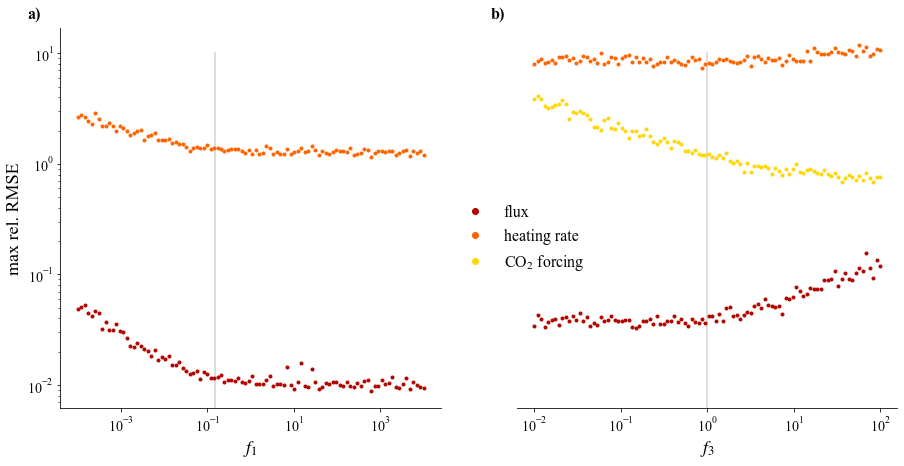

In [37]:
### Fig. 1

colors_cost = cc.fire
color_scheme_cost = np.array(colors_cost)[np.arange(30, len(colors_cost), len(colors_cost)/4, dtype = int)]

param_fit = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/param_fitting_results_nan.h5', engine = "netcdf4")
param_fit_fhf = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/param_fitting_results_nan.h5', engine = "netcdf4")

fig, axes = plt.subplots(1, 2, figsize = (15, 7), sharey = 'row')
F_rms_fh_mean = np.nanmean(param_fit.F_rms_fh.max(axis = -1), axis = -1)
H_rms_fh_mean = np.nanmean(param_fit.H_rms_fh.max(axis = -1), axis = -1)
axes[0].loglog(0.15*np.ones(50), np.linspace(0, 10), color = 'lightgrey', label = '_nolegend_')

for f1_idx in range(len(param_fit.range_f1)):
    axes[0].loglog(param_fit.range_f2_fh, F_rms_fh_mean[f1_idx, :], '.', color = color_scheme_cost[1])
    axes[0].loglog(param_fit.range_f2_fh, H_rms_fh_mean[f1_idx, :], '.', color = color_scheme_cost[2])
    
F_rms_fhf_mean = np.nanmean(param_fit_fhf.F_rms_fhf.max(axis = -1), axis = -1)
H_rms_fhf_mean = np.nanmean(param_fit_fhf.H_rms_fhf.max(axis = -1), axis = -1)
Force_rms_fhf_mean = np.nanmean(param_fit_fhf.Force_rms_fhf, axis = -1)
axes[1].loglog(np.ones(50), np.linspace(0, 10), color = 'lightgrey', label = '_nolegend_')

for f2_idx in range(len(param_fit.range_f1)):
    axes[1].loglog(param_fit_fhf.range_f3, F_rms_fhf_mean[f1_idx, 0, :], '.', color = color_scheme_cost[1], label = 'flux')
    axes[1].loglog(param_fit_fhf.range_f3, H_rms_fhf_mean[f1_idx, 0, :], '.', color = color_scheme_cost[2], label = 'heating rate')
    axes[1].loglog(param_fit_fhf.range_f3, Force_rms_fhf_mean[f1_idx, 0, :], '.', color = color_scheme_cost[3], label = 'CO$_2$ forcing')

sns.despine()
sns.despine(ax = axes[1], left = True)

axes[0].set_xlabel("$f_1$", fontsize = label_fontsize)
axes[0].set_ylabel("max rel. RMSE", fontsize = label_fontsize)
#axes[0].legend(['flux', 'heating rate'], fontsize = legend_fontsize, frameon = False)
axes[0].tick_params(axis = 'both', labelsize = tick_fontsize)

axes[1].set_xlabel("$f_3$", fontsize = label_fontsize)
#axes[1].legend(['flux', 'heating rate', 'CO$_2$ forcing'], fontsize = legend_fontsize, frameon = False)
axes[1].tick_params(axis = 'both', labelsize = tick_fontsize)
fig.legend(loc = (0.50, 0.40), frameon = False, prop={'size': legend_fontsize}, markerscale = 2)

axes[1].yaxis.set_visible(False)
axes[1].tick_params(axis='x', which='minor', bottom=False)

fig.text(0.1, 0.9, 'a)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')
fig.text(0.53, 0.9, 'b)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')

plt.savefig("param_fitting.pdf", bbox_inches='tight', dpi=600)
plt.show()

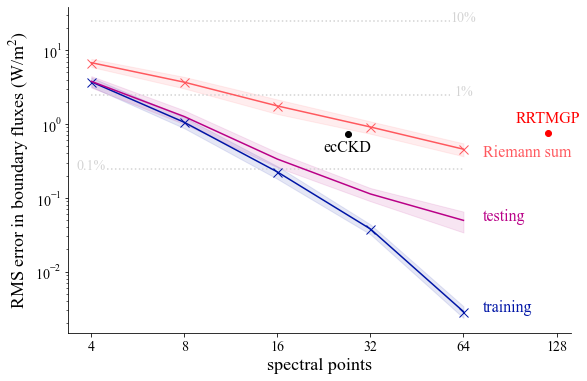

In [141]:
### Fig. 2
## ams

fig = plt.figure(figsize = (9, 6))
plt.loglog(np.linspace(4, 58, len(subset_sizes)), 0.1*np.abs(np.mean([up_TOA_eval1, dn_BOA_eval1]))*np.ones(len(subset_sizes)), color = 'lightgrey', linestyle = 'dotted')
plt.text(64, 0.1*np.abs(np.mean([up_TOA_eval1, dn_BOA_eval1])), '10%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

plt.loglog(np.linspace(4, 58, len(subset_sizes)), 0.01*np.abs(np.mean([up_TOA_eval1, dn_BOA_eval1]))*np.ones(len(subset_sizes)), color = 'lightgrey', linestyle = 'dotted')
plt.text(64, 0.01*np.abs(np.mean([up_TOA_eval1, dn_BOA_eval1])), '1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

plt.loglog(np.linspace(4.5, 64, len(subset_sizes)), 0.001*np.abs(np.mean([up_TOA_eval1, dn_BOA_eval1]))*np.ones(len(subset_sizes)), color = 'lightgrey', linestyle = 'dotted')
plt.text(4, 0.001*np.abs(np.mean([up_TOA_eval1, dn_BOA_eval1])), '0.1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

ecckd_eval1_outgoing_arms = abs_rms(np.array([ecckd_up_TOA, ecckd_dn_BOA]), np.array([up_TOA_eval1, dn_BOA_eval1]))
rrtmgp_eval1_outgoing_arms = abs_rms(np.array([rrtmgp_up_TOA, rrtmgp_dn_BOA]), np.array([up_TOA_eval1, dn_BOA_eval1]))
train_outgoing_arms = np.mean([up_TOA_train_mean_outgoing_arms, dn_BOA_train_mean_outgoing_arms], axis = 0)
test_outgoing_arms = np.mean([up_TOA_test_mean_outgoing_arms, dn_BOA_test_mean_outgoing_arms], axis = 0)
train_outgoing_std_arms = np.mean([up_TOA_train_std_outgoing_arms, dn_BOA_train_std_outgoing_arms], axis = 0)
test_outgoing_std_arms = np.mean([up_TOA_test_std_outgoing_arms, dn_BOA_test_std_outgoing_arms], axis = 0)

train_riemann_arms = np.mean([up_TOA_train_mean_riemann_arms, dn_BOA_train_mean_riemann_arms], axis = 0)
test_riemann_arms = np.mean([up_TOA_test_mean_riemann_arms, dn_BOA_test_mean_riemann_arms], axis = 0)
train_riemann_std_arms = np.mean([up_TOA_train_std_riemann_arms, dn_BOA_train_std_riemann_arms], axis = 0)
test_riemann_std_arms = np.mean([up_TOA_test_std_riemann_arms, dn_BOA_test_std_riemann_arms], axis = 0)

plt.loglog(subset_sizes, train_outgoing_arms, color = color_scheme_2pair[0], marker = 'x', markersize = marker_fontsize)
plt.loglog(subset_sizes, test_outgoing_arms, color = color_scheme_2pair[1])
plt.fill_between(subset_sizes, train_outgoing_arms - train_outgoing_std_arms, train_outgoing_arms + train_outgoing_std_arms, alpha = 0.1, color = color_scheme_2pair[0])
plt.fill_between(subset_sizes, test_outgoing_arms - test_outgoing_std_arms, test_outgoing_arms + test_outgoing_std_arms, alpha = 0.1, color = color_scheme_2pair[1])

plt.loglog(subset_sizes, train_riemann_arms, color = color_scheme_2pair[2], marker = 'x', markersize = marker_fontsize)
#plt.loglog(subset_sizes, test_riemann_arms, color = color_scheme_2pair[3])
plt.fill_between(subset_sizes, train_riemann_arms - train_riemann_std_arms, train_riemann_arms + train_riemann_std_arms, alpha = 0.1, color = color_scheme_2pair[2])
#plt.fill_between(subset_sizes, test_riemann_arms - test_riemann_std_arms, test_riemann_arms + test_riemann_std_arms, alpha = 0.1, color = color_scheme_2pair[3])

plt.loglog(27, np.mean(ecckd_eval1_outgoing_arms), '.', color = 'black', markersize = marker_fontsize + 3)
plt.loglog(120, np.mean(rrtmgp_eval1_outgoing_arms), '.', color = 'red', markersize = marker_fontsize + 3)

plt.xticks(ticks = np.array([4, 8, 16, 32, 64, 128]), labels = np.array([4, 8, 16, 32, 64, 128]), fontsize = tick_fontsize)
plt.tick_params(axis='x', which='minor', bottom=False)
plt.yticks(fontsize = tick_fontsize)

plt.text(subset_sizes[-1] + 10, train_outgoing_arms[-1] - 0.0000009, 'training', color = color_scheme_2pair[0], horizontalalignment = 'left', fontsize = legend_fontsize)
plt.text(subset_sizes[-1] + 10, test_outgoing_arms[-1] - 0.00005, 'testing', color = color_scheme_2pair[1], horizontalalignment = 'left', fontsize = legend_fontsize)
plt.text(27, np.mean(ecckd_eval1_outgoing_arms) - 0.3, 'ecCKD', color = 'black', fontsize = 16, horizontalalignment = 'center')
plt.text(120, np.mean(rrtmgp_eval1_outgoing_arms) + 0.3, 'RRTMGP', color = 'red', fontsize = 16, horizontalalignment = 'center')
plt.text(subset_sizes[-1] + 10, train_riemann_arms[-1] - 0.09, 'Riemann sum', color = color_scheme_2pair[2], horizontalalignment = 'left', fontsize = legend_fontsize)
#plt.text(subset_sizes[-1] + 10, test_outgoing_arms_riemann[-1] - 0.00005, 'testing', color = color_scheme_2pair[1], horizontalalignment = 'left', fontsize = legend_fontsize)

#plt.text(82, 0.0000052, '//', color = 'black', horizontalalignment = 'left', fontsize = tick_fontsize)
sns.despine()

plt.xlabel("spectral points", fontsize = label_fontsize)
plt.ylabel("RMS error in boundary fluxes (W/m$^2$)", fontsize = label_fontsize)
plt.savefig('outgoing_fluxes.pdf', bbox_inches='tight', dpi=600)
plt.show()

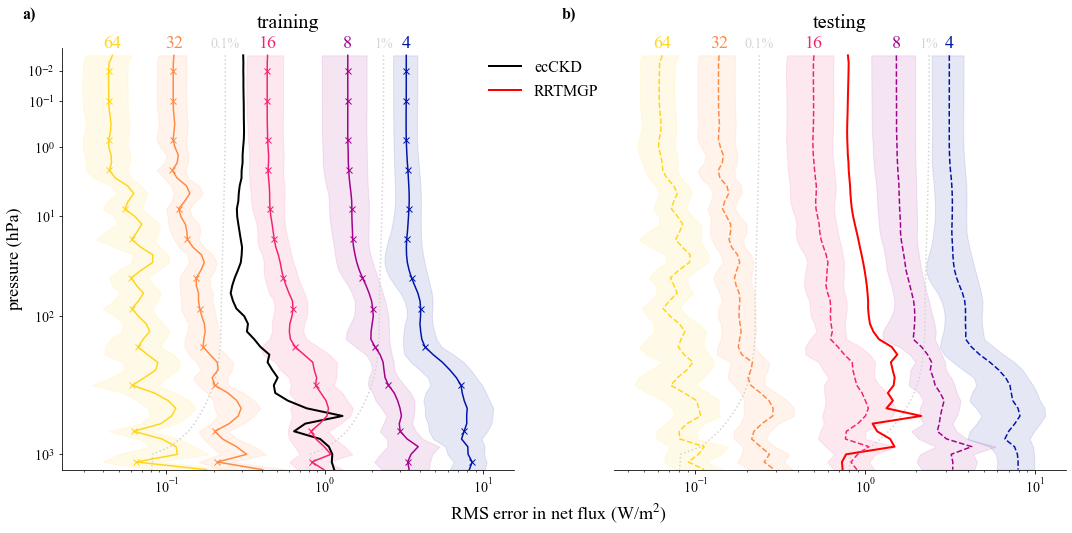

In [145]:
### Fig 3
    
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# 10% and 1% error line 
axes[0].plot(0.01*np.abs(np.mean(eval1_net_all, axis = 0)), np.arange(55), color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[0].text(0.01*np.abs(np.mean(eval1_net_all, axis = 0))[0], -1, '1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

axes[0].plot(0.001*np.abs(np.mean(eval1_net_all, axis = 0)), np.arange(55), color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[0].text(0.001*np.abs(np.mean(eval1_net_all, axis = 0))[0], -1, '0.1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

axes[1].plot(0.01*np.abs(np.mean(eval2_net_all, axis = 0)), np.arange(55), color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[1].text(0.01*np.abs(np.mean(eval2_net_all, axis = 0))[0], -1, '1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

axes[1].plot(0.001*np.abs(np.mean(eval2_net_all, axis = 0)), np.arange(55), color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[1].text(0.001*np.abs(np.mean(eval2_net_all, axis = 0))[0], -1, '0.1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

# ecckd and rrtmgp
axes[0].semilogx(ecckd_flux_arms_all, np.arange(55), color = 'black', label = 'ecCKD', linewidth = 2)
#axes[0].semilogx(rrtmgp_flux_arms_all, np.arange(55), color = 'red', label = '_nolegend_', linewidth = 2, alpha = 0.1)
#axes[1].semilogx(ecckd_flux_arms_all, np.arange(55), color = 'black', label = '_nolegend_', linewidth = 2, alpha = 0.1)
axes[1].semilogx(rrtmgp_flux_arms_all, np.arange(55), color = 'red', label = 'RRTMGP', linewidth = 2)
fig.legend(loc = (0.45, 0.8), frameon = False, prop={'size': legend_fontsize})
#axes[0].legend(np.array(['ecCKD']), fontsize = legend_fontsize, frameon = False)
#axes[1].legend(np.array(['RRTMGP']), fontsize = legend_fontsize, frameon = False)

# my results
for i in range(len(subset_sizes)):
    axes[0].semilogx(flux_train_arms_mean_all_fh[i, :], np.arange(55), color = color_scheme_5[i])
    axes[0].semilogx(flux_train_arms_mean_all_fh[i, level_array], level_array, 'x', color = color_scheme_5[i], label = '_nolegend_')

    axes[0].set_ylim(54, -1)
    axes[0].text(flux_train_arms_mean_all_fh[i, 0], -1, str(subset_sizes[i]), color = color_scheme_5[i], horizontalalignment = 'center', fontsize = text_fontsize)
    axes[0].fill_betweenx(np.arange(55), flux_train_arms_mean_all_fh[i, :] - flux_train_arms_std_all_fh[i, :], flux_train_arms_mean_all_fh[i, :] + flux_train_arms_std_all_fh[i, :],
                         alpha = 0.1, color = color_scheme_5[i])
    axes[1].set_ylim(54, -1)

    axes[1].semilogx(flux_test_arms_mean_all_fh[i, :], np.arange(55), '--', color = color_scheme_5[i])
    axes[1].text(flux_test_arms_mean_all_fh[i, 0], -1, str(subset_sizes[i]), color = color_scheme_5[i], horizontalalignment = 'center', fontsize = text_fontsize)
    axes[1].fill_betweenx(np.arange(55), flux_test_arms_mean_all_fh[i, :] - flux_test_arms_std_all_fh[i, :], flux_test_arms_mean_all_fh[i, :] + flux_test_arms_std_all_fh[i, :],
                         alpha = 0.1, color = color_scheme_5[i])
    

# figure properties
sns.despine()
sns.despine(ax = axes[1], left = True)
axes[0].set_ylabel("pressure (hPa)", fontsize = label_fontsize)
fig.text(0.52, -0.025, 'RMS error in net flux (W/m$^2$)', ha='center', fontsize = label_fontsize)
axes[0].set_title("training", fontsize = title_fontsize, pad = 20)
axes[1].set_title("testing", fontsize = title_fontsize, pad = 20)
axes[1].yaxis.set_visible(False)
axes[0].set_yticks(np.array([2, 6, 12, 21, 34, 52]))
axes[0].set_yticklabels(np.array(['10$^{-2}$', '10$^{-1}$', '10$^{0}$', '10$^{1}$', '10$^{2}$', '10$^{3}$']))

#axes[1].set_yticks(np.array([2, 6, 12, 21, 34, 52]))
#axes[1].set_yticklabels(np.array(['10$^{-2}$', '10$^{-1}$', '10$^{0}$', '10$^{1}$', '10$^{2}$', '10$^{3}$']))
axes[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)

fig.text(0.03, 0.97, 'a)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')
fig.text(0.53, 0.97, 'b)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')

#fig.tight_layout(pad=5.0)
fig.tight_layout(w_pad = 10)
plt.savefig('flux_profiles.pdf', bbox_inches='tight', dpi=600)
plt.show()


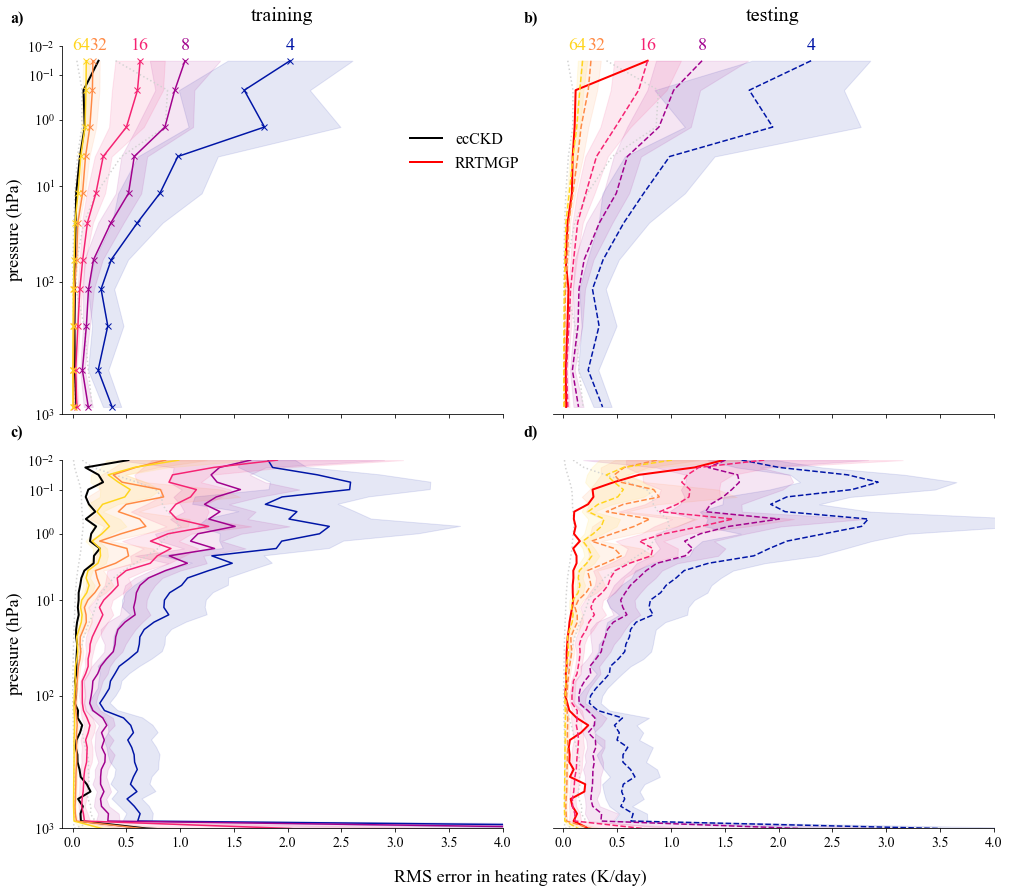

In [147]:
### Fig 4
#rms
    
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharey = 'all', sharex = 'all')

# my results
#axes[0].semilogy(np.zeros(len(eval1_pressure[0, 1:]/100)),  eval1_pressure[0, 1:]/100, color = 'lightgrey')
#axes[1].semilogy(np.zeros(len(eval1_pressure[0, 1:]/100)),  eval2_pressure[0, 1:]/100, color = 'lightgrey')

hr_level_array = np.array([4, 8, 13, 17, 22, 26, 31, 35, 40, 46, 51])

# 10% and 1% error line 
axes[0, 0].plot(0.1*np.abs(np.mean(train_heating_ref, axis = 0)), hr_level_array, color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[0, 0].plot(0.01*np.abs(np.mean(train_heating_ref, axis = 0)), hr_level_array, color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[0, 1].plot(0.1*np.abs(np.mean(train_heating_ref, axis = 0)), hr_level_array, color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[0, 1].plot(0.01*np.abs(np.mean(train_heating_ref, axis = 0)), hr_level_array, color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[1, 0].plot(0.1*np.abs(np.mean(train_heating_ref_all, axis = 0))[2:], np.arange(2, 54), color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[1, 0].plot(0.01*np.abs(np.mean(train_heating_ref_all, axis = 0))[2:], np.arange(2, 54), color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[1, 1].plot(0.1*np.abs(np.mean(train_heating_ref_all, axis = 0))[2:], np.arange(2, 54), color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[1, 1].plot(0.01*np.abs(np.mean(train_heating_ref_all, axis = 0))[2:], np.arange(2, 54), color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')

# ecckd and rrtmgp
axes[1, 0].plot(ecckd_heating_error_all[2:], np.arange(2, 54), color = 'black', label = 'ecCKD', linewidth = 2)
axes[0, 0].plot(ecckd_heating_error, hr_level_array, color = 'black', label = '_nolegend_', linewidth = 2)

#axes[0].semilogy(rrtmgp_heating_error,  eval1_pressure[0, 1:]/100, color = 'red', label = '_nolegend_', linewidth = 2, alpha = 0.1)

#axes[1].semilogy(ecckd_heating_error, eval1_pressure[0, 1:]/100, color = 'black', label = '_nolegend_', linewidth = 2, alpha = 0.1)
axes[0, 1].plot(rrtmgp_heating_error,  hr_level_array, color = 'red', label = '_nolegend_', linewidth = 2)
axes[1, 1].plot(rrtmgp_heating_error_all[2:],  np.arange(2, 54), color = 'red', label = 'RRTMGP', linewidth = 2)

#axes[1].semilogy(ecckd_heating_error, eval1_pressure[0, 1:]/100, color = 'black', label = 'ecckd 27', linewidth = 2)
#axes[1].semilogy(rrtmgp_heating_error,  eval1_pressure[0, 1:]/100, color = 'red', label = 'rrtmgp 256', linewidth = 2)
fig.legend(loc = (0.4, 0.8), frameon = False, prop={'size': legend_fontsize})

for i in range(len(subset_sizes)):

    axes[1, 0].plot(hr_arms_error_train_mean_fh_all[i, 2:], np.arange(2, 54), color = color_scheme_5[i])

    axes[1, 0].fill_betweenx(np.arange(2, 54), hr_arms_error_train_mean_fh_all[i, 2:] - hr_arms_error_train_std_fh_all[i, 2:], hr_arms_error_train_mean_fh_all[i, 2:] + hr_arms_error_train_std_fh_all[i, 2:], 
    alpha=0.1, color = color_scheme_5[i], label = "_nolegend_")
    axes[1, 0].set_ylim(53, 2)

    axes[1, 1].plot(hr_arms_error_test_mean_fh_all[i, 2:], np.arange(2, 54), '--', color = color_scheme_5[i])
    axes[1, 1].fill_betweenx(np.arange(2, 54), hr_arms_error_test_mean_fh_all[i, 2:] - hr_arms_error_test_std_fh_all[i, 2:], hr_arms_error_test_mean_fh_all[i, 2:] + hr_arms_error_test_std_fh_all[i, 2:],
    alpha=0.1, color = color_scheme_5[i])
    
    axes[0, 0].plot(hr_arms_error_train_mean_fh[i, :], hr_level_array, color = color_scheme_5[i])
    axes[0, 0].plot(hr_arms_error_train_mean_fh[i, :], hr_level_array, 'x', color = color_scheme_5[i])

    axes[0, 0].fill_betweenx(hr_level_array, hr_arms_error_train_mean_fh[i, :] - hr_arms_error_train_std_fh[i, :], hr_arms_error_train_mean_fh[i, :] + hr_arms_error_train_std_fh[i, :], 
    alpha=0.1, color = color_scheme_5[i], label = "_nolegend_")
    axes[0, 0].set_ylim(52, 2)

    axes[0, 1].plot(hr_arms_error_test_mean_fh[i, :], hr_level_array, '--', color = color_scheme_5[i])
    axes[0, 1].fill_betweenx(hr_level_array, hr_arms_error_test_mean_fh[i, :] - hr_arms_error_test_std_fh[i, :], hr_arms_error_test_mean_fh[i, :] + hr_arms_error_test_std_fh[i, :],
    alpha=0.1, color = color_scheme_5[i])
    
    if subset_sizes[i] == 64:
        axes[0, 0].text(hr_arms_error_train_mean_fh[i, 0] - 0.05, 2.5, str(subset_sizes[i]), color = color_scheme_5[i], horizontalalignment = 'center', fontsize = text_fontsize)
        axes[0, 1].text(hr_arms_error_test_mean_fh[i, 0] - 0.05, 2.5, str(subset_sizes[i]), color = color_scheme_5[i], horizontalalignment = 'center', fontsize = text_fontsize)
    
    elif subset_sizes[i] == 32:
        axes[0, 0].text(hr_arms_error_train_mean_fh[i, 0] + 0.05, 2.5, str(subset_sizes[i]), color = color_scheme_5[i], horizontalalignment = 'center', fontsize = text_fontsize)
        axes[0, 1].text(hr_arms_error_test_mean_fh[i, 0] + 0.05, 2.5, str(subset_sizes[i]), color = color_scheme_5[i], horizontalalignment = 'center', fontsize = text_fontsize)
    
    elif subset_sizes[i] == 16:
        axes[0, 0].text(hr_arms_error_train_mean_fh[i, 0], 2.5, str(subset_sizes[i]), color = color_scheme_5[i], horizontalalignment = 'center', fontsize = text_fontsize)
        axes[0, 1].text(hr_arms_error_test_mean_fh[i, 0], 2.5, str(subset_sizes[i]), color = color_scheme_5[i], horizontalalignment = 'center', fontsize = text_fontsize)
    
    elif subset_sizes[i] == 4:
        axes[0, 0].text(hr_arms_error_train_mean_fh[i, 0], 2.5, str(subset_sizes[i]), color = color_scheme_5[i], horizontalalignment = 'center', fontsize = text_fontsize)
        axes[0, 1].text(hr_arms_error_test_mean_fh[i, 0], 2.5, str(subset_sizes[i]), color = color_scheme_5[i], horizontalalignment = 'center', fontsize = text_fontsize)

    else:
        axes[0, 0].text(hr_arms_error_train_mean_fh[i, 0], 2.5, str(subset_sizes[i]), color = color_scheme_5[i], horizontalalignment = 'center', fontsize = text_fontsize)
        axes[0, 1].text(hr_arms_error_test_mean_fh[i, 0], 2.5, str(subset_sizes[i]), color = color_scheme_5[i], horizontalalignment = 'center', fontsize = text_fontsize)



# figure properties
sns.despine()
sns.despine(ax = axes[0, 1], left = True)
sns.despine(ax = axes[1, 1], left = True)

axes[1, 0].set_ylabel("pressure (hPa)", fontsize = label_fontsize)
axes[1, 0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[1, 1].tick_params(axis='x', which='major', labelsize=tick_fontsize)
axes[1, 1].yaxis.set_visible(False)
#axes[0].set_xlim([-0.1, 10])
#axes[1].set_xlim([-0.1, 10])
#axes[1, 0].set_xscale('log')
#axes[1, 1].set_xscale('log')
axes[1, 0].set_yticks(np.array([2, 6, 12, 21, 34, 52]))
axes[1, 0].set_yticklabels(np.array(['10$^{-2}$', '10$^{-1}$', '10$^{0}$', '10$^{1}$', '10$^{2}$', '10$^{3}$']))

axes[0, 0].set_ylabel("pressure (hPa)", fontsize = label_fontsize)
fig.text(0.52, -0.025, 'RMS error in heating rates (K/day)', ha='center', fontsize = text_fontsize)
axes[0, 0].set_title("training", fontsize = title_fontsize, pad = 25)
axes[0, 1].set_title("testing", fontsize = title_fontsize, pad = 25)
axes[0, 0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[0, 1].tick_params(axis='x', which='major', labelsize=tick_fontsize)
axes[0, 1].yaxis.set_visible(False)
#axes[0].set_xlim([-0.1, 10])
#axes[1].set_xlim([-0.1, 10])
#axes[0, 0].set_xscale('log')
#axes[0, 1].set_xscale('log')
axes[0, 0].set_yticks(np.array([2,6, 12, 21, 34, 52]))
axes[0, 0].set_yticklabels(np.array(['10$^{-2}$', '10$^{-1}$', '10$^{0}$', '10$^{1}$', '10$^{2}$', '10$^{3}$']))

fig.text(0.02, 0.97, 'a)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')
fig.text(0.53, 0.97, 'b)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')

fig.text(0.02, 0.49, 'c)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')
fig.text(0.53, 0.49, 'd)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')

fig.tight_layout(w_pad=5.0, h_pad = 3.0)


axes[0, 0].set_xlim([-0.1, 4])

plt.savefig('heating_profiles.pdf', bbox_inches='tight', dpi=600)


plt.show()


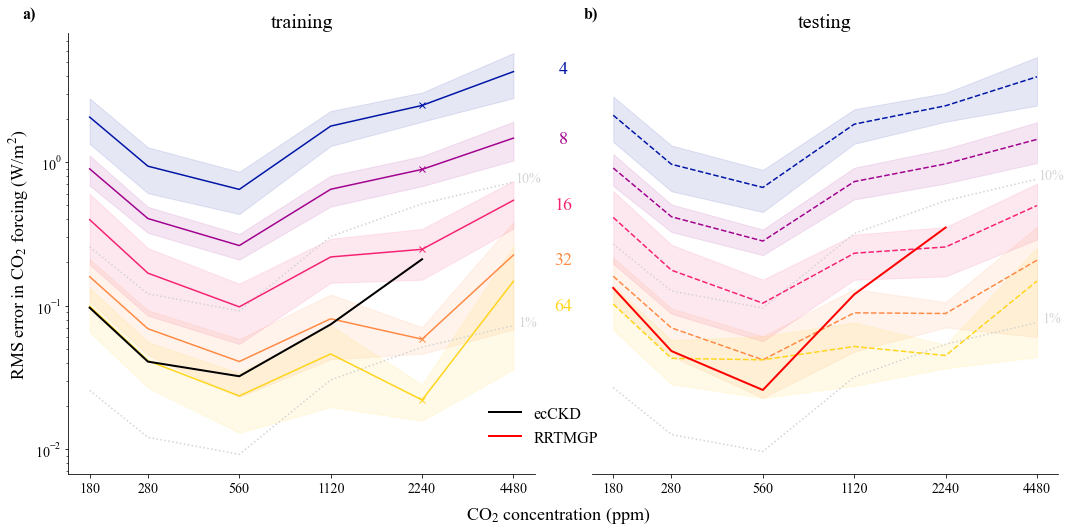

In [172]:
CO2_concs = np.array([180, 280, 560, 1120, 2240, 4480])

forcing_4_train_mean_arms = np.array([CO2_train_mean_180_forcing_arms[0], CO2_train_mean_280_forcing_arms[0], CO2_train_mean_560_forcing_arms[0], CO2_train_mean_1120_forcing_arms[0], CO2_train_mean_2240_forcing_arms[0], CO2_train_mean_4480_forcing_arms[0]])
forcing_4_train_std_arms = np.array([CO2_train_std_180_forcing_arms[0], CO2_train_std_280_forcing_arms[0], CO2_train_std_560_forcing_arms[0], CO2_train_std_1120_forcing_arms[0], CO2_train_std_2240_forcing_arms[0], CO2_train_std_4480_forcing_arms[0]])

forcing_4_test_mean_arms = np.array([CO2_test_mean_180_forcing_arms[0], CO2_test_mean_280_forcing_arms[0], CO2_test_mean_560_forcing_arms[0], CO2_test_mean_1120_forcing_arms[0], CO2_test_mean_2240_forcing_arms[0], CO2_test_mean_4480_forcing_arms[0]])
forcing_4_test_std_arms = np.array([CO2_test_std_180_forcing_arms[0], CO2_test_std_280_forcing_arms[0], CO2_test_std_560_forcing_arms[0], CO2_test_std_1120_forcing_arms[0], CO2_test_std_2240_forcing_arms[0], CO2_test_std_4480_forcing_arms[0]])

forcing_8_train_mean_arms = np.array([CO2_train_mean_180_forcing_arms[1], CO2_train_mean_280_forcing_arms[1], CO2_train_mean_560_forcing_arms[1], CO2_train_mean_1120_forcing_arms[1], CO2_train_mean_2240_forcing_arms[1], CO2_train_mean_4480_forcing_arms[1]])
forcing_8_train_std_arms = np.array([CO2_train_std_180_forcing_arms[1], CO2_train_std_280_forcing_arms[1], CO2_train_std_560_forcing_arms[1], CO2_train_std_1120_forcing_arms[1], CO2_train_std_2240_forcing_arms[1], CO2_train_std_4480_forcing_arms[1]])

forcing_8_test_mean_arms = np.array([CO2_test_mean_180_forcing_arms[1], CO2_test_mean_280_forcing_arms[1], CO2_test_mean_560_forcing_arms[1], CO2_test_mean_1120_forcing_arms[1], CO2_test_mean_2240_forcing_arms[1], CO2_test_mean_4480_forcing_arms[1]])
forcing_8_test_std_arms = np.array([CO2_test_std_180_forcing_arms[1], CO2_test_std_280_forcing_arms[1], CO2_test_std_560_forcing_arms[1], CO2_test_std_1120_forcing_arms[1], CO2_test_std_2240_forcing_arms[1], CO2_test_std_4480_forcing_arms[1]])

forcing_16_train_mean_arms = np.array([CO2_train_mean_180_forcing_arms[2], CO2_train_mean_280_forcing_arms[2], CO2_train_mean_560_forcing_arms[2], CO2_train_mean_1120_forcing_arms[2], CO2_train_mean_2240_forcing_arms[2], CO2_train_mean_4480_forcing_arms[2]])
forcing_16_train_std_arms = np.array([CO2_train_std_180_forcing_arms[2], CO2_train_std_280_forcing_arms[2], CO2_train_std_560_forcing_arms[2], CO2_train_std_1120_forcing_arms[2], CO2_train_std_2240_forcing_arms[2], CO2_train_std_4480_forcing_arms[2]])

forcing_16_test_mean_arms = np.array([CO2_test_mean_180_forcing_arms[2], CO2_test_mean_280_forcing_arms[2], CO2_test_mean_560_forcing_arms[2], CO2_test_mean_1120_forcing_arms[2], CO2_test_mean_2240_forcing_arms[2], CO2_test_mean_4480_forcing_arms[2]])
forcing_16_test_std_arms = np.array([CO2_test_std_180_forcing_arms[2], CO2_test_std_280_forcing_arms[2], CO2_test_std_560_forcing_arms[2], CO2_test_std_1120_forcing_arms[2], CO2_test_std_2240_forcing_arms[2], CO2_test_std_4480_forcing_arms[2]])

forcing_32_train_mean_arms = np.array([CO2_train_mean_180_forcing_arms[3], CO2_train_mean_280_forcing_arms[3], CO2_train_mean_560_forcing_arms[3], CO2_train_mean_1120_forcing_arms[3], CO2_train_mean_2240_forcing_arms[3], CO2_train_mean_4480_forcing_arms[3]])
forcing_32_train_std_arms = np.array([CO2_train_std_180_forcing_arms[3], CO2_train_std_280_forcing_arms[3], CO2_train_std_560_forcing_arms[3], CO2_train_std_1120_forcing_arms[3], CO2_train_std_2240_forcing_arms[3], CO2_train_std_4480_forcing_arms[3]])

forcing_32_test_mean_arms = np.array([CO2_test_mean_180_forcing_arms[3], CO2_test_mean_280_forcing_arms[3], CO2_test_mean_560_forcing_arms[3], CO2_test_mean_1120_forcing_arms[3], CO2_test_mean_2240_forcing_arms[3], CO2_test_mean_4480_forcing_arms[3]])
forcing_32_test_std_arms = np.array([CO2_test_std_180_forcing_arms[3], CO2_test_std_280_forcing_arms[3], CO2_test_std_560_forcing_arms[3], CO2_test_std_1120_forcing_arms[3], CO2_test_std_2240_forcing_arms[3], CO2_test_std_4480_forcing_arms[3]])

forcing_64_train_mean_arms = np.array([CO2_train_mean_180_forcing_arms[4], CO2_train_mean_280_forcing_arms[4], CO2_train_mean_560_forcing_arms[4], CO2_train_mean_1120_forcing_arms[4], CO2_train_mean_2240_forcing_arms[4], CO2_train_mean_4480_forcing_arms[4]])
forcing_64_train_std_arms = np.array([CO2_train_std_180_forcing_arms[4], CO2_train_std_280_forcing_arms[4], CO2_train_std_560_forcing_arms[4], CO2_train_std_1120_forcing_arms[4], CO2_train_std_2240_forcing_arms[4], CO2_train_std_4480_forcing_arms[4]])

forcing_64_test_mean_arms = np.array([CO2_test_mean_180_forcing_arms[4], CO2_test_mean_280_forcing_arms[4], CO2_test_mean_560_forcing_arms[3], CO2_test_mean_1120_forcing_arms[4], CO2_test_mean_2240_forcing_arms[4], CO2_test_mean_4480_forcing_arms[4]])
forcing_64_test_std_arms = np.array([CO2_test_std_180_forcing_arms[4], CO2_test_std_280_forcing_arms[4], CO2_test_std_560_forcing_arms[3], CO2_test_std_1120_forcing_arms[4], CO2_test_std_2240_forcing_arms[4], CO2_test_std_4480_forcing_arms[4]])

### Fig 5

fig, axes = plt.subplots(1, 2, figsize = (15, 7), sharex = 'all', sharey = 'all')
# plot the 10% line:
axes[0].loglog(CO2_concs,  np.abs(0.1*np.array([eval1_180_forcing_ref.mean(), eval1_280_forcing_ref.mean(), eval1_560_forcing_ref.mean(), eval1_1120_forcing_ref.mean(), eval1_2240_forcing_ref.mean(), eval1_4480_forcing_ref.mean()])), color = 'lightgrey', linestyle = 'dotted')
axes[0].text(5000, np.abs(0.1*np.array([eval1_180_forcing_ref.mean(), eval1_280_forcing_ref.mean(), eval1_560_forcing_ref.mean(), eval1_1120_forcing_ref.mean(), eval1_2240_forcing_ref.mean(), eval1_4480_forcing_ref.mean()]))[-1], '10%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)
axes[1].loglog(CO2_concs, np.abs(0.1*np.array([eval2_180_forcing_ref.mean(), eval2_280_forcing_ref.mean(), eval2_560_forcing_ref.mean(), eval2_1120_forcing_ref.mean(), eval2_2240_forcing_ref.mean(), eval2_4480_forcing_ref.mean()])), color = 'lightgrey', linestyle = 'dotted')
axes[1].text(5000, np.abs(0.1*np.array([eval2_180_forcing_ref.mean(), eval2_280_forcing_ref.mean(), eval2_560_forcing_ref.mean(), eval2_1120_forcing_ref.mean(), eval2_2240_forcing_ref.mean(), eval2_4480_forcing_ref.mean()]))[-1], '10%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

axes[0].loglog(CO2_concs,  np.abs(0.01*np.array([eval1_180_forcing_ref.mean(), eval1_280_forcing_ref.mean(), eval1_560_forcing_ref.mean(), eval1_1120_forcing_ref.mean(), eval1_2240_forcing_ref.mean(), eval1_4480_forcing_ref.mean()])), color = 'lightgrey', linestyle = 'dotted')
axes[0].text(5000, np.abs(0.01*np.array([eval1_180_forcing_ref.mean(), eval1_280_forcing_ref.mean(), eval1_560_forcing_ref.mean(), eval1_1120_forcing_ref.mean(), eval1_2240_forcing_ref.mean(), eval1_4480_forcing_ref.mean()]))[-1], '1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

axes[1].loglog(CO2_concs, np.abs(0.01*np.array([eval2_180_forcing_ref.mean(), eval2_280_forcing_ref.mean(), eval2_560_forcing_ref.mean(), eval2_1120_forcing_ref.mean(), eval2_2240_forcing_ref.mean(), eval2_4480_forcing_ref.mean()])), color = 'lightgrey', linestyle = 'dotted')
axes[1].text(5000, np.abs(0.01*np.array([eval2_180_forcing_ref.mean(), eval2_280_forcing_ref.mean(), eval2_560_forcing_ref.mean(), eval2_1120_forcing_ref.mean(), eval2_2240_forcing_ref.mean(), eval2_4480_forcing_ref.mean()]))[-1], '1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

# plot results
axes[0].loglog(CO2_concs, forcing_4_train_mean_arms, color = color_scheme_5[0], label = '_nolegend_')
axes[0].loglog(CO2_concs[-2], forcing_4_train_mean_arms[-2], 'x', color = color_scheme_5[0])
#axes[0].loglog(CO2_concs[0], forcing_4_train_mean_arms[0], 'x', color = color_scheme_5[0])

axes[1].loglog(CO2_concs, forcing_4_test_mean_arms, '--', color = color_scheme_5[0], label = '_nolegend_')

axes[0].fill_between(CO2_concs, forcing_4_train_mean_arms - forcing_4_train_std_arms, forcing_4_train_mean_arms + forcing_4_train_std_arms,
alpha=0.1, color = color_scheme_5[0],  label = '_nolegend_')
axes[1].fill_between(CO2_concs, forcing_4_test_mean_arms - forcing_4_test_std_arms, forcing_4_test_mean_arms + forcing_4_test_std_arms,
alpha=0.1, color = color_scheme_5[0],  label = '_nolegend_')    


axes[0].loglog(CO2_concs, forcing_8_train_mean_arms, color = color_scheme_5[1], label = '_nolegend_')
axes[0].loglog(CO2_concs[-2], forcing_8_train_mean_arms[-2], 'x', color = color_scheme_5[1])
#axes[0].loglog(CO2_concs[0], forcing_8_train_mean_arms[0], 'x', color = color_scheme_5[1])

axes[1].loglog(CO2_concs, forcing_8_test_mean_arms, '--', color = color_scheme_5[1], label = '_nolegend_')

axes[0].fill_between(CO2_concs, forcing_8_train_mean_arms - forcing_8_train_std_arms, forcing_8_train_mean_arms + forcing_8_train_std_arms,
alpha=0.1, color = color_scheme_5[1],  label = '_nolegend_')
axes[1].fill_between(CO2_concs, forcing_8_test_mean_arms - forcing_8_test_std_arms, forcing_8_test_mean_arms + forcing_8_test_std_arms,
alpha=0.1, color = color_scheme_5[1],  label = '_nolegend_')    

axes[0].loglog(CO2_concs, forcing_16_train_mean_arms, color = color_scheme_5[2], label = '_nolegend_')
axes[0].loglog(CO2_concs[-2], forcing_16_train_mean_arms[-2], 'x', color = color_scheme_5[2])
#axes[0].loglog(CO2_concs[0], forcing_16_train_mean_arms[0], 'x', color = color_scheme_5[2])

axes[1].loglog(CO2_concs, forcing_16_test_mean_arms, '--', color = color_scheme_5[2], label = '_nolegend_')

axes[0].fill_between(CO2_concs, forcing_16_train_mean_arms - forcing_16_train_std_arms, forcing_16_train_mean_arms + forcing_16_train_std_arms,
alpha=0.1, color = color_scheme_5[2],  label = '_nolegend_')
axes[1].fill_between(CO2_concs, forcing_16_test_mean_arms - forcing_16_test_std_arms, forcing_16_test_mean_arms + forcing_16_test_std_arms,
alpha=0.1, color = color_scheme_5[2],  label = '_nolegend_')    


#axes[0, 0].loglog(np.array([180, 280, 1120, 2240]), rrtmgp_forcing_armse, color = 'red')
#axes[0, 0].loglog(np.array([180, 280, 1120, 2240]), rrtmgp_forcing_armse, 'x', color = 'red')

#axes[0, 0].loglog(CO2_concs, ecckd_forcing_armse, color = 'black')
#axes[0, 0].loglog(CO2_concs, ecckd_forcing_armse, 'x', color = 'black')

axes[0].loglog(CO2_concs, forcing_32_train_mean_arms, color = color_scheme_5[3], label = '_nolegend_')
axes[0].loglog(CO2_concs[-2], forcing_32_train_mean_arms[-2], 'x', color = color_scheme_5[3])
#axes[0].loglog(CO2_concs[0], forcing_32_train_mean_arms[0], 'x', color = color_scheme_5[3])

axes[1].loglog(CO2_concs, forcing_32_test_mean_arms, '--', color = color_scheme_5[3], label = '_nolegend_')

axes[0].fill_between(CO2_concs, forcing_32_train_mean_arms - forcing_32_train_std_arms, forcing_32_train_mean_arms + forcing_32_train_std_arms,
alpha=0.1, color = color_scheme_5[3],  label = '_nolegend_')
axes[1].fill_between(CO2_concs, forcing_32_test_mean_arms - forcing_32_test_std_arms, forcing_32_test_mean_arms + forcing_32_test_std_arms,
alpha=0.1, color = color_scheme_5[3],  label = '_nolegend_')    

axes[0].loglog(CO2_concs, forcing_64_train_mean_arms, color = color_scheme_5[4], label = '_nolegend_')
axes[0].loglog(CO2_concs[-2], forcing_64_train_mean_arms[-2], 'x', color = color_scheme_5[4])
#axes[0].loglog(CO2_concs[0], forcing_64_train_mean_arms[0], 'x', color = color_scheme_5[4])

axes[1].loglog(CO2_concs, forcing_64_test_mean_arms, '--', color = color_scheme_5[4], label = '_nolegend_')

axes[0].fill_between(CO2_concs, forcing_64_train_mean_arms - forcing_64_train_std_arms, forcing_64_train_mean_arms + forcing_64_train_std_arms,
alpha=0.1, color = color_scheme_5[4],  label = '_nolegend_')
axes[1].fill_between(CO2_concs, forcing_64_test_mean_arms - forcing_64_test_std_arms, forcing_64_test_mean_arms + forcing_64_test_std_arms,
alpha=0.1, color = color_scheme_5[4],  label = '_nolegend_')    

axes[1].loglog(CO2_concs[:-1], rrtmgp_forcing_amse, color = 'red', linewidth = 2, label = 'RRTMGP')
#axes[1].loglog(CO2_concs[:-1], ecckd_forcing_amse, color = 'black', linewidth = 2, label = '_nolegend_', alpha = 0.1)
#axes[0].loglog(CO2_concs[:-1], rrtmgp_forcing_amse, color = 'red', linewidth = 2, label = '_nolegend_', alpha = 0.1)
axes[0].loglog(CO2_concs[:-1], ecckd_forcing_amse, color = 'black', linewidth = 2, label = 'ecCKD')


fig.text(0.525, 0.86, '4', color = color_scheme_5[0], horizontalalignment = 'center', fontsize = text_fontsize)
fig.text(0.525, 0.72, '8', color = color_scheme_5[1], horizontalalignment = 'center', fontsize = text_fontsize)
fig.text(0.525, 0.59, '16', color = color_scheme_5[2], horizontalalignment = 'center', fontsize = text_fontsize)
fig.text(0.525, 0.48, '32', color = color_scheme_5[3], horizontalalignment = 'center', fontsize = text_fontsize)
fig.text(0.525, 0.39, '64', color = color_scheme_5[4], horizontalalignment = 'center', fontsize = text_fontsize)
#fig.text(0.525, 0.36, 'rrtmgp', color = 'red', horizontalalignment = 'center', fontsize = text_fontsize)
#fig.text(0.525, 0.27, 'ecckd', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

# figure properties
axes[0].set_xticks(CO2_concs)
axes[0].set_xticklabels(CO2_concs)
axes[0].tick_params(axis = 'both', labelsize = tick_fontsize)
#plt.legend(["training 32", "testing 32", "rrtmgp", "ecckd"], fontsize = legend_fontsize)
sns.despine()
sns.despine(ax = axes[1], left = True)
fig.text(0.52, -0.025, 'CO$_2$ concentration (ppm)', ha='center', fontsize = label_fontsize)
axes[0].set_ylabel("RMS error in CO$_2$ forcing (W/m$^2$)", fontsize = label_fontsize)

axes[1].set_xticks(CO2_concs)
axes[1].set_xticklabels(CO2_concs)
#axes[1].set_xticklabels(np.array(['LGM', 'PI', '2xPI', '4xPI', '8xPI', '16xPI']))

axes[1].tick_params(axis = 'x', which = 'major', labelsize = tick_fontsize)
axes[1].yaxis.set_visible(False)

axes[0].set_title("training", fontsize = title_fontsize)
axes[1].set_title("testing", fontsize = title_fontsize)

fig.legend(loc = (0.45, 0.15), frameon = False, prop={'size': legend_fontsize})

#plt.minorticks_off()
axes[0].tick_params(axis='x', which='minor', bottom=False)
axes[1].tick_params(axis='x', which='minor', bottom=False)

fig.text(0.03, 0.97, 'a)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')
fig.text(0.55, 0.97, 'b)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')
fig.tight_layout(w_pad=5.0)


plt.savefig('co2_forcing.png', bbox_inches='tight', dpi=600)

plt.show()


In [150]:
forcing_4_test_mean_regression_arms = np.array([CO2_test_mean_180_regression_arms[0], CO2_test_mean_280_regression_arms[0], CO2_test_mean_560_regression_arms[0], CO2_test_mean_1120_regression_arms[0], CO2_test_mean_2240_regression_arms[0]])
forcing_4_test_std_regression_arms = np.array([CO2_test_std_180_regression_arms[0], CO2_test_std_280_regression_arms[0], CO2_test_std_560_regression_arms[0], CO2_test_std_1120_regression_arms[0], CO2_test_std_2240_regression_arms[0]])

forcing_4_test_mean_regression_arms = np.array([CO2_test_mean_180_regression_arms[0], CO2_test_mean_280_regression_arms[0], CO2_test_mean_560_regression_arms[0], CO2_test_mean_1120_regression_arms[0], CO2_test_mean_2240_regression_arms[0]])
forcing_4_test_std_regression_arms = np.array([CO2_test_std_180_regression_arms[0], CO2_test_std_280_regression_arms[0], CO2_test_std_560_regression_arms[0], CO2_test_std_1120_regression_arms[0], CO2_test_std_2240_regression_arms[0]])

forcing_8_test_mean_regression_arms = np.array([CO2_test_mean_180_regression_arms[1], CO2_test_mean_280_regression_arms[1], CO2_test_mean_560_regression_arms[1], CO2_test_mean_1120_regression_arms[1], CO2_test_mean_2240_regression_arms[1]])
forcing_8_test_std_regression_arms = np.array([CO2_test_std_180_regression_arms[1], CO2_test_std_280_regression_arms[1], CO2_test_std_560_regression_arms[1], CO2_test_std_1120_regression_arms[1], CO2_test_std_2240_regression_arms[1]])

forcing_8_test_mean_regression_arms = np.array([CO2_test_mean_180_regression_arms[1], CO2_test_mean_280_regression_arms[1], CO2_test_mean_560_regression_arms[1], CO2_test_mean_1120_regression_arms[1], CO2_test_mean_2240_regression_arms[1]])
forcing_8_test_std_regression_arms = np.array([CO2_test_std_180_regression_arms[1], CO2_test_std_280_regression_arms[1], CO2_test_std_560_regression_arms[1], CO2_test_std_1120_regression_arms[1], CO2_test_std_2240_regression_arms[1]])

forcing_16_test_mean_regression_arms = np.array([CO2_test_mean_180_regression_arms[2], CO2_test_mean_280_regression_arms[2], CO2_test_mean_560_regression_arms[2], CO2_test_mean_1120_regression_arms[2], CO2_test_mean_2240_regression_arms[2]])
forcing_16_test_std_regression_arms = np.array([CO2_test_std_180_regression_arms[2], CO2_test_std_280_regression_arms[2], CO2_test_std_560_regression_arms[2], CO2_test_std_1120_regression_arms[2], CO2_test_std_2240_regression_arms[2]])

forcing_16_test_mean_regression_arms = np.array([CO2_test_mean_180_regression_arms[2], CO2_test_mean_280_regression_arms[2], CO2_test_mean_560_regression_arms[2], CO2_test_mean_1120_regression_arms[2], CO2_test_mean_2240_regression_arms[2]])
forcing_16_test_std_regression_arms = np.array([CO2_test_std_180_regression_arms[2], CO2_test_std_280_regression_arms[2], CO2_test_std_560_regression_arms[2], CO2_test_std_1120_regression_arms[2], CO2_test_std_2240_regression_arms[2]])

forcing_32_test_mean_regression_arms = np.array([CO2_test_mean_180_regression_arms[3], CO2_test_mean_280_regression_arms[3], CO2_test_mean_560_regression_arms[3], CO2_test_mean_1120_regression_arms[3], CO2_test_mean_2240_regression_arms[3]])
forcing_32_test_std_regression_arms = np.array([CO2_test_std_180_regression_arms[3], CO2_test_std_280_regression_arms[3], CO2_test_std_560_regression_arms[3], CO2_test_std_1120_regression_arms[3], CO2_test_std_2240_regression_arms[3]])

forcing_32_test_mean_regression_arms = np.array([CO2_test_mean_180_regression_arms[3], CO2_test_mean_280_regression_arms[3], CO2_test_mean_560_regression_arms[3], CO2_test_mean_1120_regression_arms[3], CO2_test_mean_2240_regression_arms[3]])
forcing_32_test_std_regression_arms = np.array([CO2_test_std_180_regression_arms[3], CO2_test_std_280_regression_arms[3], CO2_test_std_560_regression_arms[3], CO2_test_std_1120_regression_arms[3], CO2_test_std_2240_regression_arms[3]])

forcing_64_test_mean_regression_arms = np.array([CO2_test_mean_180_regression_arms[4], CO2_test_mean_280_regression_arms[4], CO2_test_mean_560_regression_arms[4], CO2_test_mean_1120_regression_arms[4], CO2_test_mean_2240_regression_arms[4]])
forcing_64_test_std_regression_arms = np.array([CO2_test_std_180_regression_arms[4], CO2_test_std_280_regression_arms[4], CO2_test_std_560_regression_arms[4], CO2_test_std_1120_regression_arms[4], CO2_test_std_2240_regression_arms[4]])

forcing_64_test_mean_regression_arms = np.array([CO2_test_mean_180_regression_arms[4], CO2_test_mean_280_regression_arms[4], CO2_test_mean_560_regression_arms[3], CO2_test_mean_1120_regression_arms[4], CO2_test_mean_2240_regression_arms[4]])
forcing_64_test_std_regression_arms = np.array([CO2_test_std_180_regression_arms[4], CO2_test_std_280_regression_arms[4], CO2_test_std_560_regression_arms[3], CO2_test_std_1120_regression_arms[4], CO2_test_std_2240_regression_arms[4]])

forcing_4_test_mean_fh_arms = np.array([CO2_test_mean_180_fh_arms[0], CO2_test_mean_280_fh_arms[0], CO2_test_mean_560_fh_arms[0], CO2_test_mean_1120_fh_arms[0], CO2_test_mean_2240_fh_arms[0]])
forcing_4_test_std_fh_arms = np.array([CO2_test_std_180_fh_arms[0], CO2_test_std_280_fh_arms[0], CO2_test_std_560_fh_arms[0], CO2_test_std_1120_fh_arms[0], CO2_test_std_2240_fh_arms[0]])

forcing_4_test_mean_fh_arms = np.array([CO2_test_mean_180_fh_arms[0], CO2_test_mean_280_fh_arms[0], CO2_test_mean_560_fh_arms[0], CO2_test_mean_1120_fh_arms[0], CO2_test_mean_2240_fh_arms[0]])
forcing_4_test_std_fh_arms = np.array([CO2_test_std_180_fh_arms[0], CO2_test_std_280_fh_arms[0], CO2_test_std_560_fh_arms[0], CO2_test_std_1120_fh_arms[0], CO2_test_std_2240_fh_arms[0]])

forcing_8_test_mean_fh_arms = np.array([CO2_test_mean_180_fh_arms[1], CO2_test_mean_280_fh_arms[1], CO2_test_mean_560_fh_arms[1], CO2_test_mean_1120_fh_arms[1], CO2_test_mean_2240_fh_arms[1]])
forcing_8_test_std_fh_arms = np.array([CO2_test_std_180_fh_arms[1], CO2_test_std_280_fh_arms[1], CO2_test_std_560_fh_arms[1], CO2_test_std_1120_fh_arms[1], CO2_test_std_2240_fh_arms[1]])

forcing_8_test_mean_fh_arms = np.array([CO2_test_mean_180_fh_arms[1], CO2_test_mean_280_fh_arms[1], CO2_test_mean_560_fh_arms[1], CO2_test_mean_1120_fh_arms[1], CO2_test_mean_2240_fh_arms[1]])
forcing_8_test_std_fh_arms = np.array([CO2_test_std_180_fh_arms[1], CO2_test_std_280_fh_arms[1], CO2_test_std_560_fh_arms[1], CO2_test_std_1120_fh_arms[1], CO2_test_std_2240_fh_arms[1]])

forcing_16_test_mean_fh_arms = np.array([CO2_test_mean_180_fh_arms[2], CO2_test_mean_280_fh_arms[2], CO2_test_mean_560_fh_arms[2], CO2_test_mean_1120_fh_arms[2], CO2_test_mean_2240_fh_arms[2]])
forcing_16_test_std_fh_arms = np.array([CO2_test_std_180_fh_arms[2], CO2_test_std_280_fh_arms[2], CO2_test_std_560_fh_arms[2], CO2_test_std_1120_fh_arms[2], CO2_test_std_2240_fh_arms[2]])

forcing_16_test_mean_fh_arms = np.array([CO2_test_mean_180_fh_arms[2], CO2_test_mean_280_fh_arms[2], CO2_test_mean_560_fh_arms[2], CO2_test_mean_1120_fh_arms[2], CO2_test_mean_2240_fh_arms[2]])
forcing_16_test_std_fh_arms = np.array([CO2_test_std_180_fh_arms[2], CO2_test_std_280_fh_arms[2], CO2_test_std_560_fh_arms[2], CO2_test_std_1120_fh_arms[2], CO2_test_std_2240_fh_arms[2]])

forcing_32_test_mean_fh_arms = np.array([CO2_test_mean_180_fh_arms[3], CO2_test_mean_280_fh_arms[3], CO2_test_mean_560_fh_arms[3], CO2_test_mean_1120_fh_arms[3], CO2_test_mean_2240_fh_arms[3]])
forcing_32_test_std_fh_arms = np.array([CO2_test_std_180_fh_arms[3], CO2_test_std_280_fh_arms[3], CO2_test_std_560_fh_arms[3], CO2_test_std_1120_fh_arms[3], CO2_test_std_2240_fh_arms[3]])

forcing_32_test_mean_fh_arms = np.array([CO2_test_mean_180_fh_arms[3], CO2_test_mean_280_fh_arms[3], CO2_test_mean_560_fh_arms[3], CO2_test_mean_1120_fh_arms[3], CO2_test_mean_2240_fh_arms[3]])
forcing_32_test_std_fh_arms = np.array([CO2_test_std_180_fh_arms[3], CO2_test_std_280_fh_arms[3], CO2_test_std_560_fh_arms[3], CO2_test_std_1120_fh_arms[3], CO2_test_std_2240_fh_arms[3]])

forcing_64_test_mean_fh_arms = np.array([CO2_test_mean_180_fh_arms[4], CO2_test_mean_280_fh_arms[4], CO2_test_mean_560_fh_arms[4], CO2_test_mean_1120_fh_arms[4], CO2_test_mean_2240_fh_arms[4]])
forcing_64_test_std_fh_arms = np.array([CO2_test_std_180_fh_arms[4], CO2_test_std_280_fh_arms[4], CO2_test_std_560_fh_arms[4], CO2_test_std_1120_fh_arms[4], CO2_test_std_2240_fh_arms[4]])

forcing_64_test_mean_fh_arms = np.array([CO2_test_mean_180_fh_arms[4], CO2_test_mean_280_fh_arms[4], CO2_test_mean_560_fh_arms[3], CO2_test_mean_1120_fh_arms[4], CO2_test_mean_2240_fh_arms[4]])
forcing_64_test_std_fh_arms = np.array([CO2_test_std_180_fh_arms[4], CO2_test_std_280_fh_arms[4], CO2_test_std_560_fh_arms[3], CO2_test_std_1120_fh_arms[4], CO2_test_std_2240_fh_arms[4]])

forcing_4_test_mean_outgoing_arms = np.array([CO2_test_mean_180_outgoing_arms[0], CO2_test_mean_280_outgoing_arms[0], CO2_test_mean_560_outgoing_arms[0], CO2_test_mean_1120_outgoing_arms[0], CO2_test_mean_2240_outgoing_arms[0]])
forcing_4_test_std_outgoing_arms = np.array([CO2_test_std_180_outgoing_arms[0], CO2_test_std_280_outgoing_arms[0], CO2_test_std_560_outgoing_arms[0], CO2_test_std_1120_outgoing_arms[0], CO2_test_std_2240_outgoing_arms[0]])

forcing_4_test_mean_outgoing_arms = np.array([CO2_test_mean_180_outgoing_arms[0], CO2_test_mean_280_outgoing_arms[0], CO2_test_mean_560_outgoing_arms[0], CO2_test_mean_1120_outgoing_arms[0], CO2_test_mean_2240_outgoing_arms[0]])
forcing_4_test_std_outgoing_arms = np.array([CO2_test_std_180_outgoing_arms[0], CO2_test_std_280_outgoing_arms[0], CO2_test_std_560_outgoing_arms[0], CO2_test_std_1120_outgoing_arms[0], CO2_test_std_2240_outgoing_arms[0]])

forcing_8_test_mean_outgoing_arms = np.array([CO2_test_mean_180_outgoing_arms[1], CO2_test_mean_280_outgoing_arms[1], CO2_test_mean_560_outgoing_arms[1], CO2_test_mean_1120_outgoing_arms[1], CO2_test_mean_2240_outgoing_arms[1]])
forcing_8_test_std_outgoing_arms = np.array([CO2_test_std_180_outgoing_arms[1], CO2_test_std_280_outgoing_arms[1], CO2_test_std_560_outgoing_arms[1], CO2_test_std_1120_outgoing_arms[1], CO2_test_std_2240_outgoing_arms[1]])

forcing_8_test_mean_outgoing_arms = np.array([CO2_test_mean_180_outgoing_arms[1], CO2_test_mean_280_outgoing_arms[1], CO2_test_mean_560_outgoing_arms[1], CO2_test_mean_1120_outgoing_arms[1], CO2_test_mean_2240_outgoing_arms[1]])
forcing_8_test_std_outgoing_arms = np.array([CO2_test_std_180_outgoing_arms[1], CO2_test_std_280_outgoing_arms[1], CO2_test_std_560_outgoing_arms[1], CO2_test_std_1120_outgoing_arms[1], CO2_test_std_2240_outgoing_arms[1]])

forcing_16_test_mean_outgoing_arms = np.array([CO2_test_mean_180_outgoing_arms[2], CO2_test_mean_280_outgoing_arms[2], CO2_test_mean_560_outgoing_arms[2], CO2_test_mean_1120_outgoing_arms[2], CO2_test_mean_2240_outgoing_arms[2]])
forcing_16_test_std_outgoing_arms = np.array([CO2_test_std_180_outgoing_arms[2], CO2_test_std_280_outgoing_arms[2], CO2_test_std_560_outgoing_arms[2], CO2_test_std_1120_outgoing_arms[2], CO2_test_std_2240_outgoing_arms[2]])

forcing_16_test_mean_outgoing_arms = np.array([CO2_test_mean_180_outgoing_arms[2], CO2_test_mean_280_outgoing_arms[2], CO2_test_mean_560_outgoing_arms[2], CO2_test_mean_1120_outgoing_arms[2], CO2_test_mean_2240_outgoing_arms[2]])
forcing_16_test_std_outgoing_arms = np.array([CO2_test_std_180_outgoing_arms[2], CO2_test_std_280_outgoing_arms[2], CO2_test_std_560_outgoing_arms[2], CO2_test_std_1120_outgoing_arms[2], CO2_test_std_2240_outgoing_arms[2]])

forcing_32_test_mean_outgoing_arms = np.array([CO2_test_mean_180_outgoing_arms[3], CO2_test_mean_280_outgoing_arms[3], CO2_test_mean_560_outgoing_arms[3], CO2_test_mean_1120_outgoing_arms[3], CO2_test_mean_2240_outgoing_arms[3]])
forcing_32_test_std_outgoing_arms = np.array([CO2_test_std_180_outgoing_arms[3], CO2_test_std_280_outgoing_arms[3], CO2_test_std_560_outgoing_arms[3], CO2_test_std_1120_outgoing_arms[3], CO2_test_std_2240_outgoing_arms[3]])

forcing_32_test_mean_outgoing_arms = np.array([CO2_test_mean_180_outgoing_arms[3], CO2_test_mean_280_outgoing_arms[3], CO2_test_mean_560_outgoing_arms[3], CO2_test_mean_1120_outgoing_arms[3], CO2_test_mean_2240_outgoing_arms[3]])
forcing_32_test_std_outgoing_arms = np.array([CO2_test_std_180_outgoing_arms[3], CO2_test_std_280_outgoing_arms[3], CO2_test_std_560_outgoing_arms[3], CO2_test_std_1120_outgoing_arms[3], CO2_test_std_2240_outgoing_arms[3]])

forcing_64_test_mean_outgoing_arms = np.array([CO2_test_mean_180_outgoing_arms[4], CO2_test_mean_280_outgoing_arms[4], CO2_test_mean_560_outgoing_arms[4], CO2_test_mean_1120_outgoing_arms[4], CO2_test_mean_2240_outgoing_arms[4]])
forcing_64_test_std_outgoing_arms = np.array([CO2_test_std_180_outgoing_arms[4], CO2_test_std_280_outgoing_arms[4], CO2_test_std_560_outgoing_arms[4], CO2_test_std_1120_outgoing_arms[4], CO2_test_std_2240_outgoing_arms[4]])

forcing_64_test_mean_outgoing_arms = np.array([CO2_test_mean_180_outgoing_arms[4], CO2_test_mean_280_outgoing_arms[4], CO2_test_mean_560_outgoing_arms[3], CO2_test_mean_1120_outgoing_arms[4], CO2_test_mean_2240_outgoing_arms[4]])
forcing_64_test_std_outgoing_arms = np.array([CO2_test_std_180_outgoing_arms[4], CO2_test_std_280_outgoing_arms[4], CO2_test_std_560_outgoing_arms[3], CO2_test_std_1120_outgoing_arms[4], CO2_test_std_2240_outgoing_arms[4]])


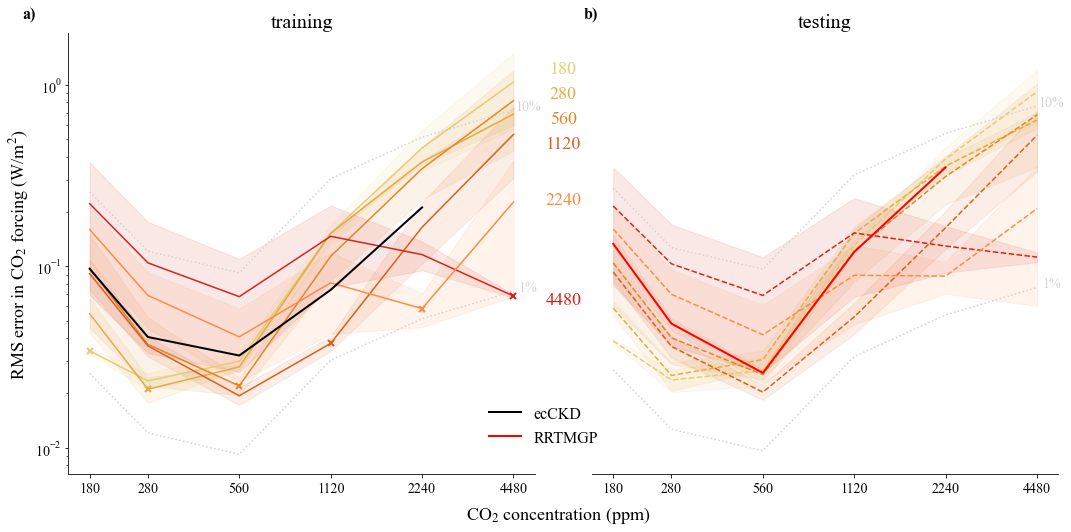

In [169]:
color_scheme_CO2 = np.array(cc.CET_L18)[np.arange(80, len(cc.CET_L18), len(cc.CET_L18)/6, dtype = int)]

CO2_concs = np.array([180, 280, 560, 1120, 2240, 4480])

forcing_4_train_mean_arms = np.array([CO2_train_mean_180_forcing_arms[0], CO2_train_mean_280_forcing_arms[0], CO2_train_mean_560_forcing_arms[0], CO2_train_mean_1120_forcing_arms[0], CO2_train_mean_2240_forcing_arms[0], CO2_train_mean_4480_forcing_arms[0]])
forcing_4_train_std_arms = np.array([CO2_train_std_180_forcing_arms[0], CO2_train_std_280_forcing_arms[0], CO2_train_std_560_forcing_arms[0], CO2_train_std_1120_forcing_arms[0], CO2_train_std_2240_forcing_arms[0], CO2_train_std_4480_forcing_arms[0]])

forcing_4_test_mean_arms = np.array([CO2_test_mean_180_forcing_arms[0], CO2_test_mean_280_forcing_arms[0], CO2_test_mean_560_forcing_arms[0], CO2_test_mean_1120_forcing_arms[0], CO2_test_mean_2240_forcing_arms[0], CO2_test_mean_4480_forcing_arms[0]])
forcing_4_test_std_arms = np.array([CO2_test_std_180_forcing_arms[0], CO2_test_std_280_forcing_arms[0], CO2_test_std_560_forcing_arms[0], CO2_test_std_1120_forcing_arms[0], CO2_test_std_2240_forcing_arms[0], CO2_test_std_4480_forcing_arms[0]])

forcing_8_train_mean_arms = np.array([CO2_train_mean_180_forcing_arms[1], CO2_train_mean_280_forcing_arms[1], CO2_train_mean_560_forcing_arms[1], CO2_train_mean_1120_forcing_arms[1], CO2_train_mean_2240_forcing_arms[1], CO2_train_mean_4480_forcing_arms[1]])
forcing_8_train_std_arms = np.array([CO2_train_std_180_forcing_arms[1], CO2_train_std_280_forcing_arms[1], CO2_train_std_560_forcing_arms[1], CO2_train_std_1120_forcing_arms[1], CO2_train_std_2240_forcing_arms[1], CO2_train_std_4480_forcing_arms[1]])

forcing_8_test_mean_arms = np.array([CO2_test_mean_180_forcing_arms[1], CO2_test_mean_280_forcing_arms[1], CO2_test_mean_560_forcing_arms[1], CO2_test_mean_1120_forcing_arms[1], CO2_test_mean_2240_forcing_arms[1], CO2_test_mean_4480_forcing_arms[1]])
forcing_8_test_std_arms = np.array([CO2_test_std_180_forcing_arms[1], CO2_test_std_280_forcing_arms[1], CO2_test_std_560_forcing_arms[1], CO2_test_std_1120_forcing_arms[1], CO2_test_std_2240_forcing_arms[1], CO2_test_std_4480_forcing_arms[1]])

forcing_16_train_mean_arms = np.array([CO2_train_mean_180_forcing_arms[2], CO2_train_mean_280_forcing_arms[2], CO2_train_mean_560_forcing_arms[2], CO2_train_mean_1120_forcing_arms[2], CO2_train_mean_2240_forcing_arms[2], CO2_train_mean_4480_forcing_arms[2]])
forcing_16_train_std_arms = np.array([CO2_train_std_180_forcing_arms[2], CO2_train_std_280_forcing_arms[2], CO2_train_std_560_forcing_arms[2], CO2_train_std_1120_forcing_arms[2], CO2_train_std_2240_forcing_arms[2], CO2_train_std_4480_forcing_arms[2]])

forcing_16_test_mean_arms = np.array([CO2_test_mean_180_forcing_arms[2], CO2_test_mean_280_forcing_arms[2], CO2_test_mean_560_forcing_arms[2], CO2_test_mean_1120_forcing_arms[2], CO2_test_mean_2240_forcing_arms[2], CO2_test_mean_4480_forcing_arms[2]])
forcing_16_test_std_arms = np.array([CO2_test_std_180_forcing_arms[2], CO2_test_std_280_forcing_arms[2], CO2_test_std_560_forcing_arms[2], CO2_test_std_1120_forcing_arms[2], CO2_test_std_2240_forcing_arms[2], CO2_test_std_4480_forcing_arms[2]])

forcing_32_train_mean_arms = np.array([CO2_train_mean_180_forcing_arms[3], CO2_train_mean_280_forcing_arms[3], CO2_train_mean_560_forcing_arms[3], CO2_train_mean_1120_forcing_arms[3], CO2_train_mean_2240_forcing_arms[3], CO2_train_mean_4480_forcing_arms[3]])
forcing_32_train_std_arms = np.array([CO2_train_std_180_forcing_arms[3], CO2_train_std_280_forcing_arms[3], CO2_train_std_560_forcing_arms[3], CO2_train_std_1120_forcing_arms[3], CO2_train_std_2240_forcing_arms[3], CO2_train_std_4480_forcing_arms[3]])

forcing_32_test_mean_arms = np.array([CO2_test_mean_180_forcing_arms[3], CO2_test_mean_280_forcing_arms[3], CO2_test_mean_560_forcing_arms[3], CO2_test_mean_1120_forcing_arms[3], CO2_test_mean_2240_forcing_arms[3], CO2_test_mean_4480_forcing_arms[3]])
forcing_32_test_std_arms = np.array([CO2_test_std_180_forcing_arms[3], CO2_test_std_280_forcing_arms[3], CO2_test_std_560_forcing_arms[3], CO2_test_std_1120_forcing_arms[3], CO2_test_std_2240_forcing_arms[3], CO2_test_std_4480_forcing_arms[3]])

forcing_64_train_mean_arms = np.array([CO2_train_mean_180_forcing_arms[4], CO2_train_mean_280_forcing_arms[4], CO2_train_mean_560_forcing_arms[4], CO2_train_mean_1120_forcing_arms[4], CO2_train_mean_2240_forcing_arms[4], CO2_train_mean_4480_forcing_arms[4]])
forcing_64_train_std_arms = np.array([CO2_train_std_180_forcing_arms[4], CO2_train_std_280_forcing_arms[4], CO2_train_std_560_forcing_arms[4], CO2_train_std_1120_forcing_arms[4], CO2_train_std_2240_forcing_arms[4], CO2_train_std_4480_forcing_arms[4]])

forcing_64_test_mean_arms = np.array([CO2_test_mean_180_forcing_arms[4], CO2_test_mean_280_forcing_arms[4], CO2_test_mean_560_forcing_arms[3], CO2_test_mean_1120_forcing_arms[4], CO2_test_mean_2240_forcing_arms[4], CO2_test_mean_4480_forcing_arms[4]])
forcing_64_test_std_arms = np.array([CO2_test_std_180_forcing_arms[4], CO2_test_std_280_forcing_arms[4], CO2_test_std_560_forcing_arms[3], CO2_test_std_1120_forcing_arms[4], CO2_test_std_2240_forcing_arms[4], CO2_test_std_4480_forcing_arms[4]])

# trained on different co2 scenarios
forcing_32_train_mean_arms_lgm = np.array([CO2_train_mean_180_lgm, CO2_train_mean_280_lgm, CO2_train_mean_560_lgm, CO2_train_mean_1120_lgm, CO2_train_mean_2240_lgm, CO2_train_mean_4480_lgm])
forcing_32_train_std_arms_lgm = np.array([CO2_train_std_180_lgm, CO2_train_std_280_lgm, CO2_train_std_560_lgm, CO2_train_std_1120_lgm, CO2_train_std_2240_lgm, CO2_train_std_4480_lgm])

forcing_32_test_mean_arms_lgm = np.array([CO2_test_mean_180_lgm, CO2_test_mean_280_lgm, CO2_test_mean_560_lgm, CO2_test_mean_1120_lgm, CO2_test_mean_2240_lgm, CO2_test_mean_4480_lgm])
forcing_32_test_std_arms_lgm = np.array([CO2_test_std_180_lgm, CO2_test_std_280_lgm, CO2_test_std_560_lgm, CO2_test_std_1120_lgm, CO2_test_std_2240_lgm, CO2_test_std_4480_lgm])

forcing_32_train_mean_arms_pi = np.array([CO2_train_mean_180_pi, CO2_train_mean_280_pi, CO2_train_mean_560_pi, CO2_train_mean_1120_pi, CO2_train_mean_2240_pi, CO2_train_mean_4480_pi])
forcing_32_train_std_arms_pi = np.array([CO2_train_std_180_pi, CO2_train_std_280_pi, CO2_train_std_560_pi, CO2_train_std_1120_pi, CO2_train_std_2240_pi, CO2_train_std_4480_pi])

forcing_32_test_mean_arms_pi = np.array([CO2_test_mean_180_pi, CO2_test_mean_280_pi, CO2_test_mean_560_pi, CO2_test_mean_1120_pi, CO2_test_mean_2240_pi, CO2_test_mean_4480_pi])
forcing_32_test_std_arms_pi = np.array([CO2_test_std_180_pi, CO2_test_std_280_pi, CO2_test_std_560_pi, CO2_test_std_1120_pi, CO2_test_std_2240_pi, CO2_test_std_4480_pi])

forcing_32_train_mean_arms_2x = np.array([CO2_train_mean_180_2x, CO2_train_mean_280_2x, CO2_train_mean_560_2x, CO2_train_mean_1120_2x, CO2_train_mean_2240_2x, CO2_train_mean_4480_2x])
forcing_32_train_std_arms_2x = np.array([CO2_train_std_180_2x, CO2_train_std_280_2x, CO2_train_std_560_2x, CO2_train_std_1120_2x, CO2_train_std_2240_2x, CO2_train_std_4480_2x])

forcing_32_test_mean_arms_2x = np.array([CO2_test_mean_180_2x, CO2_test_mean_280_2x, CO2_test_mean_560_2x, CO2_test_mean_1120_2x, CO2_test_mean_2240_2x, CO2_test_mean_4480_2x])
forcing_32_test_std_arms_2x = np.array([CO2_test_std_180_2x, CO2_test_std_280_2x, CO2_test_std_560_2x, CO2_test_std_1120_2x, CO2_test_std_2240_2x, CO2_test_std_4480_2x])

forcing_32_train_mean_arms_4x = np.array([CO2_train_mean_180_4x, CO2_train_mean_280_4x, CO2_train_mean_560_4x, CO2_train_mean_1120_4x, CO2_train_mean_2240_4x, CO2_train_mean_4480_4x])
forcing_32_train_std_arms_4x = np.array([CO2_train_std_180_4x, CO2_train_std_280_4x, CO2_train_std_560_4x, CO2_train_std_1120_4x, CO2_train_std_2240_4x, CO2_train_std_4480_4x])

forcing_32_test_mean_arms_4x = np.array([CO2_test_mean_180_4x, CO2_test_mean_280_4x, CO2_test_mean_560_4x, CO2_test_mean_1120_4x, CO2_test_mean_2240_4x, CO2_test_mean_4480_4x])
forcing_32_test_std_arms_4x = np.array([CO2_test_std_180_4x, CO2_test_std_280_4x, CO2_test_std_560_4x, CO2_test_std_1120_4x, CO2_test_std_2240_4x, CO2_test_std_4480_4x])

forcing_32_train_mean_arms_16x = np.array([CO2_train_mean_180_16x, CO2_train_mean_280_16x, CO2_train_mean_560_16x, CO2_train_mean_1120_16x, CO2_train_mean_2240_16x, CO2_train_mean_4480_16x])
forcing_32_train_std_arms_16x = np.array([CO2_train_std_180_16x, CO2_train_std_280_16x, CO2_train_std_560_16x, CO2_train_std_1120_16x, CO2_train_std_2240_16x, CO2_train_std_4480_16x])

forcing_32_test_mean_arms_16x = np.array([CO2_test_mean_180_16x, CO2_test_mean_280_16x, CO2_test_mean_560_16x, CO2_test_mean_1120_16x, CO2_test_mean_2240_16x, CO2_test_mean_4480_16x])
forcing_32_test_std_arms_16x = np.array([CO2_test_std_180_16x, CO2_test_std_280_16x, CO2_test_std_560_16x, CO2_test_std_1120_16x, CO2_test_std_2240_16x, CO2_test_std_4480_16x])

CO2_4480 = xr.open_dataset('/data/pc2943/co2_olr_net_norm_4480.h5', engine = "netcdf4")

eval1_4480_forcing_ref = up_TOA_eval1 - CO2_4480.OLR_4480_ref_train
eval2_4480_forcing_ref = up_TOA_eval2 - CO2_4480.OLR_4480_ref_test
eval1_2240_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_2240_ref_train
eval2_2240_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_2240_ref_test
eval1_1120_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_1120_ref_train
eval2_1120_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_1120_ref_test
eval1_560_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_560_ref_train
eval2_560_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_560_ref_test
eval1_280_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_280_ref_train
eval2_280_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_280_ref_test
eval1_180_forcing_ref = up_TOA_eval1 - CO2_OLR.OLR_180_ref_train
eval2_180_forcing_ref = up_TOA_eval2 - CO2_OLR.OLR_180_ref_test    

### Fig 6

fig, axes = plt.subplots(1, 2, figsize = (15, 7), sharex = 'all', sharey = 'all')

# plot the 10% line:
axes[0].loglog(CO2_concs,  np.abs(0.1*np.array([eval1_180_forcing_ref.mean(), eval1_280_forcing_ref.mean(), eval1_560_forcing_ref.mean(), eval1_1120_forcing_ref.mean(), eval1_2240_forcing_ref.mean(), eval1_4480_forcing_ref.mean()])), color = 'lightgrey', linestyle = 'dotted')
axes[0].text(5000, np.abs(0.1*np.array([eval1_180_forcing_ref.mean(), eval1_280_forcing_ref.mean(), eval1_560_forcing_ref.mean(), eval1_1120_forcing_ref.mean(), eval1_2240_forcing_ref.mean(), eval1_4480_forcing_ref.mean()]))[-1], '10%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)
axes[1].loglog(CO2_concs, np.abs(0.1*np.array([eval2_180_forcing_ref.mean(), eval2_280_forcing_ref.mean(), eval2_560_forcing_ref.mean(), eval2_1120_forcing_ref.mean(), eval2_2240_forcing_ref.mean(), eval2_4480_forcing_ref.mean()])), color = 'lightgrey', linestyle = 'dotted')
axes[1].text(5000, np.abs(0.1*np.array([eval2_180_forcing_ref.mean(), eval2_280_forcing_ref.mean(), eval2_560_forcing_ref.mean(), eval2_1120_forcing_ref.mean(), eval2_2240_forcing_ref.mean(), eval2_4480_forcing_ref.mean()]))[-1], '10%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

axes[0].loglog(CO2_concs,  np.abs(0.01*np.array([eval1_180_forcing_ref.mean(), eval1_280_forcing_ref.mean(), eval1_560_forcing_ref.mean(), eval1_1120_forcing_ref.mean(), eval1_2240_forcing_ref.mean(), eval1_4480_forcing_ref.mean()])), color = 'lightgrey', linestyle = 'dotted')
axes[0].text(5000, np.abs(0.01*np.array([eval1_180_forcing_ref.mean(), eval1_280_forcing_ref.mean(), eval1_560_forcing_ref.mean(), eval1_1120_forcing_ref.mean(), eval1_2240_forcing_ref.mean(), eval1_4480_forcing_ref.mean()]))[-1], '1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

axes[1].loglog(CO2_concs, np.abs(0.01*np.array([eval2_180_forcing_ref.mean(), eval2_280_forcing_ref.mean(), eval2_560_forcing_ref.mean(), eval2_1120_forcing_ref.mean(), eval2_2240_forcing_ref.mean(), eval2_4480_forcing_ref.mean()])), color = 'lightgrey', linestyle = 'dotted')
axes[1].text(5000, np.abs(0.01*np.array([eval2_180_forcing_ref.mean(), eval2_280_forcing_ref.mean(), eval2_560_forcing_ref.mean(), eval2_1120_forcing_ref.mean(), eval2_2240_forcing_ref.mean(), eval2_4480_forcing_ref.mean()]))[-1], '1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

# plot the different co2 scenario trainings
#lgm
axes[0].loglog(CO2_concs, forcing_32_train_mean_arms_lgm, color = color_scheme_CO2[0], label = '_nolegend_')
axes[0].loglog(CO2_concs[0], forcing_32_train_mean_arms_lgm[0], 'x', markeredgewidth = 2, color = color_scheme_CO2[0])

axes[1].loglog(CO2_concs, forcing_32_test_mean_arms_lgm, '--', color = color_scheme_CO2[0], label = '_nolegend_')

axes[0].fill_between(CO2_concs, forcing_32_train_mean_arms_lgm[:, 0].T - forcing_32_train_std_arms_lgm[:, 0].T, forcing_32_train_mean_arms_lgm[:, 0].T + forcing_32_train_std_arms_lgm[:, 0].T,
alpha=0.1, color = color_scheme_CO2[0],  label = '_nolegend_')
axes[1].fill_between(CO2_concs, forcing_32_test_mean_arms_lgm[:, 0].T - forcing_32_test_std_arms_lgm[:, 0].T, forcing_32_test_mean_arms_lgm[:, 0].T + forcing_32_test_std_arms_lgm[:, 0].T,
alpha=0.1, color = color_scheme_CO2[0],  label = '_nolegend_')    

#pi
axes[0].loglog(CO2_concs, forcing_32_train_mean_arms_pi, color = color_scheme_CO2[1], label = '_nolegend_')
axes[0].loglog(CO2_concs[1], forcing_32_train_mean_arms_pi[1], 'x', markeredgewidth = 2, color = color_scheme_CO2[1])

axes[1].loglog(CO2_concs, forcing_32_test_mean_arms_pi, '--', color = color_scheme_CO2[1], label = '_nolegend_')

axes[0].fill_between(CO2_concs, forcing_32_train_mean_arms_pi[:, 0].T - forcing_32_train_std_arms_pi[:, 0].T, forcing_32_train_mean_arms_pi[:, 0].T + forcing_32_train_std_arms_pi[:, 0].T,
alpha=0.1, color = color_scheme_CO2[1],  label = '_nolegend_')
axes[1].fill_between(CO2_concs, forcing_32_test_mean_arms_pi[:, 0].T - forcing_32_test_std_arms_pi[:, 0].T, forcing_32_test_mean_arms_pi[:, 0].T + forcing_32_test_std_arms_pi[:, 0].T,
alpha=0.1, color = color_scheme_CO2[1],  label = '_nolegend_')    

#2x co2
axes[0].loglog(CO2_concs, forcing_32_train_mean_arms_2x, color = color_scheme_CO2[2], label = '_nolegend_')
axes[0].loglog(CO2_concs[2], forcing_32_train_mean_arms_2x[2], 'x', markeredgewidth = 2, color = color_scheme_CO2[2])

axes[1].loglog(CO2_concs, forcing_32_test_mean_arms_2x, '--', color = color_scheme_CO2[2], label = '_nolegend_')

axes[0].fill_between(CO2_concs, forcing_32_train_mean_arms_2x[:, 0].T - forcing_32_train_std_arms_2x[:, 0].T, forcing_32_train_mean_arms_2x[:, 0].T + forcing_32_train_std_arms_2x[:, 0].T,
alpha=0.1, color = color_scheme_CO2[2],  label = '_nolegend_')
axes[1].fill_between(CO2_concs, forcing_32_test_mean_arms_2x[:, 0].T - forcing_32_test_std_arms_2x[:, 0].T, forcing_32_test_mean_arms_2x[:, 0].T + forcing_32_test_std_arms_2x[:, 0].T,
alpha=0.1, color = color_scheme_CO2[2],  label = '_nolegend_')    

#4x co2
axes[0].loglog(CO2_concs, forcing_32_train_mean_arms_4x, color = color_scheme_CO2[3], label = '_nolegend_')
axes[0].loglog(CO2_concs[3], forcing_32_train_mean_arms_4x[3], 'x', markeredgewidth = 2, color = color_scheme_CO2[3])

axes[1].loglog(CO2_concs, forcing_32_test_mean_arms_4x, '--', color = color_scheme_CO2[3], label = '_nolegend_')

axes[0].fill_between(CO2_concs, forcing_32_train_mean_arms_4x[:, 0].T - forcing_32_train_std_arms_4x[:, 0].T, forcing_32_train_mean_arms_4x[:, 0].T + forcing_32_train_std_arms_4x[:, 0].T,
alpha=0.1, color = color_scheme_CO2[3],  label = '_nolegend_')
axes[1].fill_between(CO2_concs, forcing_32_test_mean_arms_4x[:, 0].T - forcing_32_test_std_arms_4x[:, 0].T, forcing_32_test_mean_arms_4x[:, 0].T + forcing_32_test_std_arms_4x[:, 0].T,
alpha=0.1, color = color_scheme_CO2[3],  label = '_nolegend_')    

#16x co2
axes[0].loglog(CO2_concs, forcing_32_train_mean_arms_16x, color = color_scheme_CO2[4], label = '_nolegend_')
axes[0].loglog(CO2_concs[-1], forcing_32_train_mean_arms_16x[-1], 'x', markeredgewidth = 2, color = color_scheme_CO2[4])

axes[1].loglog(CO2_concs, forcing_32_test_mean_arms_16x, '--', color = color_scheme_CO2[4], label = '_nolegend_')

axes[0].fill_between(CO2_concs, forcing_32_train_mean_arms_16x[:, 0].T - forcing_32_train_std_arms_16x[:, 0].T, forcing_32_train_mean_arms_16x[:, 0].T + forcing_32_train_std_arms_16x[:, 0].T,
alpha=0.1, color = color_scheme_CO2[4],  label = '_nolegend_')
axes[1].fill_between(CO2_concs, forcing_32_test_mean_arms_16x[:, 0].T - forcing_32_test_std_arms_16x[:, 0].T, forcing_32_test_mean_arms_16x[:, 0].T + forcing_32_test_std_arms_16x[:, 0].T,
alpha=0.1, color = color_scheme_CO2[4],  label = '_nolegend_')   


axes[0].loglog(CO2_concs, forcing_32_train_mean_arms, color = color_scheme_5[3], label = '_nolegend_')
axes[0].loglog(CO2_concs[-2], forcing_32_train_mean_arms[-2], 'x', markeredgewidth = 2, color = color_scheme_5[3])

axes[1].loglog(CO2_concs, forcing_32_test_mean_arms, '--', color = color_scheme_5[3], label = '_nolegend_')

axes[0].fill_between(CO2_concs, forcing_32_train_mean_arms - forcing_32_train_std_arms, forcing_32_train_mean_arms + forcing_32_train_std_arms,
alpha=0.1, color = color_scheme_5[3],  label = '_nolegend_')
axes[1].fill_between(CO2_concs, forcing_32_test_mean_arms - forcing_32_test_std_arms, forcing_32_test_mean_arms + forcing_32_test_std_arms,
alpha=0.1, color = color_scheme_5[3],  label = '_nolegend_')    

axes[1].loglog(CO2_concs[:-1], rrtmgp_forcing_amse, color = 'red', linewidth = 2, label = 'RRTMGP')
#axes[1].loglog(CO2_concs[:-1], ecckd_forcing_amse, color = 'black', linewidth = 2, label = '_nolegend_', alpha = 0.1)
#axes[0].loglog(CO2_concs[:-1], rrtmgp_forcing_amse, color = 'red', linewidth = 2, label = '_nolegend_', alpha = 0.1)
axes[0].loglog(CO2_concs[:-1], ecckd_forcing_amse, color = 'black', linewidth = 2, label = 'ecCKD')


#fig.text(0.525, 0.86, '4', color = color_scheme_5[0], horizontalalignment = 'center', fontsize = text_fontsize)
#fig.text(0.525, 0.72, '8', color = color_scheme_5[1], horizontalalignment = 'center', fontsize = text_fontsize)
#fig.text(0.525, 0.59, '16', color = color_scheme_5[2], horizontalalignment = 'center', fontsize = text_fontsize)
#fig.text(0.525, 0.45, '32', color = color_scheme_5[3], horizontalalignment = 'center', fontsize = text_fontsize)
#fig.text(0.525, 0.35, '64', color = color_scheme_5[4], horizontalalignment = 'center', fontsize = text_fontsize)
#fig.text(0.525, 0.36, 'rrtmgp', color = 'red', horizontalalignment = 'center', fontsize = text_fontsize)
#fig.text(0.525, 0.27, 'ecckd', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

# figure properties
axes[0].set_xticks(CO2_concs)
axes[0].set_xticklabels(CO2_concs)
axes[0].tick_params(axis = 'both', labelsize = tick_fontsize)
#plt.legend(["training 32", "testing 32", "rrtmgp", "ecckd"], fontsize = legend_fontsize)
sns.despine()
sns.despine(ax = axes[1], left = True)
fig.text(0.52, -0.025, 'CO$_2$ concentration (ppm)', ha='center', fontsize = label_fontsize)
axes[0].set_ylabel("RMS error in CO$_2$ forcing (W/m$^2$)", fontsize = label_fontsize)

axes[1].set_xticks(CO2_concs)
axes[1].set_xticklabels(CO2_concs)
#axes[1].set_xticklabels(np.array(['LGM', 'PI', '2xPI', '4xPI', '8xPI', '16xPI']))

axes[1].tick_params(axis = 'x', which = 'major', labelsize = tick_fontsize)
axes[1].yaxis.set_visible(False)

axes[0].set_title("training", fontsize = title_fontsize)
axes[1].set_title("testing", fontsize = title_fontsize)

fig.legend(loc = (0.45, 0.15), frameon = False, prop={'size': legend_fontsize})

#plt.minorticks_off()
axes[0].tick_params(axis='x', which='minor', bottom=False)
axes[1].tick_params(axis='x', which='minor', bottom=False)

fig.text(0.03, 0.97, 'a)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')
fig.text(0.55, 0.97, 'b)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')
fig.tight_layout(w_pad=5.0)

fig.text(0.525, 0.86, '180', color = color_scheme_CO2[0], horizontalalignment = 'center', fontsize = text_fontsize)
fig.text(0.525, 0.81, '280', color = color_scheme_CO2[1], horizontalalignment = 'center', fontsize = text_fontsize)
fig.text(0.525, 0.76, '560', color = color_scheme_CO2[2], horizontalalignment = 'center', fontsize = text_fontsize)
fig.text(0.525, 0.71, '1120', color = color_scheme_CO2[3], horizontalalignment = 'center', fontsize = text_fontsize)
fig.text(0.525, 0.60, '2240', color = color_scheme_5[3], horizontalalignment = 'center', fontsize = text_fontsize)
fig.text(0.525, 0.4, '4480', color = color_scheme_CO2[4], horizontalalignment = 'center', fontsize = text_fontsize)


plt.savefig('co2_scenarios.pdf', bbox_inches='tight', dpi=600)

plt.show()


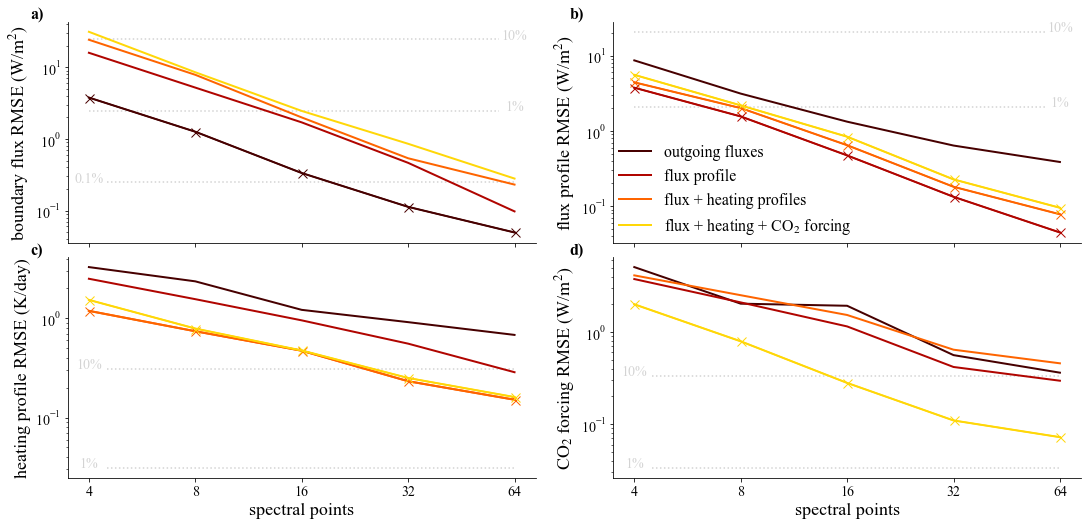

In [152]:
### Fig. 7
#colors_cost = cc.bgyw
colors_cost = cc.fire
#color_scheme_cost =  np.array(colors_cost)[np.array([10, 100, 150, 220])]
color_scheme_cost = np.array(colors_cost)[np.arange(30, len(colors_cost), len(colors_cost)/4, dtype = int)]

fig, axes = plt.subplots(2, 2, figsize = (15, 7), sharex = 'all', constrained_layout = True)

# plot the 10% and 1% line:
axes[0, 0].loglog(np.linspace(4, 58, len(subset_sizes)), 0.1*np.abs(np.mean([up_TOA_eval1, dn_BOA_eval1]))*np.ones(len(subset_sizes)), color = 'lightgrey', linestyle = 'dotted')
axes[0, 0].text(64, 0.1*np.abs(np.mean([up_TOA_eval1, dn_BOA_eval1])), '10%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)
axes[0, 0].loglog(np.linspace(4, 58, len(subset_sizes)), 0.01*np.abs(np.mean([up_TOA_eval2, dn_BOA_eval2]))*np.ones(len(subset_sizes)), color = 'lightgrey', linestyle = 'dotted')
axes[0, 0].text(64, 0.01*np.abs(np.mean([up_TOA_eval1, dn_BOA_eval1])), '1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)
axes[0, 0].loglog(np.linspace(4.5, 64, len(subset_sizes)), 0.001*np.abs(np.mean([up_TOA_eval2, dn_BOA_eval2]))*np.ones(len(subset_sizes)), color = 'lightgrey', linestyle = 'dotted')
axes[0, 0].text(4, 0.001*np.abs(np.mean([up_TOA_eval1, dn_BOA_eval1])), '0.1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

axes[0, 1].loglog(np.linspace(4, 58, len(subset_sizes)), 0.1*np.abs(np.mean(eval1_net_all))*np.ones(len(subset_sizes)), color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[0, 1].text(64, 0.1*np.abs(np.mean(eval1_net_all)), '10%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)
axes[0, 1].loglog(np.linspace(4, 58, len(subset_sizes)), 0.01*np.abs(np.mean(eval1_net_all))*np.ones(len(subset_sizes)), color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[0, 1].text(64, 0.01*np.abs(np.mean(eval1_net_all)), '1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

axes[1, 0].plot(np.linspace(4.5, 64, len(subset_sizes)), np.mean(0.1*np.abs(np.mean(train_heating_ref, axis = 0)))*np.ones(len(subset_sizes)), color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[1, 0].text(subset_sizes[0], 0.1*np.abs(np.mean(train_heating_ref)), '10%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)
axes[1, 0].plot(np.linspace(4.5, 64, len(subset_sizes)), np.mean(0.01*np.abs(np.mean(train_heating_ref, axis = 0)))*np.ones(len(subset_sizes)), color = 'lightgrey', label = '_nolegend_', linestyle = 'dotted')
axes[1, 0].text(subset_sizes[0], 0.01*np.abs(np.mean(train_heating_ref)), '1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)

axes[1, 1].loglog(np.linspace(4.5, 64, len(subset_sizes)),  np.mean(np.abs(0.1*np.array([eval1_180_forcing_ref.mean(), eval1_280_forcing_ref.mean(), eval1_560_forcing_ref.mean(), eval1_1120_forcing_ref.mean(), eval1_2240_forcing_ref.mean(), eval1_4480_forcing_ref.mean()])))*np.ones(len(subset_sizes)), color = 'lightgrey', linestyle = 'dotted')
axes[1, 1].text(subset_sizes[0], np.mean(np.abs(0.1*np.array([eval1_180_forcing_ref.mean(), eval1_280_forcing_ref.mean(), eval1_560_forcing_ref.mean(), eval1_1120_forcing_ref.mean(), eval1_2240_forcing_ref.mean(), eval1_4480_forcing_ref.mean()]))), '10%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)
axes[1, 1].loglog(np.linspace(4.5, 64, len(subset_sizes)),  np.mean(np.abs(0.01*np.array([eval1_180_forcing_ref.mean(), eval1_280_forcing_ref.mean(), eval1_560_forcing_ref.mean(), eval1_1120_forcing_ref.mean(), eval1_2240_forcing_ref.mean(), eval1_4480_forcing_ref.mean()])))*np.ones(len(subset_sizes)), color = 'lightgrey', linestyle = 'dotted')
axes[1, 1].text(subset_sizes[0], np.mean(np.abs(0.01*np.array([eval1_180_forcing_ref.mean(), eval1_280_forcing_ref.mean(), eval1_560_forcing_ref.mean(), eval1_1120_forcing_ref.mean(), eval1_2240_forcing_ref.mean(), eval1_4480_forcing_ref.mean()]))), '1%', color = 'lightgrey', horizontalalignment = 'center', fontsize = tick_fontsize)


# a) errors of outgoing fluxes for different models
test_outgoing_regression_arms = np.mean([up_TOA_test_mean_regression_arms, dn_BOA_test_mean_regression_arms], axis = 0)
test_outgoing_fh_arms = np.mean([up_TOA_test_mean_fh_arms, dn_BOA_test_mean_fh_arms], axis = 0)
test_outgoing_forcing_arms = np.mean([up_TOA_test_mean_forcing_arms, dn_BOA_test_mean_forcing_arms], axis = 0)

axes[0, 0].loglog(subset_sizes, test_outgoing_arms, color = color_scheme_cost[0], linewidth = 2)
axes[0, 0].loglog(subset_sizes, test_outgoing_arms, color = color_scheme_cost[0], marker = 'x', markersize = marker_fontsize, label = "_nolegend_")
axes[0, 0].loglog(subset_sizes, test_outgoing_regression_arms, color = color_scheme_cost[1], linewidth = 2)
axes[0, 0].loglog(subset_sizes, test_outgoing_fh_arms, color = color_scheme_cost[2], linewidth = 2)
axes[0, 0].loglog(subset_sizes, test_outgoing_forcing_arms, color = color_scheme_cost[3], linewidth = 2)

axes[0, 0].tick_params(axis = 'both', which = 'major', labelsize = tick_fontsize)
axes[0, 0].set_xticks(ticks = np.array([4, 8, 16, 32, 64]))

axes[0, 0].set_ylabel("boundary flux RMSE (W/m$^2$)", fontsize = label_fontsize)
axes[0, 0].tick_params(axis = 'both', labelsize = tick_fontsize)


# b) errors of all fluxes for different models
axes[0, 1].loglog(subset_sizes, np.mean(flux_test_arms_mean_all_outgoing, axis = 1), color = color_scheme_cost[0], linewidth = 2)
axes[0, 1].loglog(subset_sizes, np.mean(flux_test_arms_mean_all_regression, axis = 1), color = color_scheme_cost[1], linewidth = 2)
axes[0, 1].loglog(subset_sizes, np.mean(flux_test_arms_mean_all_regression, axis = 1), color = color_scheme_cost[1], marker = 'x', markersize = marker_fontsize, label = "_nolegend_")
axes[0, 1].loglog(subset_sizes, np.mean(flux_test_arms_mean_all_fh, axis = 1), color = color_scheme_cost[2], linewidth = 2)
axes[0, 1].loglog(subset_sizes, np.mean(flux_test_arms_mean_all_fh, axis = 1), color = color_scheme_cost[2], marker = 'x', markersize = marker_fontsize, label = "_nolegend_")
axes[0, 1].loglog(subset_sizes, np.mean(flux_test_arms_mean_all_forcing, axis = 1), color = color_scheme_cost[3], linewidth = 2)
axes[0, 1].loglog(subset_sizes, np.mean(flux_test_arms_mean_all_forcing, axis = 1), color = color_scheme_cost[3], marker = 'x', markersize = marker_fontsize, label = "_nolegend_")

axes[0, 1].tick_params(axis = 'both', which = 'major', labelsize = tick_fontsize)
axes[0, 1].set_xticks(ticks = np.array([4, 8, 16, 32, 64]))

axes[0, 1].set_ylabel("flux profile RMSE (W/m$^2$)", fontsize = label_fontsize)
axes[0, 1].tick_params(axis = 'both', labelsize = tick_fontsize)

# c) errors of rmse heating rates for different models
axes[1, 0].loglog(subset_sizes, np.mean(hr_arms_error_test_mean_outgoing_all[:, 2:], axis = 1), color = color_scheme_cost[0], linewidth = 2)
axes[1, 0].loglog(subset_sizes, np.mean(hr_arms_error_test_mean_regression_all[:, 2:], axis = 1), color = color_scheme_cost[1], linewidth = 2)
axes[1, 0].loglog(subset_sizes, np.mean(hr_arms_error_test_mean_fh_all[:, 2:], axis = 1), color = color_scheme_cost[2], linewidth = 2)
axes[1, 0].loglog(subset_sizes, np.mean(hr_arms_error_test_mean_fh_all[:, 2:], axis = 1), color = color_scheme_cost[2], marker = 'x', markersize = marker_fontsize, linewidth = 2)
axes[1, 0].loglog(subset_sizes, np.mean(hr_arms_error_test_mean_forcing_all[:, 2:], axis = 1), color = color_scheme_cost[3], linewidth = 2)
axes[1, 0].loglog(subset_sizes, np.mean(hr_arms_error_test_mean_forcing_all[:, 2:], axis = 1), color = color_scheme_cost[3], marker = 'x', markersize = marker_fontsize)

axes[1, 0].set_xticks(ticks = np.array([4, 8, 16, 32, 64]))


axes[1, 0].set_ylabel("heating profile RMSE (K/day)", fontsize = label_fontsize)
axes[1, 0].set_xlabel("spectral points", fontsize = label_fontsize)


# d) errors of CO2 forcing for different models

axes[1, 1].loglog(subset_sizes, np.mean([forcing_4_test_mean_outgoing_arms, forcing_8_test_mean_outgoing_arms, forcing_16_test_mean_outgoing_arms, forcing_32_test_mean_outgoing_arms, forcing_64_test_mean_outgoing_arms], axis = 1), color = color_scheme_cost[0], linewidth = 2)
axes[1, 1].loglog(subset_sizes, np.mean([forcing_4_test_mean_regression_arms, forcing_8_test_mean_regression_arms, forcing_16_test_mean_regression_arms, forcing_32_test_mean_regression_arms, forcing_64_test_mean_regression_arms], axis = 1), color = color_scheme_cost[1], linewidth = 2)
axes[1, 1].loglog(subset_sizes, np.mean([forcing_4_test_mean_fh_arms, forcing_8_test_mean_fh_arms, forcing_16_test_mean_fh_arms, forcing_32_test_mean_fh_arms, forcing_64_test_mean_fh_arms], axis = 1), color = color_scheme_cost[2], linewidth = 2)
axes[1, 1].loglog(subset_sizes, np.mean([forcing_4_test_mean_arms, forcing_8_test_mean_arms, forcing_16_test_mean_arms, forcing_32_test_mean_arms, forcing_64_test_mean_arms], axis = 1), color = color_scheme_cost[3], linewidth = 2)
axes[1, 1].loglog(subset_sizes, np.mean([forcing_4_test_mean_arms, forcing_8_test_mean_arms, forcing_16_test_mean_arms, forcing_32_test_mean_arms, forcing_64_test_mean_arms], axis = 1), color = color_scheme_cost[3], marker = 'x', markersize = marker_fontsize)


axes[1, 1].tick_params(axis = 'both', which = 'major', labelsize = tick_fontsize)
axes[1, 1].set_xticks(ticks = np.array([4, 8, 16, 32, 64]))

axes[1, 1].set_ylabel("CO$_2$ forcing RMSE (W/m$^2$)", fontsize = label_fontsize)
axes[1, 1].set_xlabel("spectral points", fontsize = label_fontsize)
axes[1, 1].tick_params(axis = 'both', labelsize = tick_fontsize)

axes[0, 0].tick_params(axis='x', which='minor', bottom=False)
axes[0, 1].tick_params(axis='x', which='minor', bottom=False)
axes[1, 1].tick_params(axis='x', which='minor', bottom=False)
axes[1, 0].tick_params(axis='x', which='minor', bottom=False)

axes[1, 0].tick_params(axis = 'both', which = 'major', labelsize = tick_fontsize)
axes[1, 0].set_xticklabels(subset_sizes)

axes[0, 1].legend(['outgoing fluxes', 'flux profile', 'flux + heating profiles', 'flux + heating + CO$_2$ forcing'], fontsize = legend_fontsize, frameon = False, loc = (0, 0))
sns.despine()

fig.text(0.03, 1, 'a)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')
fig.text(0.53, 1, 'b)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')
fig.text(0.03, 0.53, 'c)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')
fig.text(0.53, 0.53, 'd)', color = 'black', horizontalalignment = 'center', fontsize = legend_fontsize, weight = 'bold')

plt.savefig('cost_functions.pdf', bbox_inches='tight', dpi=600)
plt.show()

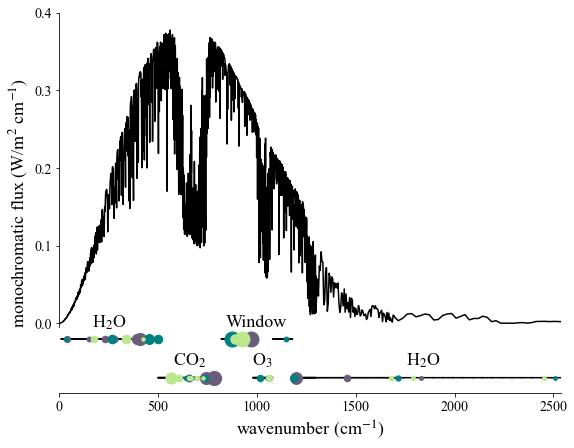

In [257]:
### Fig 8
### Spectrum

spec_color_scheme = np.array(['#6A5D7B', '#008080', '#bbe88e'])

spec_input = ["/data/pc2943/eval1_spectral_fluxes_1-10_4angle.h5"]
spec_fluxes = xr.open_mfdataset(spec_input, 
                                combine = 'nested', concat_dim = 'column',
                               engine = "netcdf4")


# set up coordinates/arrays
upper_coord = -0.02
lower_coord = -0.07

wavenumber_coords = spec_fluxes.wavenumber.data
d_nu_official = 0.005*np.ones(len(wavenumber_coords) - 1)
d_nu_official[np.where(wavenumber_coords < 1700)] = 0.001
d_nu_official[np.where(wavenumber_coords < 1300)] = 0.0002
official_spectrum = np.abs(spec_fluxes.spectral_flux_up_lw.isel(half_level = 0, column = -1) - spec_fluxes.spectral_flux_dn_lw.isel(half_level = 0, column = 1))[:-1]/d_nu_official

fig, ax = plt.subplots(figsize = (9, 7))
H2O_band_1 = wavenumber_coords[np.where((10 < wavenumber_coords) & (wavenumber_coords < 500))[0]]
plt.plot(H2O_band_1, upper_coord*np.ones(len(H2O_band_1)), color = 'black')
ax.text((10 + 500)/2, upper_coord + .015, 'H$_2$O', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

CO2_band = wavenumber_coords[np.where((500 < wavenumber_coords) & (wavenumber_coords < 820))[0]]
plt.plot(CO2_band, lower_coord*np.ones(len(CO2_band)), color = 'black')
ax.text((500 + 820)/2, lower_coord + .015, 'CO$_2$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

window = wavenumber_coords[np.where(((820 < wavenumber_coords) & (wavenumber_coords < 980)) | ((1080 < wavenumber_coords) & (wavenumber_coords < 1180)))[0]]
plt.plot(window, upper_coord*np.ones(len(window)), color = 'black')
ax.text((820 + 1180)/2, upper_coord + .015, 'Window', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

ozone = wavenumber_coords[np.where((980 < wavenumber_coords) & (1080 > wavenumber_coords))[0]]
plt.plot(ozone, lower_coord*np.ones(len(ozone)), color = 'black')
ax.text((980 + 1080)/2, lower_coord + .015, 'O$_3$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

H2O_band_2 = wavenumber_coords[np.where(wavenumber_coords > 1180)[0]]
plt.plot(H2O_band_2, lower_coord*np.ones(len(H2O_band_2)), color = 'black')
ax.text((1180 + 2500)/2, lower_coord + .015, 'H$_2$O', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)


plt.rcParams['agg.path.chunksize'] = 10000

plt.plot(wavenumber_coords[::4500], official_spectrum[::4500], color = 'black')

for iter_idx in np.arange(3):

    results = xr.open_dataset('/home/pc2943/Paper I Repo/Results Files/' + str(16) + '_linear_annealing_4angle_100_' + str(iter_idx) + '.h5', engine = "netcdf4")
    # recast weights to be markersizes

    importance = official_spectrum[results.S.data].compute() * results.W.data
    OldRange = (np.max(importance) - np.min(importance))  
    NewRange = (30 - 7)  

    for i in range(len(results.S.data)):
        prop_markersize = (((importance[i] - np.min(importance)) * NewRange) / OldRange) + 7
        if (wavenumber_coords[results.S.data[i]] < 500) | ((820 < wavenumber_coords[results.S.data[i]]) & (wavenumber_coords[results.S.data[i]] < 980)) | ((1080 < wavenumber_coords[results.S.data[i]]) & (wavenumber_coords[results.S.data[i]] < 1180)):
            plt.plot(wavenumber_coords[results.S.data[i]], upper_coord, '.', color = spec_color_scheme[iter_idx], markersize = prop_markersize)
        else:
            plt.plot(wavenumber_coords[results.S.data[i]], lower_coord, '.', color = spec_color_scheme[iter_idx], markersize = prop_markersize)


plt.ylim((-0.09, 0.4))
plt.xlim((0, 2540))


sns.despine()
plt.ylabel('monochromatic flux (W/m$^2$ cm$^{-1}$)', fontsize = label_fontsize)
plt.xlabel('wavenumber (cm$^{-1}$)', fontsize = label_fontsize)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax.spines['left'].set_bounds(-0.005, 0.4)

plt.savefig("subset_example.png", bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
### Fig 9 Calculations
tau_input = ['/data/pc2943/eval1_spectral_fluxes_od_test_1-10_4angle.h5', '/data/pc2943/eval1_spectral_fluxes_od_test_11-20_4angle.h5', '/data/pc2943/eval1_spectral_fluxes_od_test_21-30_4angle.h5', '/data/pc2943/eval1_spectral_fluxes_od_test_31-40_4angle.h5', '/data/pc2943/eval1_spectral_fluxes_od_test_41-50_4angle.h5']
level_array = np.array([2, 6, 11, 15, 20, 24, 29, 33, 38, 43, 49, 53]) # define which half-levels

tau_data = xr.open_mfdataset(tau_input,
                      combine = 'nested', concat_dim = 'column', 
                              engine = "netcdf4")

# transpose into appropriate shape for spectral and reference fluxes, do not open files
tau_train = tau_data.optical_depth.transpose('level', 'column', 'wavenumber').isel(level = level_array).compute()

optical_depth = tau_train.cumsum(dim = 'level')

/home/pc2943/.conda/envs/pangeoxtdai36/lib/python3.6/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [28]:
tau_input_test = ['/data/pc2943/eval2_spectral_fluxes_od_test_1-10_4angle.h5', '/data/pc2943/eval2_spectral_fluxes_od_test_11-20_4angle.h5', '/data/pc2943/eval2_spectral_fluxes_od_test_21-30_4angle.h5', '/data/pc2943/eval2_spectral_fluxes_od_test_31-40_4angle.h5', '/data/pc2943/eval2_spectral_fluxes_od_test_41-50_4angle.h5']
level_array = np.array([2, 6, 11, 15, 20, 24, 29, 33, 38, 43, 49, 53]) # define which half-levels

tau_data_test = xr.open_mfdataset(tau_input_test,
                      combine = 'nested', concat_dim = 'column', 
                              engine = "netcdf4")

# transpose into appropriate shape for spectral and reference fluxes, do not open files
tau_test = tau_data_test.optical_depth.transpose('level', 'column', 'wavenumber').isel(level = level_array).compute()

optical_depth_test = tau_test.cumsum(dim = 'level')

/home/pc2943/.conda/envs/pangeoxtdai36/lib/python3.6/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [166]:
subset_sizes = np.array([4, 8, 16, 32, 64])
reps = np.arange(16)
directory = '/home/pc2943/Paper I Repo/Results Files/'
filename = '_linear_annealing_4angle_100_'

def compute_optically_thick_level(directory, filename, subset_size, reps):
    mean_optically_thick_levels_train = np.zeros((len(reps), subset_size))
    mean_optically_thick_levels_test = np.zeros((len(reps), subset_size))

    for i in range(len(reps)): 
        results = xr.open_dataset(directory + str(subset_size) + filename + str(reps[i]) + '.h5', engine = "netcdf4")
        data_train = optical_depth.isel(wavenumber = results.S.data)
        #data_test = optical_depth_test.isel(wavenumber = results.S.data)

        optically_thick_train = np.zeros((len(results.S.data), 50))
        optically_thick_test = np.zeros((len(results.S.data), 50))

        for col in range(50):
            for nu in range(len(results.S.data)):
                if len(np.where(data_train.isel(wavenumber = nu, column = col) > 1)[0]) != 0:
                    optically_thick_train[nu, col] = (level_array[np.min(np.where(data_train.isel(wavenumber = nu, column = col) > 1))])                
                else:
                    optically_thick_train[nu, col] = 54
                #if len(np.where(data_test.isel(wavenumber = nu, column = col) > 1)[0]) != 0:
                #    optically_thick_test[nu, col] = (eval2_pressure[:, np.min(np.where(data_test.isel(wavenumber = nu, column = col) > 1)[0])]/100).mean()                
                #else:
                #    optically_thick_test[nu, col] = (eval2_pressure[:, -1]/100).mean()
                    
        mean_optically_thick_levels_train[i, :] = np.sort(optically_thick_train.mean(axis = -1))
        #mean_optically_thick_levels_test[i, :] = np.sort(optically_thick_test.mean(axis = -1))

    return mean_optically_thick_levels_train, mean_optically_thick_levels_test


In [167]:
mean_optically_thick_levels_4_train, mean_optically_thick_levels_4_test = compute_optically_thick_level(directory, filename, 4, reps)
mean_optically_thick_levels_8_train, mean_optically_thick_levels_8_test = compute_optically_thick_level(directory, filename, 8, reps)
mean_optically_thick_levels_16_train, mean_optically_thick_levels_16_test = compute_optically_thick_level(directory, filename, 16, reps)
mean_optically_thick_levels_32_train, mean_optically_thick_levels_32_test = compute_optically_thick_level(directory, filename, 32, reps)
mean_optically_thick_levels_64_train, mean_optically_thick_levels_64_test = compute_optically_thick_level(directory, filename, 64, reps)

In [168]:
mean_optically_thick_levels_4_regression_train, mean_optically_thick_levels_4_regression_test = compute_optically_thick_level(directory, '_linear_annealing_4angle_100_regression_', 4, reps)
mean_optically_thick_levels_8_regression_train, mean_optically_thick_levels_8_regression_test = compute_optically_thick_level(directory, '_linear_annealing_4angle_100_regression_', 8, reps)
mean_optically_thick_levels_16_regression_train, mean_optically_thick_levels_16_regression_test = compute_optically_thick_level(directory, '_linear_annealing_4angle_100_regression_', 16, reps)
mean_optically_thick_levels_32_regression_train, mean_optically_thick_levels_32_regression_test = compute_optically_thick_level(directory, '_linear_annealing_4angle_100_regression_', 32, reps)
mean_optically_thick_levels_64_regression_train, mean_optically_thick_levels_64_regression_test = compute_optically_thick_level(directory, '_linear_annealing_4angle_100_regression_', 64, reps)

In [169]:
mean_optically_thick_levels_4_forcing_train, mean_optically_thick_levels_4_forcing_test = compute_optically_thick_level(directory, '_linear_annealing_4angle_100_forcing_', 4, reps)
mean_optically_thick_levels_8_forcing_train, mean_optically_thick_levels_8_forcing_test = compute_optically_thick_level(directory, '_linear_annealing_4angle_100_forcing_', 8, reps)
mean_optically_thick_levels_16_forcing_train, mean_optically_thick_levels_16_forcing_test = compute_optically_thick_level(directory, '_linear_annealing_4angle_100_forcing_', 16, reps)
mean_optically_thick_levels_32_forcing_train, mean_optically_thick_levels_32_forcing_test = compute_optically_thick_level(directory, '_linear_annealing_4angle_100_forcing_', 32, reps)
mean_optically_thick_levels_64_forcing_train, mean_optically_thick_levels_64_forcing_test = compute_optically_thick_level(directory, '_linear_annealing_4angle_100_forcing_', 64, reps)

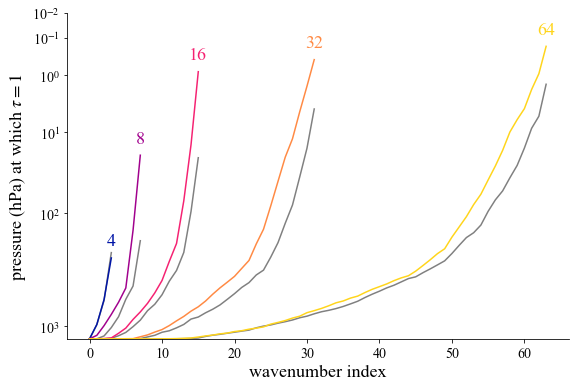

In [189]:
### Fig. 9

fig, axes = plt.subplots(figsize = (9, 6))

plt.plot(np.arange(4), np.flip(mean_optically_thick_levels_4_regression_train.mean(axis = 0)), color = 'grey', label = 'fluxes; train')
plt.plot(np.arange(8), np.flip(mean_optically_thick_levels_8_regression_train.mean(axis = 0)), color = 'grey', label = '_nolegend_')
plt.plot(np.arange(16), np.flip(mean_optically_thick_levels_16_regression_train.mean(axis = 0)), color = 'grey', label = '_nolegend_')
plt.plot(np.arange(32), np.flip(mean_optically_thick_levels_32_regression_train.mean(axis = 0)), color = 'grey', label = '_nolegend_')
plt.plot(np.arange(64), np.flip(mean_optically_thick_levels_64_regression_train.mean(axis = 0)), color = 'grey', label = '_nolegend_')

'''plt.plot(np.arange(4), np.flip(mean_optically_thick_levels_4_regression_test.mean(axis = 0)), '--', color = 'darkgrey', label = 'fluxes; test')
plt.plot(np.arange(8), np.flip(mean_optically_thick_levels_8_regression_test.mean(axis = 0)), '--', color = 'darkgrey', label = '_nolegend_')
plt.plot(np.arange(16), np.flip(mean_optically_thick_levels_16_regression_test.mean(axis = 0)), '--', color = 'darkgrey', label = '_nolegend_')
plt.plot(np.arange(32), np.flip(mean_optically_thick_levels_32_regression_test.mean(axis = 0)), '--', color = 'darkgrey', label = '_nolegend_')
plt.plot(np.arange(64), np.flip(mean_optically_thick_levels_64_regression_test.mean(axis = 0)), '--', color = 'darkgrey', label = '_nolegend_')

plt.plot(np.arange(4), np.flip(mean_optically_thick_levels_4_forcing_train.mean(axis = 0)), color = 'grey', label = 'fluxes, heating, forcing; train')
plt.plot(np.arange(8), np.flip(mean_optically_thick_levels_8_forcing_train.mean(axis = 0)), color = 'grey', label = '_nolegend_')
plt.plot(np.arange(16), np.flip(mean_optically_thick_levels_16_forcing_train.mean(axis = 0)), color = 'grey', label = '_nolegend_')
plt.plot(np.arange(32), np.flip(mean_optically_thick_levels_32_forcing_train.mean(axis = 0)), color = 'grey', label = '_nolegend_')
plt.plot(np.arange(64), np.flip(mean_optically_thick_levels_64_forcing_train.mean(axis = 0)), color = 'grey', label = '_nolegend_')


plt.plot(np.arange(4), np.flip(mean_optically_thick_levels_4_forcing_test.mean(axis = 0)), '--', color = 'black', label = 'fluxes, heating, forcing; test')
plt.plot(np.arange(8), np.flip(mean_optically_thick_levels_8_forcing_test.mean(axis = 0)), '--', color = 'black', label = '_nolegend_')
plt.plot(np.arange(16), np.flip(mean_optically_thick_levels_16_forcing_test.mean(axis = 0)), '--', color = 'black', label = '_nolegend_')
plt.plot(np.arange(32), np.flip(mean_optically_thick_levels_32_forcing_test.mean(axis = 0)), '--', color = 'black', label = '_nolegend_')
plt.plot(np.arange(64), np.flip(mean_optically_thick_levels_64_forcing_test.mean(axis = 0)), '--', color = 'black', label = '_nolegend_')
'''
plt.plot(np.arange(4), np.flip(mean_optically_thick_levels_4_train.mean(axis = 0)), color = color_scheme_5[0])
plt.plot(np.arange(8), np.flip(mean_optically_thick_levels_8_train.mean(axis = 0)), color = color_scheme_5[1])
plt.plot(np.arange(16), np.flip(mean_optically_thick_levels_16_train.mean(axis = 0)), color = color_scheme_5[2])
plt.plot(np.arange(32), np.flip(mean_optically_thick_levels_32_train.mean(axis = 0)), color = color_scheme_5[3])
plt.plot(np.arange(64), np.flip(mean_optically_thick_levels_64_train.mean(axis = 0)), color = color_scheme_5[4])

'''
plt.plot(np.arange(4), np.flip(mean_optically_thick_levels_4_test.mean(axis = 0)), '--', color = color_scheme_5[0])
plt.plot(np.arange(8), np.flip(mean_optically_thick_levels_8_test.mean(axis = 0)), '--', color = color_scheme_5[1])
plt.plot(np.arange(16), np.flip(mean_optically_thick_levels_16_test.mean(axis = 0)), '--', color = color_scheme_5[2])
plt.plot(np.arange(32), np.flip(mean_optically_thick_levels_32_test.mean(axis = 0)), '--', color = color_scheme_5[3])
plt.plot(np.arange(64), np.flip(mean_optically_thick_levels_64_test.mean(axis = 0)), '--', color = color_scheme_5[4])
'''

axes.text(3, np.min(mean_optically_thick_levels_4_train.mean(axis = 0)) - 2, str(4), color = color_scheme_5[0], horizontalalignment = 'center', fontsize = text_fontsize)
axes.text(7, np.min(mean_optically_thick_levels_8_train.mean(axis = 0)) - 2, str(8), color = color_scheme_5[1], horizontalalignment = 'center', fontsize = text_fontsize)
axes.text(15, np.min(mean_optically_thick_levels_16_train.mean(axis = 0)) - 2, str(16), color = color_scheme_5[2], horizontalalignment = 'center', fontsize = text_fontsize)
axes.text(31, np.min(mean_optically_thick_levels_32_train.mean(axis = 0)) - 2, str(32), color = color_scheme_5[3], horizontalalignment = 'center', fontsize = text_fontsize)
axes.text(63, np.min(mean_optically_thick_levels_64_train.mean(axis = 0)) - 2, str(64), color = color_scheme_5[4], horizontalalignment = 'center', fontsize = text_fontsize)


plt.ylim((54, 2))
#plt.yscale('log')
plt.yticks(fontsize = tick_fontsize)
plt.xticks(fontsize = tick_fontsize)
#plt.text(subset_sizes[-1] + 10, train_outgoing_arms[-1] - 0.0000009, 'training', color = color_scheme_2pair[0], horizontalalignment = 'left', fontsize = legend_fontsize)
sns.despine()
#fig.legend(frameon = False, prop={'size': legend_fontsize})

axes.set_yticks(np.array([2, 6, 12, 21, 34, 52]))
axes.set_yticklabels(np.array(['10$^{-2}$', '10$^{-1}$', '10$^{0}$', '10$^{1}$', '10$^{2}$', '10$^{3}$']))

plt.xlabel("wavenumber index", fontsize = label_fontsize)
plt.ylabel("pressure (hPa) at which $\\tau = 1$", fontsize = label_fontsize)
plt.savefig('optical_depth.pdf', bbox_inches='tight', dpi=600)
plt.show()